In [ ]:
## Section 1: Setup and Configuration
# =====================
# 1.1 Import Libraries
# =====================
import os
from google.colab import drive
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, roc_curve, auc, precision_recall_curve
)
import gc
import time
import copy
import json
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

# =====================
# 1.2 Load the Dataset
# =====================
# 1.2.1 for kaggle -
# =====================
dataset_path = '/kaggle/input/hyperkvasir3classes/GI Dataset'

# Create output directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./visualizations', exist_ok=True)

# 1.2.2 For Colab -
# =====================
# Mount Google Drive
drive.mount('/content/drive')

# Define path to the zip file
zip_file_path = '/content/drive/MyDrive/GI Dataset.zip'

# Create a temporary directory for extraction
extract_path = '/content/GI_Dataset'
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)  # Remove if exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
print(f"Extracting {zip_file_path}...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully.")

# The dataset is nested in a "GI Dataset" folder inside the extraction path
dataset_path = os.path.join(extract_path, "GI Dataset")

# Create output directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./visualizations', exist_ok=True)

# =====================
# 1.3 Set Global Constants and Configuration
# =====================
def set_seed(seed=42):
    """Set random seed for reproducibility across libraries"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

# Initialize seed and check for GPU
set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

TARGET_SIZE = (192, 192)  # Frame resolution
FRAMES_PER_VIDEO = 8      # Number of frames to extract per video
BATCH_SIZE = 4            # Batch size for training/evaluation
DPI = 300                 # Visualization resolution

classes = ['dyed_polyps', 'polyps', 'other']

VIZ_COLORS = {
    'dyed_polyps': '#1f77b4',  # blue
    'polyps': '#ff7f0e',       # orange
    'other': '#2ca02c',        # green
    'accuracy': '#9467bd',     # purple
    'precision': '#d62728',    # red
    'recall': '#8c564b',       # brown
    'f1_score': '#e377c2'      # pink
}

plt.rcParams['figure.dpi'] = DPI
plt.rcParams['savefig.dpi'] = DPI
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# =====================
# 1.4 Utility Functions
# =====================
def print_directory_structure(root_dir):
    """Prints the directory structure of a given root directory."""
    for dirpath, dirnames, filenames in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(dirpath)))
        subindent = ' ' * 4 * (level + 1)
        for f in filenames[:5]:  # Show first 5 files
            print('{}{}'.format(subindent, f))
        if len(filenames) > 5:
            print('{}... and {} more files'.format(subindent, len(filenames) - 5))

# Verify the dataset structure and show class statistics
print("\nDataset Directory Structure:")
print_directory_structure(dataset_path)

print("\nClass Statistics:")
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    if os.path.exists(class_path):
        videos = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        print(f"  {cls}: {len(videos)} videos")
    else:
        print(f"  Warning: Class directory '{cls}' not found!")

Using device: cuda

Dataset Directory Structure:
GI Dataset/
    other/
        fc79c489-b358-4368-b965-330615af73d4.avi
        5c812c3f-33e6-4e1a-b708-637e76ab9244.avi
        f80462b0-1ee2-4bf8-af36-b2f6037101a4.avi
        ef8949d8-e490-4d7d-8a11-5e78a103d337.avi
        b2bf57d2-e9c9-45a7-856b-fd45574b0f94.avi
        ... and 27 more files
    dyed_polyps/
        c6d77740-6644-48b0-9373-2113a7493434.avi
        7b2a3d16-aaef-4210-b907-805b499731ca.avi
        58bf0b01-3e57-41b0-a13e-52c7b013bfe4.avi
        9ddd019d-fe99-407c-af57-0a9bdb1b3049.avi
        234a1785-c3b2-427d-aee2-0ec0eb184cb4.avi
        ... and 45 more files
    polyps/
        a6340694-7315-4e1b-b8a5-c048df133d79.avi
        2b80a3ae-e457-484d-955f-c2295de44bff.avi
        2383d344-9474-448b-a0b3-f9aa173954cc.avi
        a5b1fd4d-b6bd-40d6-9b9a-f22d36b0b113.avi
        ced5f4a7-a68a-4133-be88-2f1f6dd1ea1b.avi
        ... and 45 more files

Class Statistics:
  dyed_polyps: 50 videos
  polyps: 50 videos
  other: 3


Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos


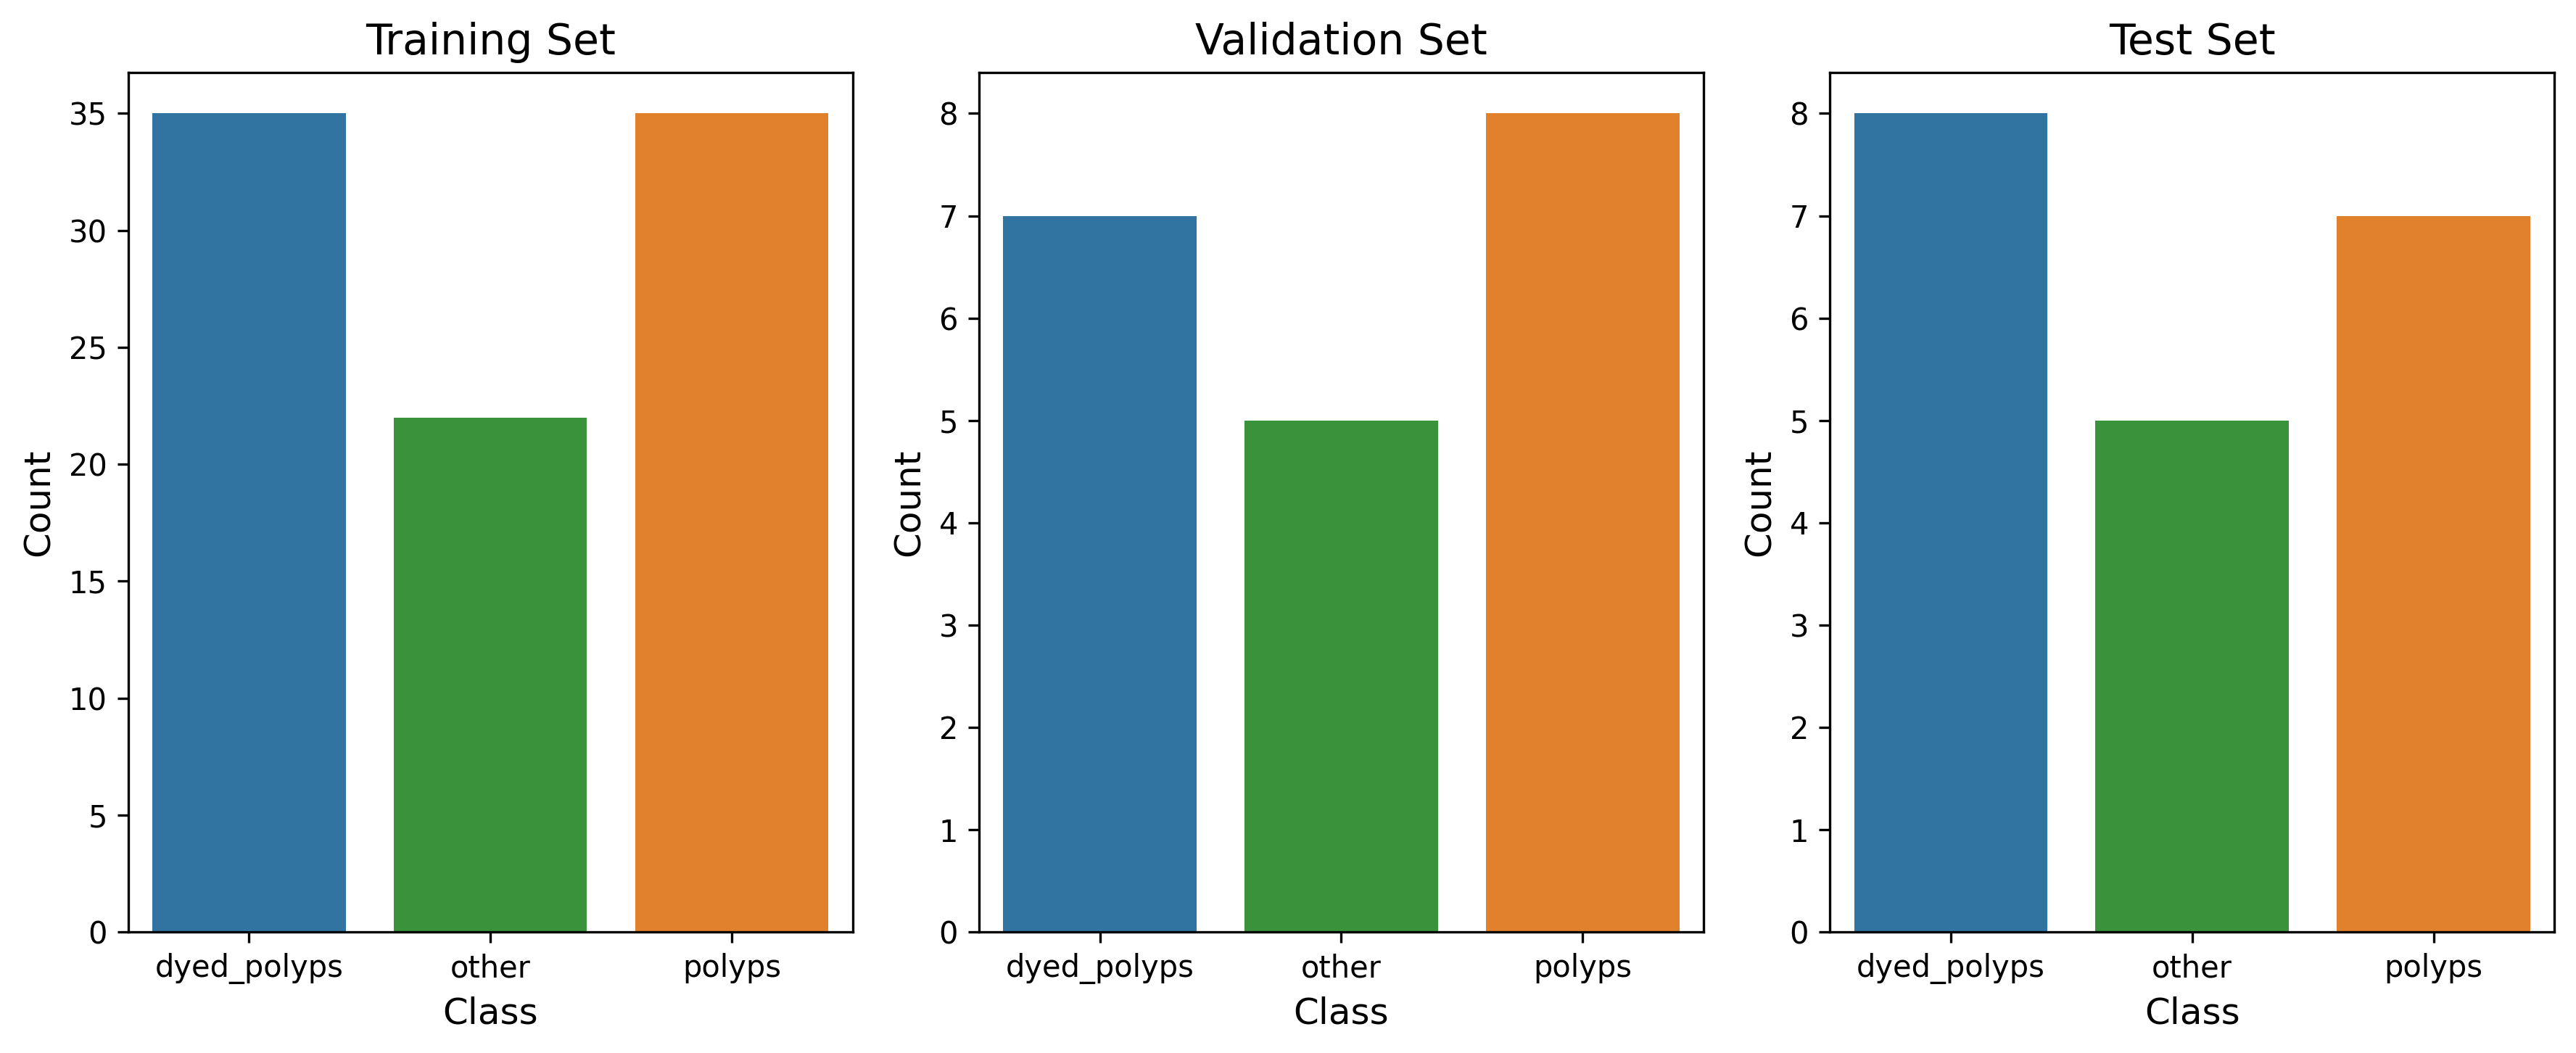

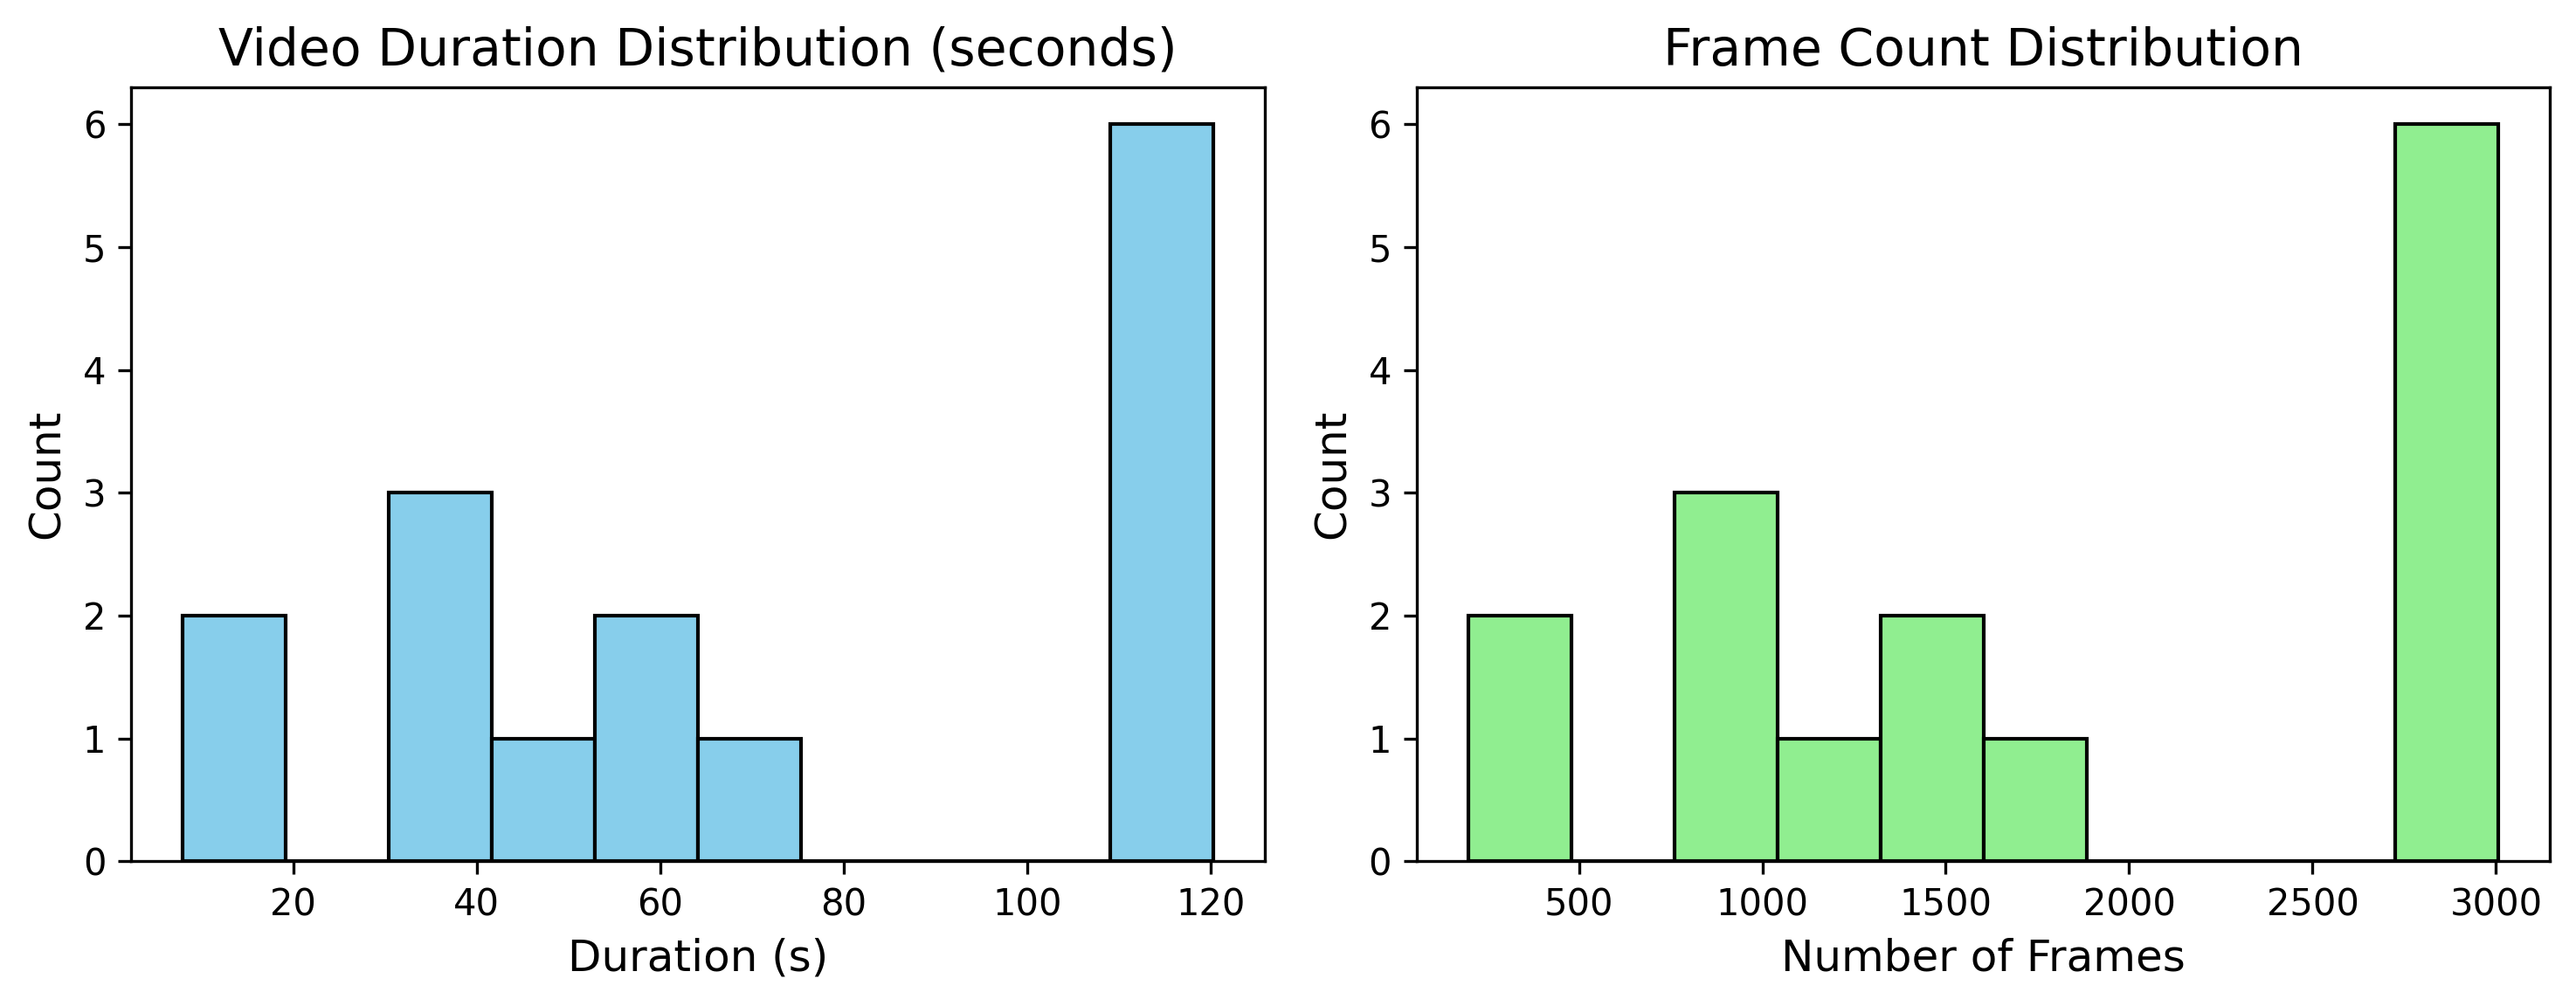

In [ ]:
## Section 2: Data Loading and Exploration

# 2.1 Data Loading Function
def load_data():
    """Load and split the dataset into train, validation and test sets"""
    all_paths = []
    all_classes = []
    all_labels = []

    # Collect all video paths and labels
    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        for video_file in os.listdir(class_path):
            if video_file.endswith('.avi'):
                all_paths.append(os.path.join(class_path, video_file))
                all_classes.append(cls)
                all_labels.append(i)

    # Create DataFrame
    data_df = pd.DataFrame({
        'path': all_paths,
        'class': all_classes,
        'label': all_labels
    })

    # Split into train, validation, and test sets
    train_df, temp_df = train_test_split(
        data_df, test_size=0.3, random_state=42, stratify=data_df['label']
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
    )

    # Print dataset statistics
    print("\nClass Distribution:")
    for cls in classes:
        count = len(data_df[data_df['class'] == cls])
        print(f"{cls}: {count} videos")

    print("\nData Split Statistics:")
    print(f"Training set: {len(train_df)} videos")
    print(f"Validation set: {len(val_df)} videos")
    print(f"Test set: {len(test_df)} videos")

    return train_df, val_df, test_df

# 2.2 Data Exploration
def explore_data():
    """Explore the dataset and visualize class distribution"""
    train_df, val_df, test_df = load_data()

    # Plot class distribution
    plt.figure(figsize=(12, 5))

    # Plot training set distribution
    plt.subplot(1, 3, 1)
    train_counts = train_df['class'].value_counts().sort_index()
    sns.barplot(x=train_counts.index, y=train_counts.values, palette=[VIZ_COLORS[c] for c in train_counts.index])
    plt.title('Training Set')
    plt.ylabel('Count')
    plt.xlabel('Class')

    # Plot validation set distribution
    plt.subplot(1, 3, 2)
    val_counts = val_df['class'].value_counts().sort_index()
    sns.barplot(x=val_counts.index, y=val_counts.values, palette=[VIZ_COLORS[c] for c in val_counts.index])
    plt.title('Validation Set')
    plt.ylabel('Count')
    plt.xlabel('Class')

    # Plot test set distribution
    plt.subplot(1, 3, 3)
    test_counts = test_df['class'].value_counts().sort_index()
    sns.barplot(x=test_counts.index, y=test_counts.values, palette=[VIZ_COLORS[c] for c in test_counts.index])
    plt.title('Test Set')
    plt.ylabel('Count')
    plt.xlabel('Class')

    plt.tight_layout()
    plt.savefig('./visualizations/class_distribution.png')
    plt.show()

    # Video duration analysis (sample a few videos)
    sample_videos = []
    for cls in classes:
        cls_df = train_df[train_df['class'] == cls]
        if len(cls_df) > 0:
            sample_videos.extend(cls_df.sample(min(5, len(cls_df)))['path'].tolist())

    durations = []
    frames = []

    for video_path in sample_videos:
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        cap.release()

        durations.append(duration)
        frames.append(frame_count)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(durations, bins=10, color='skyblue', edgecolor='black')
    plt.title('Video Duration Distribution (seconds)')
    plt.xlabel('Duration (s)')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    plt.hist(frames, bins=10, color='lightgreen', edgecolor='black')
    plt.title('Frame Count Distribution')
    plt.xlabel('Number of Frames')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig('./visualizations/video_statistics.png')
    plt.show()

    return train_df, val_df, test_df

# Call the exploration function
train_df, val_df, test_df = explore_data()



Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos


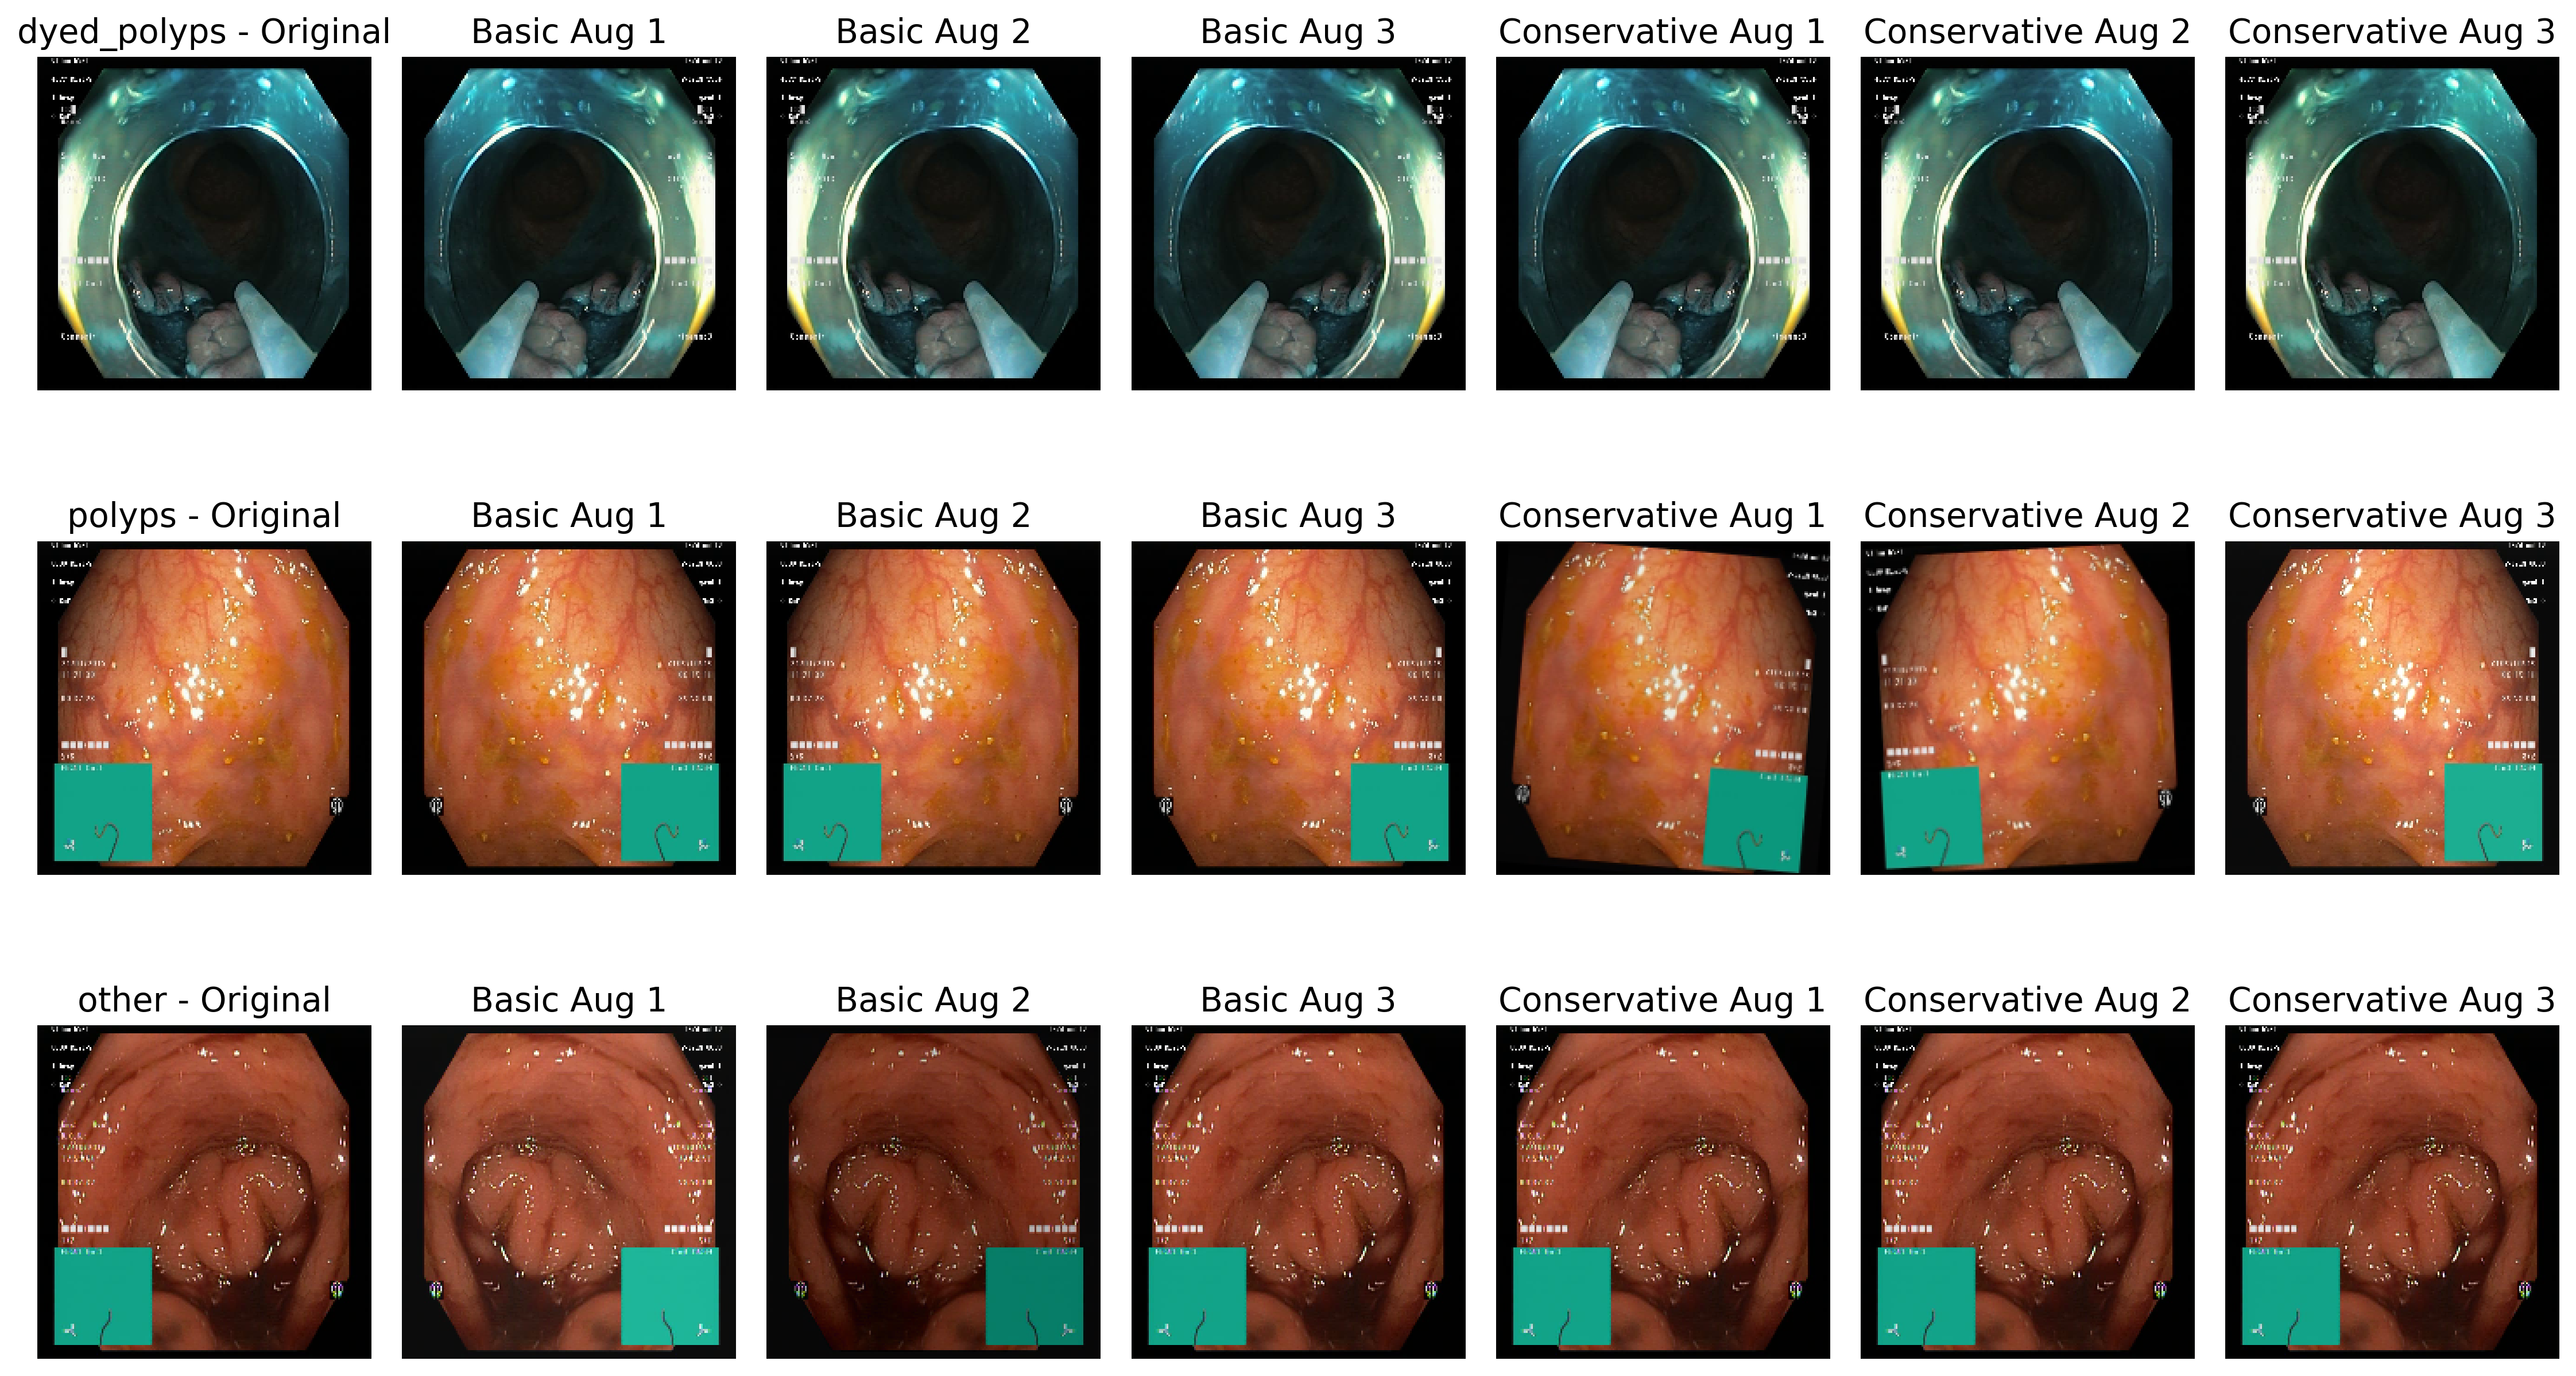

In [ ]:
## Section 3: Frame Selection and Dataset Creation

# 3.1 Basic Frame Selector
class FrameSelector:
    """Selects the most informative frames from a video"""
    def select_frames(self, video_path, num_frames=FRAMES_PER_VIDEO):
        """Select frames uniformly from the video"""
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if frame_count <= 0:
            cap.release()
            return []

        if frame_count <= num_frames:
            indices = list(range(frame_count))
            cap.release()
            return indices

        # For longer videos, sample frames uniformly
        indices = np.linspace(0, frame_count-1, num_frames, dtype=int).tolist()
        cap.release()
        return indices

# 3.2 Enhanced Frame Selector
class EnhancedFrameSelector:
    """Implements advanced frame selection strategies"""

    def select_frames_entropy(self, video_path, num_frames=FRAMES_PER_VIDEO):
        """Selects frames with highest information content based on entropy"""
        cap = cv2.VideoCapture(video_path)
        frame_entropies = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert to grayscale and calculate entropy
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            entropy = self._calculate_entropy(gray)
            frame_entropies.append((cap.get(cv2.CAP_PROP_POS_FRAMES)-1, entropy))

        cap.release()

        # Sort by entropy and select top frames
        frame_entropies.sort(key=lambda x: x[1], reverse=True)
        selected_indices = [int(idx) for idx, _ in frame_entropies[:num_frames]]

        return sorted(selected_indices)  # Return in temporal order

    def _calculate_entropy(self, gray_img):
        """Calculate Shannon entropy of an image"""
        histogram = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
        histogram = histogram / np.sum(histogram)
        non_zero_histogram = histogram[histogram > 0]
        return -np.sum(non_zero_histogram * np.log2(non_zero_histogram))

    def select_frames_motion(self, video_path, num_frames=FRAMES_PER_VIDEO):
        """Selects frames with highest motion content"""
        cap = cv2.VideoCapture(video_path)
        frame_motions = []
        prev_frame = None

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if prev_frame is not None:
                # Calculate absolute difference between consecutive frames
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
                motion = np.sum(cv2.absdiff(gray, prev_gray))
                frame_motions.append((cap.get(cv2.CAP_PROP_POS_FRAMES)-1, motion))

            prev_frame = frame

        cap.release()

        # Sort by motion and select top frames
        if frame_motions:
            frame_motions.sort(key=lambda x: x[1], reverse=True)
            selected_indices = [int(idx) for idx, _ in frame_motions[:num_frames]]

            # If we couldn't get enough frames with motion, add the first frame
            if len(selected_indices) < num_frames:
                if 0 not in selected_indices:
                    selected_indices.append(0)

                # If still not enough, add evenly spaced frames
                if len(selected_indices) < num_frames:
                    cap = cv2.VideoCapture(video_path)
                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    cap.release()

                    additional_indices = np.linspace(0, frame_count-1, num_frames).astype(int)
                    for idx in additional_indices:
                        if idx not in selected_indices and len(selected_indices) < num_frames:
                            selected_indices.append(idx)
        else:
            # Fallback to uniform selection if no motion frames
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            selected_indices = list(np.linspace(0, frame_count-1, num_frames, dtype=int))

        return sorted(selected_indices)  # Return in temporal order

    def select_frames_saliency(self, video_path, num_frames=FRAMES_PER_VIDEO):
        """Selects frames with highest visual saliency"""
        cap = cv2.VideoCapture(video_path)
        frame_saliency = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert to grayscale for saliency calculation
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Use Laplacian for a simple saliency metric (detects edges/details)
            saliency_map = cv2.Laplacian(gray, cv2.CV_64F)
            saliency = np.sum(np.abs(saliency_map))

            frame_saliency.append((cap.get(cv2.CAP_PROP_POS_FRAMES)-1, saliency))

        cap.release()

        # Sort by saliency and select top frames
        frame_saliency.sort(key=lambda x: x[1], reverse=True)
        selected_indices = [int(idx) for idx, _ in frame_saliency[:num_frames]]

        return sorted(selected_indices)  # Return in temporal order

# 3.3 Data Augmentation Functions
def simple_augment(frame):
    """Apply simple augmentations without external libraries"""
    # Random horizontal flip
    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)

    # Random brightness and contrast adjustment
    if random.random() > 0.7:
        alpha = random.uniform(0.8, 1.2)  # Contrast
        beta = random.uniform(-15, 15)    # Brightness
        frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)

    return frame

def conservative_targeted_augment(frame, class_name):
    """Apply more subtle class-specific augmentations"""
    # Base mild augmentations for all classes
    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)  # horizontal flip - safe transformation

    # For polyps class, apply moderate augmentations
    if class_name == "polyps":
        # Mild color adjustment
        if random.random() > 0.5:
            # More conservative contrast/brightness adjustments
            alpha = random.uniform(0.9, 1.1)
            beta = random.uniform(-10, 10)
            frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)

        # Smaller rotation angles
        if random.random() > 0.6:
            angle = random.uniform(-15, 15)  # Reduced rotation angle
            h, w = frame.shape[:2]
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
            frame = cv2.warpAffine(frame, M, (w, h))

    # For dyed_polyps class, focus on very mild color transformations
    elif class_name == "dyed_polyps":
        # Subtle color shifts
        if random.random() > 0.5:
            hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
            # Very subtle hue adjustment
            hsv[:,:,0] = hsv[:,:,0] * random.uniform(0.95, 1.05)
            # Subtle saturation adjustment
            hsv[:,:,1] = hsv[:,:,1] * random.uniform(0.9, 1.1)
            frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # For "other" class, minimal augmentations

    return frame

# 3.4 Visualize Augmentations
def visualize_augmentations():
    """Visualize the effect of different augmentation strategies"""
    # Load data
    train_df, _, _ = load_data()

    augmentation_samples = {}

    for cls in classes:
        # Get a sample from this class
        sample_df = train_df[train_df['class'] == cls].sample(1)
        video_path = sample_df['path'].values[0]

        # Load a frame from the video
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()

        if ret:
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, TARGET_SIZE)

            # Store original
            augmentation_samples[f"{cls}_original"] = frame.copy()

            # Basic augmentation
            basic_frames = []
            for i in range(3):
                basic_frames.append(simple_augment(frame.copy()))
            augmentation_samples[f"{cls}_basic"] = basic_frames

            # Conservative augmentation
            conservative_frames = []
            for i in range(3):
                conservative_frames.append(conservative_targeted_augment(frame.copy(), cls))
            augmentation_samples[f"{cls}_conservative"] = conservative_frames

    # Visualize the augmentations
    plt.figure(figsize=(15, 9))

    for i, cls in enumerate(classes):
        # Original frame
        plt.subplot(3, 7, i*7 + 1)
        plt.imshow(augmentation_samples[f"{cls}_original"])
        plt.title(f"{cls} - Original")
        plt.axis('off')

        # Basic augmentations
        for j in range(3):
            plt.subplot(3, 7, i*7 + j + 2)
            plt.imshow(augmentation_samples[f"{cls}_basic"][j])
            plt.title(f"Basic Aug {j+1}")
            plt.axis('off')

        # Conservative augmentations
        for j in range(3):
            plt.subplot(3, 7, i*7 + j + 5)
            plt.imshow(augmentation_samples[f"{cls}_conservative"][j])
            plt.title(f"Conservative Aug {j+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('./visualizations/augmentation_comparison.png')
    plt.show()

# 3.5 Dataset Classes
class GIVideoDataset(Dataset):
    """Dataset class for GI videos"""
    def __init__(self, video_paths, labels, train=False, num_frames=FRAMES_PER_VIDEO):
        self.video_paths = video_paths
        self.labels = labels
        self.train = train
        self.num_frames = num_frames
        self.frame_selector = FrameSelector()

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        # Get frame indices
        frame_indices = self.frame_selector.select_frames(video_path, self.num_frames)

        # Extract frames
        frames = []
        if len(frame_indices) > 0:
            cap = cv2.VideoCapture(video_path)

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, TARGET_SIZE)

                    # Apply augmentations for training
                    if self.train:
                        frame = simple_augment(frame)

                    # Normalize to [0,1]
                    frame = frame.astype(np.float32) / 255.0
                    frames.append(frame)

            cap.release()

        # Handle insufficient frames
        if len(frames) < self.num_frames:
            if len(frames) > 0:
                frames.extend([frames[-1]] * (self.num_frames - len(frames)))
            else:
                blank_frame = np.zeros((TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=np.float32)
                frames = [blank_frame] * self.num_frames

        # Convert to tensor [C, T, H, W]
        frames = np.array(frames).transpose(3, 0, 1, 2)
        frames = torch.tensor(frames, dtype=torch.float32)

        return frames, label

class EnhancedGIVideoDataset(Dataset):
    """Enhanced dataset with multiple frame selection strategies"""

    def __init__(self, video_paths, labels, class_names=None, train=False,
                 num_frames=FRAMES_PER_VIDEO, selection_strategy="uniform"):
        self.video_paths = video_paths
        self.labels = labels
        self.class_names = class_names if class_names is not None else [None] * len(labels)
        self.train = train
        self.num_frames = num_frames
        self.selection_strategy = selection_strategy
        self.frame_selector = FrameSelector()
        self.enhanced_selector = EnhancedFrameSelector()

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        # Select frame indices based on strategy
        if self.selection_strategy == "uniform":
            frame_indices = self.frame_selector.select_frames(video_path, self.num_frames)
        elif self.selection_strategy == "entropy":
            frame_indices = self.enhanced_selector.select_frames_entropy(video_path, self.num_frames)
        elif self.selection_strategy == "motion":
            frame_indices = self.enhanced_selector.select_frames_motion(video_path, self.num_frames)
        elif self.selection_strategy == "saliency":
            frame_indices = self.enhanced_selector.select_frames_saliency(video_path, self.num_frames)
        else:
            raise ValueError(f"Unknown selection strategy: {self.selection_strategy}")

        # Extract frames
        frames = []
        if len(frame_indices) > 0:
            cap = cv2.VideoCapture(video_path)

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, TARGET_SIZE)

                    # Apply augmentations for training
                    if self.train:
                        frame = simple_augment(frame)

                    # Normalize to [0,1]
                    frame = frame.astype(np.float32) / 255.0
                    frames.append(frame)

            cap.release()

        # Handle insufficient frames
        if len(frames) < self.num_frames:
            if len(frames) > 0:
                # Repeat last frame if we have at least one
                frames.extend([frames[-1]] * (self.num_frames - len(frames)))
            else:
                # Create blank frames if we couldn't extract any
                blank_frame = np.zeros((TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=np.float32)
                frames = [blank_frame] * self.num_frames

        # Convert to tensor [C, T, H, W]
        frames = np.array(frames).transpose(3, 0, 1, 2)
        frames = torch.tensor(frames, dtype=torch.float32)

        return frames, label

class ConservativeGIVideoDataset(Dataset):
    """Dataset with conservative targeted augmentations based on class"""

    def __init__(self, video_paths, labels, class_names, train=False, num_frames=FRAMES_PER_VIDEO):
        self.video_paths = video_paths
        self.labels = labels
        self.class_names = class_names
        self.train = train
        self.num_frames = num_frames
        self.frame_selector = FrameSelector()

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        class_name = self.class_names[idx]

        # Use uniform frame selection
        frame_indices = self.frame_selector.select_frames(video_path, self.num_frames)

        # Extract frames
        frames = []
        if len(frame_indices) > 0:
            cap = cv2.VideoCapture(video_path)

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, TARGET_SIZE)

                    # Apply conservative augmentations for training
                    if self.train:
                        frame = conservative_targeted_augment(frame, class_name)

                    # Normalize to [0,1]
                    frame = frame.astype(np.float32) / 255.0
                    frames.append(frame)

            cap.release()

        # Handle insufficient frames
        if len(frames) < self.num_frames:
            if len(frames) > 0:
                frames.extend([frames[-1]] * (self.num_frames - len(frames)))
            else:
                blank_frame = np.zeros((TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=np.float32)
                frames = [blank_frame] * self.num_frames

        # Convert to tensor [C, T, H, W]
        frames = np.array(frames).transpose(3, 0, 1, 2)
        frames = torch.tensor(frames, dtype=torch.float32)

        return frames, label

# Visualize augmentations
visualize_augmentations()


In [ ]:
## Section 4: Model Architectures

# 4.1 MobileNetV2 with Attention
class MobileNetAttention(nn.Module):
    def __init__(self, num_classes=3):
        super(MobileNetAttention, self).__init__()

        # Create model without pretrained weights
        self.backbone = models.mobilenet_v2(pretrained=False, width_mult=0.5)
        self.feature_dim = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # Frame-level attention (simplified)
        self.attention = nn.Sequential(
            nn.Linear(self.feature_dim, 1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        batch_size, channels, timesteps, height, width = x.size()

        # Process frames
        x = x.view(batch_size * timesteps, channels, height, width)
        features = self.backbone(x)
        features = features.view(batch_size, timesteps, -1)

        # Attention mechanism
        weights = self.attention(features)
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-7)

        # Weighted sum
        context = torch.sum(weights * features, dim=1)

        # Classification
        output = self.classifier(context)

        return output

# 4.2 Efficient 3D CNN
class EfficientCNN3D(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientCNN3D, self).__init__()

        # Use smaller channels
        self.conv1 = nn.Conv3d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))

        # Global pooling
        self.gap = nn.AdaptiveAvgPool3d(1)

        # Classifier
        self.classifier = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = self.classifier(x)

        return x

# 4.3 ResNet18 with Temporal Pooling
class ResNetTemporal(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetTemporal, self).__init__()

        # Use ResNet18 without pretrained weights
        resnet = models.resnet18(pretrained=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Add temporal pooling
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Final classifier
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, channels, timesteps, height, width = x.size()

        # Process each frame
        x = x.view(batch_size * timesteps, channels, height, width)
        features = self.backbone(x)

        # Spatial pooling
        features = self.pool(features).view(batch_size, timesteps, -1)

        # Temporal pooling (average across time)
        features = torch.mean(features, dim=1)

        # Classification
        out = self.classifier(features)

        return out

# 4.4 EfficientNet-LSTM Model
class EfficientNetLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientNetLSTM, self).__init__()

        # Use EfficientNet-B0 as feature extractor (without pretrained weights)
        try:
            # Try importing from timm if available
            import timm
            self.backbone = timm.create_model('efficientnet_b0', pretrained=False, num_classes=0)
            self.feature_dim = 1280  # EfficientNet-B0 feature dimension
        except:
            # Fallback to torchvision
            from torchvision.models import efficientnet_b0
            efficient_net = efficientnet_b0(pretrained=False)
            self.backbone = nn.Sequential(*list(efficient_net.children())[:-1])
            self.feature_dim = 1280  # EfficientNet-B0 feature dimension

        # Add LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=256,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.5
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, channels, timesteps, height, width = x.size()

        # Process frames through the backbone
        x = x.view(batch_size * timesteps, channels, height, width)
        features = self.backbone(x)

        # Reshape features for LSTM
        features = features.view(batch_size, timesteps, self.feature_dim)

        # Pass through LSTM
        lstm_out, _ = self.lstm(features)

        # Use final timestep output
        final_features = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(final_features)

        return output

# 4.5 Model Visualization Function
def visualize_model_architectures():
    """Visualize the architectures of all models"""
    from torchviz import make_dot
    import torch.nn as nn

    # Create figure
    plt.figure(figsize=(15, 10))

    # Create a dummy input tensor
    dummy_input = torch.randn(2, 3, FRAMES_PER_VIDEO, TARGET_SIZE[0], TARGET_SIZE[1]).to(device)

    # List of model classes to visualize
    models = [
        ("MobileNetAttention", MobileNetAttention(num_classes=len(classes))),
        ("EfficientCNN3D", EfficientCNN3D(num_classes=len(classes))),
        ("ResNetTemporal", ResNetTemporal(num_classes=len(classes))),
        ("EfficientNetLSTM", EfficientNetLSTM(num_classes=len(classes)))
    ]

    # Print model summaries
    print("Model architecture summaries:")
    for name, model in models:
        print(f"\n{'-'*30}\n{name} Summary:\n{'-'*30}")
        model = model.to(device)

        # Print total parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        # Print model inputs and outputs
        print(f"Input shape: {dummy_input.shape}")
        with torch.no_grad():
            output = model(dummy_input)
        print(f"Output shape: {output.shape}")

    print("\nAll model architectures initialized successfully.")



Starting Model Training

Training MobileNetAttention Model

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Training MobileNetAttention for 20 epochs
Epoch 1/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4826d840] warning: first frame is no keyframe
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4826d840] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47d92240] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e8a700] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4814de00] warning: first frame is no keyframe
[vc1 @ 0x4814

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e4b5c80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 1.2973, Acc: 0.4348, F1: 0.4348
Val Loss: 1.9462, Acc: 0.2500, F1: 0.1000
New best model saved: ./models/MobileNetAttention_best_f1_0.1000.pth
Epoch 2/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5acf5b00] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4e4bfe80] warning: first frame is no keyframe
[vc1 @ 0x4dda0040] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4dda0040] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4dda0040] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4dda0040] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4dda0040] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4dda0040] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4dda0040] warning: first frame is no keyframe
[vc1 @ 0x4dda0040] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4bfe80] Bits overconsumption: 110496 > 110488 at 8

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x47f989c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 1.0282, Acc: 0.4457, F1: 0.4457
Val Loss: 5.4757, Acc: 0.2500, F1: 0.1000
Epoch 3/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e550640] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e550640] warning: first frame is no keyframe
[vc1 @ 0x4e550640] warning: first frame is no keyframe
[vc1 @ 0x4e550640] warning: first frame is no keyframe
[vc1 @ 0x4e550640] warning: first frame is no keyframe
[vc1 @ 0x4e55

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aeb1a40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 1.0339, Acc: 0.6087, F1: 0.6087
Val Loss: 6.4890, Acc: 0.2500, F1: 0.1000
Epoch 4/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acfd940] warning: first frame is no keyframe
[vc1 @ 0x5acfd940] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5aec7f80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aec7f80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aec7f80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aec7f80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aec7f80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5ad0cc00] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5acfd940] warning: first frame is no keyframe
[vc1 @ 0x5acfd940] warning: first frame is no keyframe
[vc1 @ 0x5acfd940] warning: first frame is no keyframe
[vc1 @ 0x

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x47f077c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8899, Acc: 0.6087, F1: 0.6087
Val Loss: 3.1955, Acc: 0.3500, F1: 0.2591
New best model saved: ./models/MobileNetAttention_best_f1_0.2591.pth
Epoch 5/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e550640] warning: first frame is no keyframe
[vc1 @ 0x4e550640] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x4f5dc140] warning: first frame is no keyframe
[vc1 @ 0x5aced780] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e550640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e550640] Bits overconsumption: 20392 > 20

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e45b6c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.9104, Acc: 0.5652, F1: 0.5652
Val Loss: 1.1697, Acc: 0.5500, F1: 0.4971
New best model saved: ./models/MobileNetAttention_best_f1_0.4971.pth
Epoch 6/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5ad14880] warning: first frame is no keyframe
[vc1 @ 0x5ad14880] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5acc6ac0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6ac0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6ac0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6ac0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6ac0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acb9400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acb9400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acb9400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acb9400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acb9400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acb9400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acc6ac0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5acb9400] warning: first frame is no keyframe
[vc1 @ 0x5acb9400] warning: first frame is no keyframe
[vc1 @ 0x5a

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aedb100] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8187, Acc: 0.6304, F1: 0.6304
Val Loss: 0.8727, Acc: 0.5500, F1: 0.5292
New best model saved: ./models/MobileNetAttention_best_f1_0.5292.pth
Epoch 7/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e530b80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e530b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e530b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e530b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e530b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e530b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e530b80] warning: first frame is no keyframe
[vc1 @ 0x4e530b80] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e530b80] warning: first frame is no keyf

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acfb580] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5387, Acc: 0.8152, F1: 0.8152
Val Loss: 1.9498, Acc: 0.5500, F1: 0.4333
Epoch 8/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4a1240] warning: first frame is no keyframe
[vc1 @ 0x4e4a1240] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x5aed5280] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed5280] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed5280] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed5280] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed5280] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed5280] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47f4

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e4d8c80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7178, Acc: 0.5978, F1: 0.5978
Val Loss: 0.8193, Acc: 0.6500, F1: 0.6170
New best model saved: ./models/MobileNetAttention_best_f1_0.6170.pth
Epoch 9/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4ebf00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4ebf00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4ebf00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4ebf00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4ebf00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4ebf00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acc6940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acc6940] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4dd96c00] warning: first frame is no keyframe
[vc1 @ 0x4dd96c00] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5a

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acd5fc0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6999, Acc: 0.7935, F1: 0.7935
Val Loss: 1.3686, Acc: 0.4000, F1: 0.3520
Epoch 10/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e498b00] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x5acf7000] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acf7000] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acf7000] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acf7000] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acf7000] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acf7000] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e498b00] warning: first frame is no keyframe
[vc1 @ 0x4e498b00] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5acf7000] Bits overconsumption: 110496 > 110488 at 8

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aefcf00] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6708, Acc: 0.7283, F1: 0.7283
Val Loss: 1.8150, Acc: 0.5000, F1: 0.4056
Epoch 11/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aec3840] warning: first frame is no keyframe
[vc1 @ 0x5aebe5c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebe5c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebe5c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebe5c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebe5c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aec3840] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aec3840] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aec3840] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aec3840] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aec3840] Bits overconsumptio

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e51c100] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6506, Acc: 0.7283, F1: 0.7283
Val Loss: 0.8928, Acc: 0.5500, F1: 0.5429
Epoch 12/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5ace1180] warning: first frame is no keyframe
[vc1 @ 0x5af020c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5af020c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5af020c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5af020c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5af020c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed4d40] warning: first frame is no keyframe
[vc1 @ 0x5aed4d40] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5aeabd40] warning: first frame is no keyframe
[vc1 @ 0x5aeabd40] warning: first frame is no keyframe
[vc1 @ 0x5aeabd40] warning: first frame is no keyframe
[vc1 @ 0x5aea

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acd8000] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5561, Acc: 0.8043, F1: 0.8043
Val Loss: 0.8321, Acc: 0.7000, F1: 0.6866
New best model saved: ./models/MobileNetAttention_best_f1_0.6866.pth
Epoch 13/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x47e0fec0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47e0fec0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47e0fec0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47e0fec0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47e0fec0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5ad14300] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad14300] warning: first frame is no keyframe
[vc1 @ 0x5ad14300] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad14300] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad14300] Bits overconsumption: 20392

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aeb9780] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4350, Acc: 0.8370, F1: 0.8370
Val Loss: 1.2924, Acc: 0.4500, F1: 0.4185
Epoch 14/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aeb3540] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aeb3540] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aeb3540] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aeb3540] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aeb3540] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aeb3540] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f9c740] warning: first frame is no keyframe
[vc1 @ 0x47f9c740] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5aeb3540] warning: first frame is no keyframe
[vc1 @ 0x5aeb3540] warning: first frame is no keyframe
[vc1 @ 0x5aeb3540] warning: first frame is no keyframe
[vc1 @ 0x

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acc8f40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4533, Acc: 0.8261, F1: 0.8261
Val Loss: 0.9304, Acc: 0.6000, F1: 0.6128
Epoch 15/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aee3c00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee3c00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee3c00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee3c00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee3c00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee3c00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aee3c00] warning: first frame is no keyframe
[vc1 @ 0x5aee3c00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aee3c00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aee3c00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aee3c00] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5aee3c00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aee3c00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aee3c00] warning: first frame is no keyframe
[vc1 @ 0x5aee3c00] warning: first frame is no keyframe
[vc1 @ 0x5a

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aef5e40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4654, Acc: 0.8696, F1: 0.8696
Val Loss: 0.7121, Acc: 0.6500, F1: 0.6417
Epoch 16/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeaee40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeaee40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeaee40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeaee40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeaee40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeaee40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad1a540] warning: first frame is no keyframe
[vc1 @ 0x5ad1a540] warning: first frame is no keyframe
[vc1 @ 0x5ad1a540] warning: first frame is no keyframe
[vc1 @ 0x5ad1a540] warning: first frame is no keyframe
[vc1 @ 0x5ad1a540] warni

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x47f9c740] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5766, Acc: 0.8043, F1: 0.8043
Val Loss: 0.8364, Acc: 0.6500, F1: 0.6417
Epoch 17/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x5aec5fc0] warning: first frame is no keyframe
[vc1 @ 0x47f98300] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aec5fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aec5fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aec5fc0] Bits overconsumption:

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aebf2c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4534, Acc: 0.8152, F1: 0.8152
Val Loss: 0.7870, Acc: 0.6500, F1: 0.6417
Epoch 18/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x4e4db640] warning: first frame is no keyframe
[vc1 @ 0x5af1

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x47f43080] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.3867, Acc: 0.8478, F1: 0.8478
Val Loss: 0.8046, Acc: 0.6500, F1: 0.6499
Epoch 19/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aef6a80] warning: first frame is no keyframe
[vc1 @ 0x5aef6a80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aef6a80] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e46fc00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e46fc00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e46fc00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e46fc00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e46fc00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e46fc00] warning: first frame is no keyframe
[vc1 @ 0x4e46fc00] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5aeda6c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeda6c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeda6c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeda6c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeda6c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aeda6c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e46fc00] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4331, Acc: 0.8478, F1: 0.8478
Val Loss: 0.8259, Acc: 0.7000, F1: 0.6931
New best model saved: ./models/MobileNetAttention_best_f1_0.6931.pth
Epoch 20/20 | Model: MobileNetAttention
------------------------------


Train MobileNetAttention:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aee85c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee85c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee85c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee85c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee85c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aee85c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5acff680] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acff680] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acff680] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acff680] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acecb80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acecb80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acecb80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acecb80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acff680] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acecb80] Bits overconsum

Val MobileNetAttention:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aefb140] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4104, Acc: 0.8696, F1: 0.8696
Val Loss: 0.8048, Acc: 0.6500, F1: 0.6499
Best model saved to ./models/MobileNetAttention_weights.pth


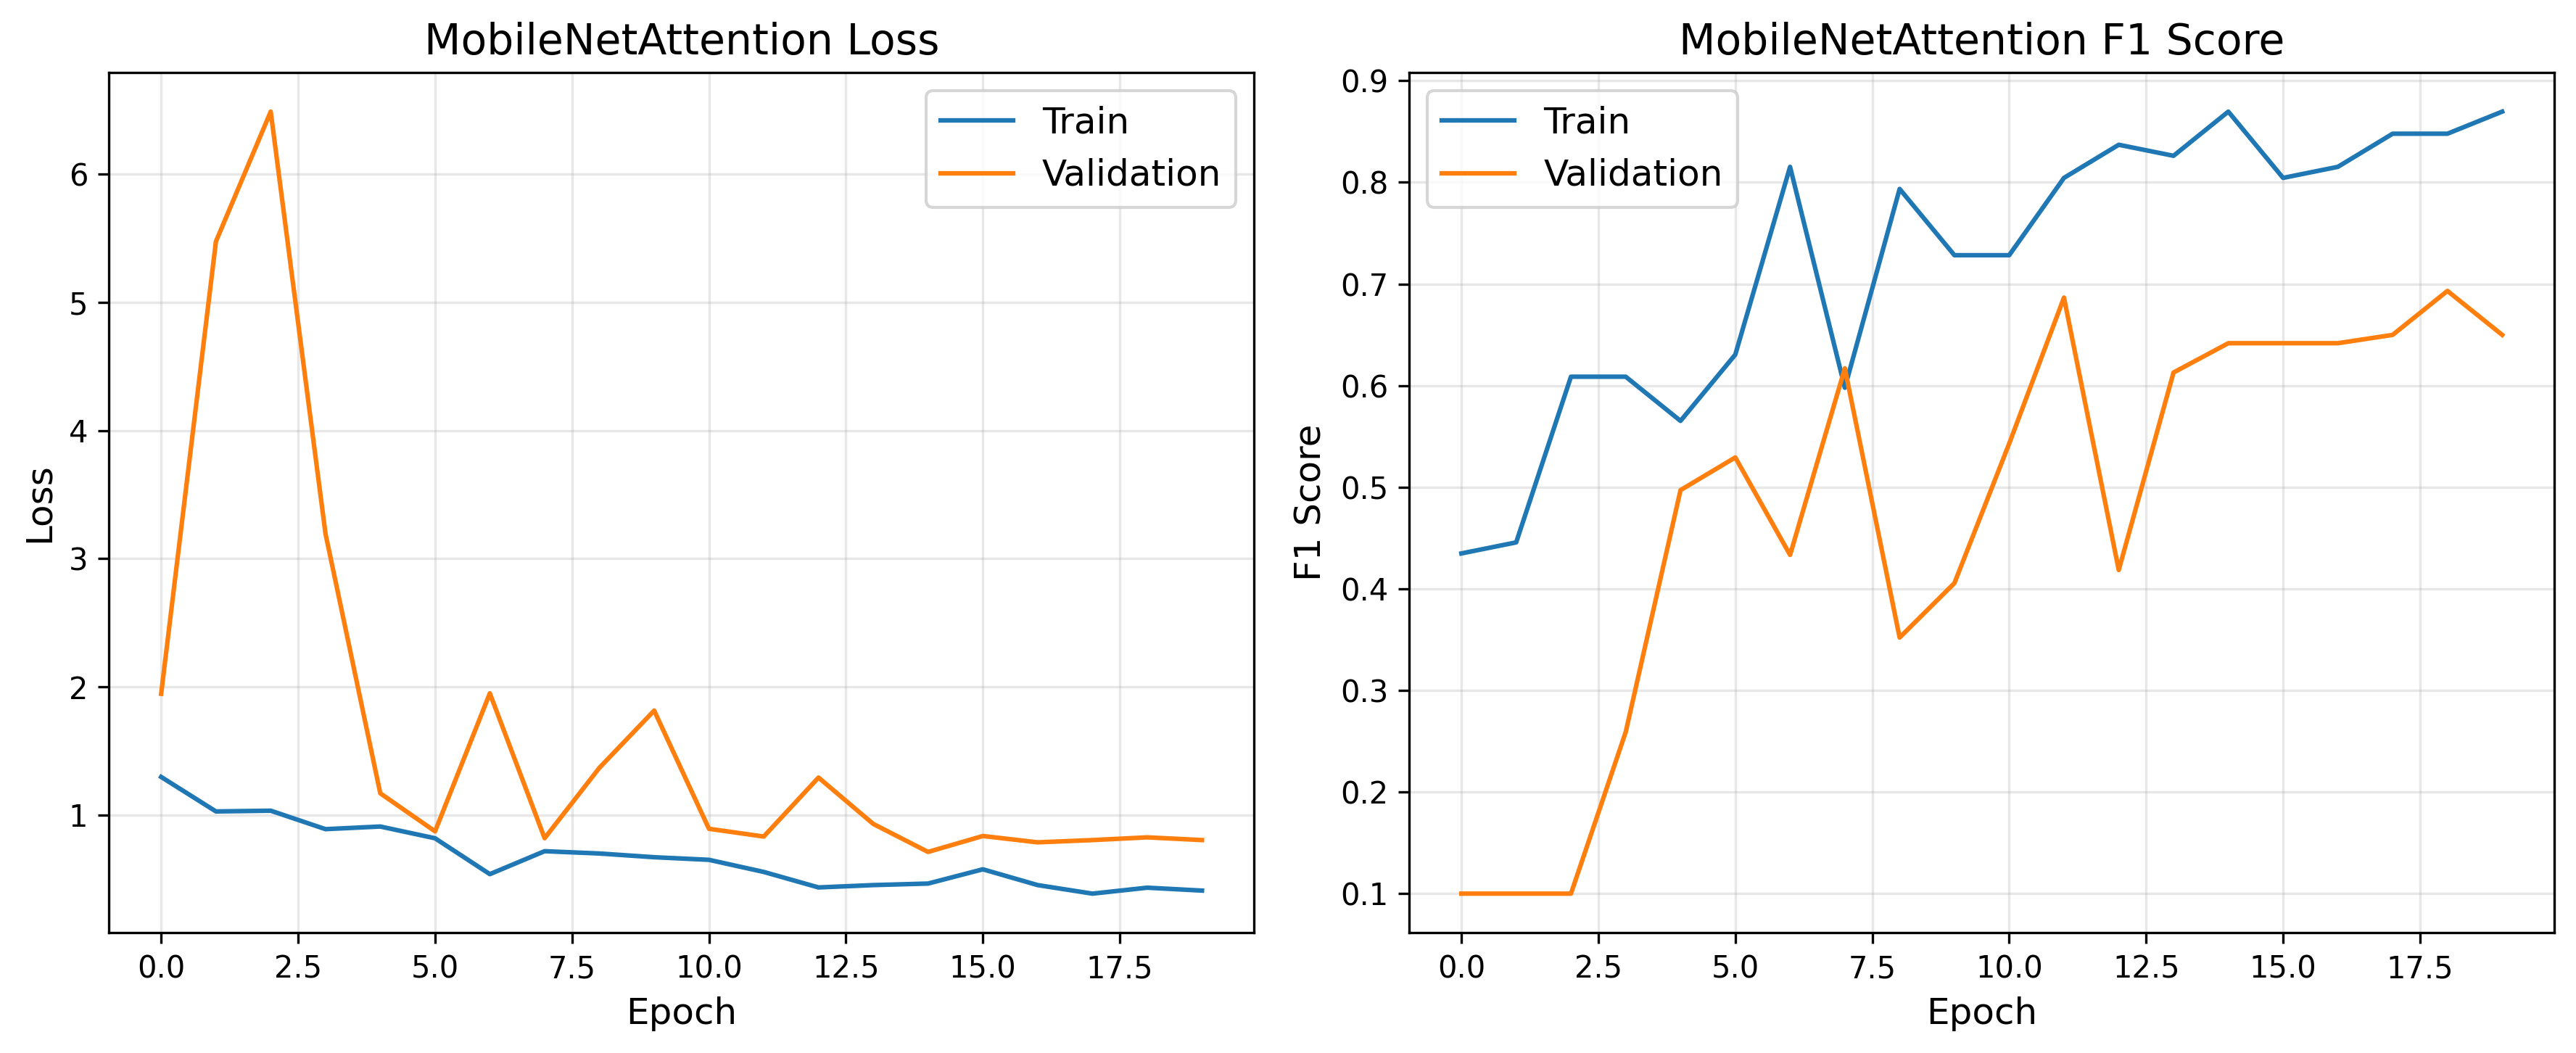


Training EfficientCNN3D Model

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Training EfficientCNN3D for 20 epochs
Epoch 1/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e529e40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.9868, Acc: 0.5000, F1: 0.5000
Val Loss: 1.0243, Acc: 0.4000, F1: 0.3386
New best model saved: ./models/EfficientCNN3D_best_f1_0.3386.pth
Epoch 2/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e546080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumptio

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aef18c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8543, Acc: 0.6413, F1: 0.6413
Val Loss: 1.0510, Acc: 0.4500, F1: 0.3879
New best model saved: ./models/EfficientCNN3D_best_f1_0.3879.pth
Epoch 3/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e529e40] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumpti

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e546080] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8355, Acc: 0.6413, F1: 0.6413
Val Loss: 0.8917, Acc: 0.8000, F1: 0.7806
New best model saved: ./models/EfficientCNN3D_best_f1_0.7806.pth
Epoch 4/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[v

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e54d3c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7663, Acc: 0.7065, F1: 0.7065
Val Loss: 1.0036, Acc: 0.6000, F1: 0.5712
Epoch 5/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 11

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e546080] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8462, Acc: 0.6630, F1: 0.6630
Val Loss: 0.9284, Acc: 0.7500, F1: 0.7361
Epoch 6/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e54d3c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7391, Acc: 0.7500, F1: 0.7500
Val Loss: 0.9446, Acc: 0.7500, F1: 0.7340
Epoch 7/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e54d3c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] warning: first frame is no keyframe
[vc1

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aef18c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8017, Acc: 0.6739, F1: 0.6739
Val Loss: 0.9353, Acc: 0.7500, F1: 0.7376
Epoch 8/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e54d3c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] Bits overconsumption: 20392 > 

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e54d3c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7664, Acc: 0.6630, F1: 0.6630
Val Loss: 1.0783, Acc: 0.7000, F1: 0.6915
Epoch 9/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e54d3c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e529e40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e529e40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7762, Acc: 0.7717, F1: 0.7717
Val Loss: 0.9440, Acc: 0.7500, F1: 0.7047
Epoch 10/20 | Model: EfficientCNN3D
------------------------------


Train EfficientCNN3D:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e546080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x5aef18c0] warning: first frame is no keyframe
[vc1 @ 0x4e54

Val EfficientCNN3D:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aef18c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8691, Acc: 0.6630, F1: 0.6630
Val Loss: 0.9725, Acc: 0.7500, F1: 0.7361
Early stopping triggered after 10 epochs
Best model saved to ./models/EfficientCNN3D_weights.pth


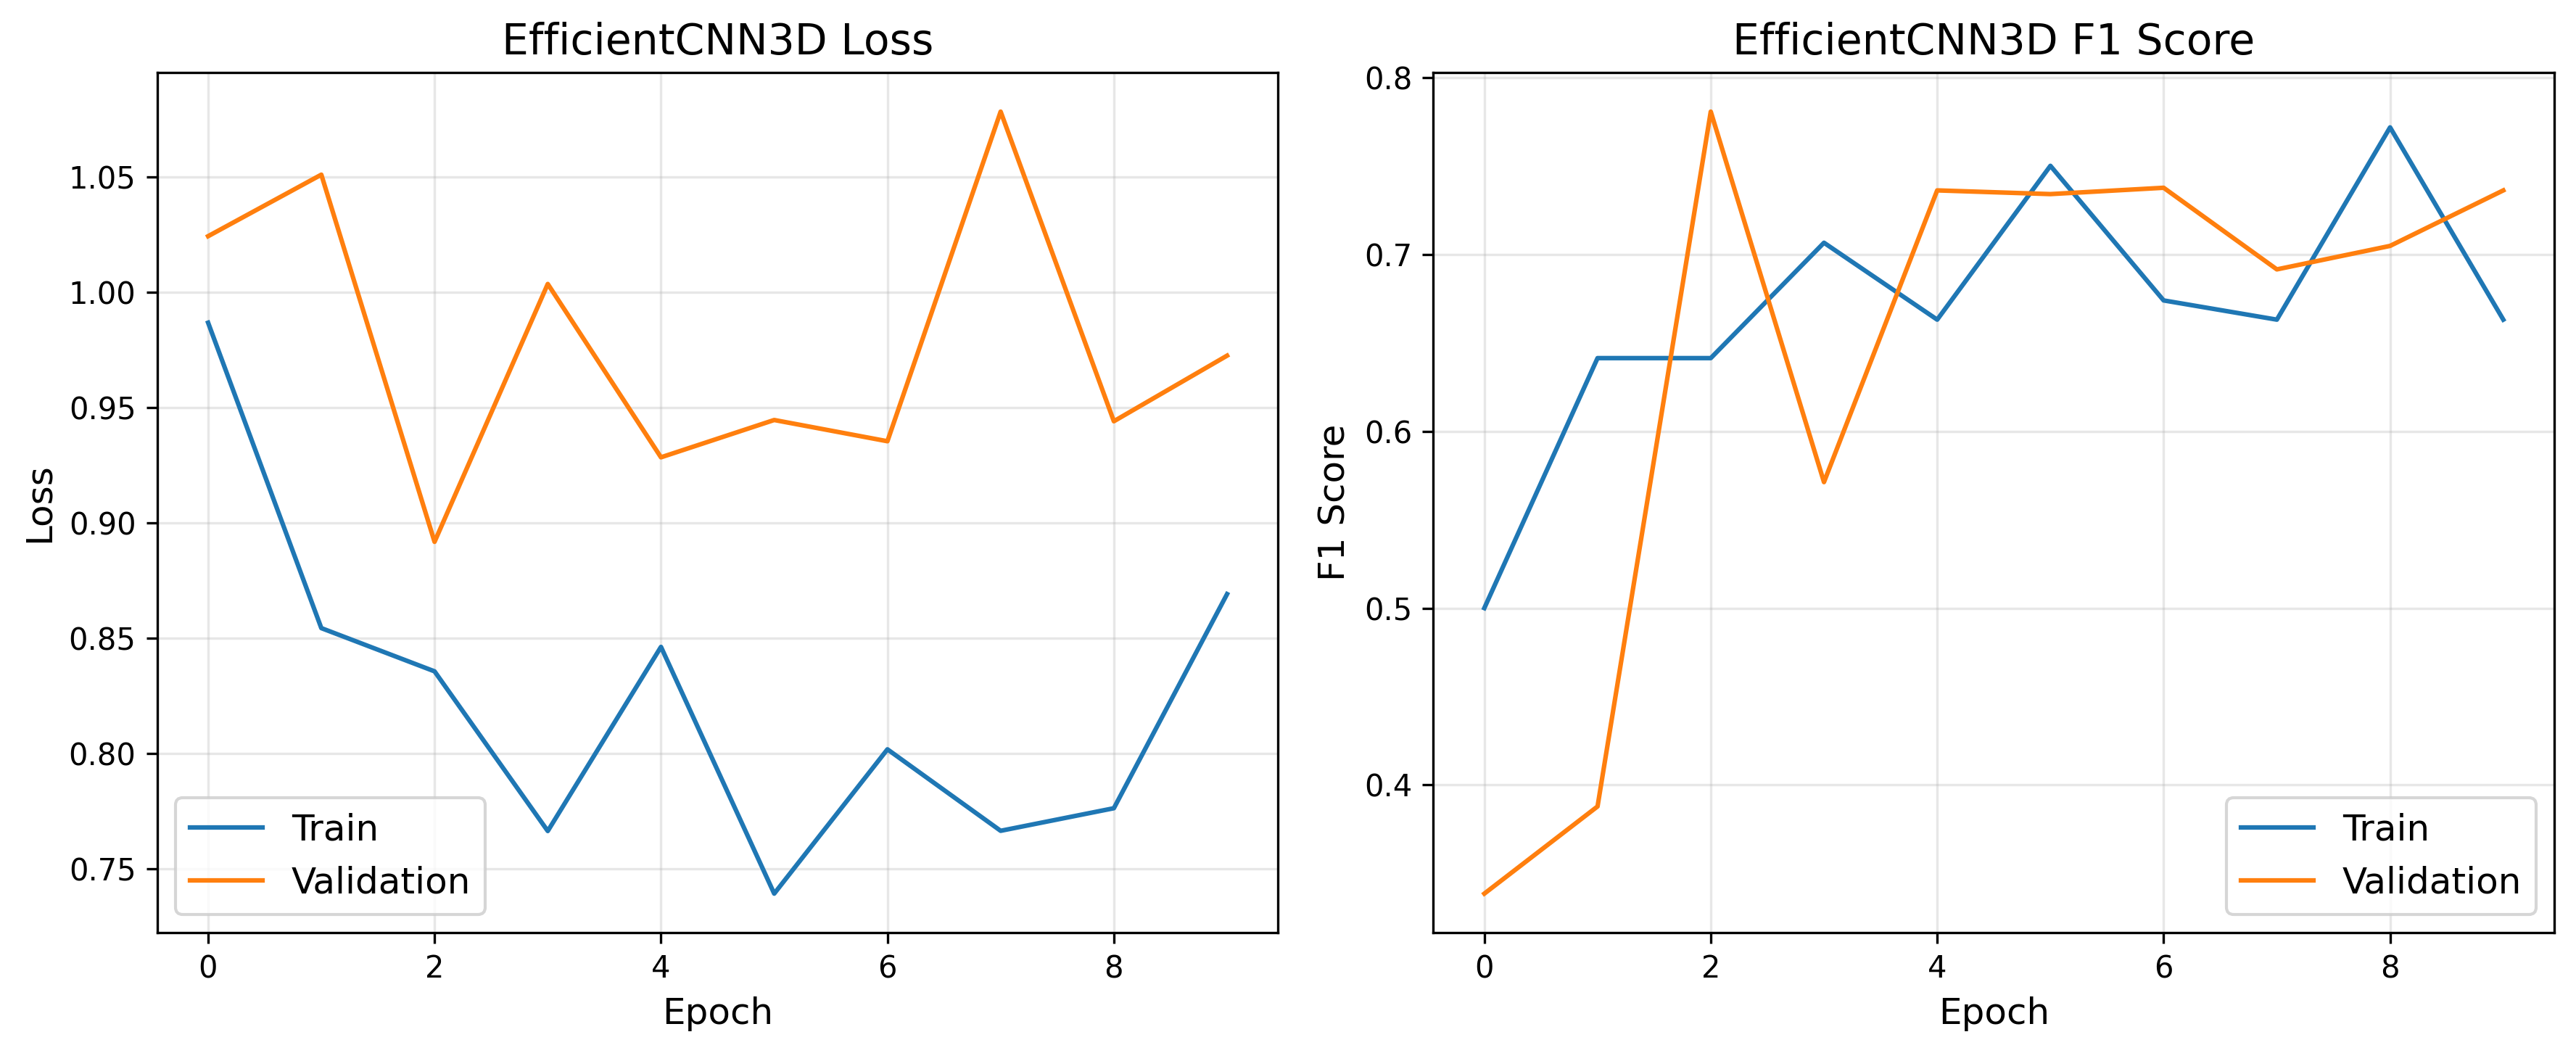


Training ResNetTemporal Model

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Training ResNetTemporal for 20 epochs
Epoch 1/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x47f43080] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] warning: first frame is no keyframe
[vc1 @ 0x47f43080] 

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acedc00] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 1.2357, Acc: 0.5000, F1: 0.5000
Val Loss: 9.0394, Acc: 0.2500, F1: 0.1000
New best model saved: ./models/ResNetTemporal_best_f1_0.1000.pth
Epoch 2/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4b5440] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e4b5440] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e4b5440] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e4b5440] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e4b5440] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x47e2c800] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5b02cc00] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 1.0079, Acc: 0.5543, F1: 0.5543
Val Loss: 2.3449, Acc: 0.4000, F1: 0.2865
New best model saved: ./models/ResNetTemporal_best_f1_0.2865.pth
Epoch 3/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x5acc6940] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e511a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumption: 110496 > 110

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e5110c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8761, Acc: 0.6304, F1: 0.6304
Val Loss: 1.3908, Acc: 0.5000, F1: 0.4567
New best model saved: ./models/ResNetTemporal_best_f1_0.4567.pth
Epoch 4/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4b5440] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x56c8a2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c8a2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c8a2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c8a2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c8a2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c8a2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47e0fec0] Bits overconsumption: 110496 > 110488 at 8x17
[vc

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5b030440] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8635, Acc: 0.6957, F1: 0.6957
Val Loss: 2.1692, Acc: 0.5500, F1: 0.5451
New best model saved: ./models/ResNetTemporal_best_f1_0.5451.pth
Epoch 5/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x56cbff40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cbff40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cbff40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cbff40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cbff40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acedc00] warning: first frame is no keyframe
[vc1 @ 0x5acedc00] Bits overconsumption: 267976 > 267968
[vc1 @ 0x56cbff40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cbff40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cbff40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cbff40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cbff40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cbff40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acb29c0] warning: first frame is no keyframe
[vc1 @ 0x5acb29c0] warning: first frame is no keyframe
[vc1 @ 0x5acb29c0] warning: first frame is no keyframe
[vc1 @ 0x5acb29c0] w

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5b005100] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7136, Acc: 0.6957, F1: 0.6957
Val Loss: 1.5299, Acc: 0.5500, F1: 0.5263
Epoch 6/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5acba1c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acba1c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acba1c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acba1c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acba1c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e4b5440] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x5acba1c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acba1c0] Bits overconsumption: 20392 > 20

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x56c8e740] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6028, Acc: 0.7935, F1: 0.7935
Val Loss: 1.1886, Acc: 0.6500, F1: 0.6500
New best model saved: ./models/ResNetTemporal_best_f1_0.6500.pth
Epoch 7/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5b005100] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b005100] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b005100] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b005100] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b005100] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b005100] warning: first frame is no keyframe
[vc1 @ 0x5b005100] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e45bc80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x47e7e340] Bits overconsumption: 20392 > 20384 at 24x

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e5110c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7753, Acc: 0.7174, F1: 0.7174
Val Loss: 1.3237, Acc: 0.5500, F1: 0.5381
Epoch 8/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5acd2600] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acd2600] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acd2600] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acd2600] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acd2600] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5acd2600] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5aeaf900] warning: first frame is no keyframe
[vc1 @ 0x5acd2600] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acd2600] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acd2600] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5acd2600] Bits overconsumpti

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e5110c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7504, Acc: 0.6957, F1: 0.6957
Val Loss: 1.1632, Acc: 0.6500, F1: 0.6375
Epoch 9/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] warning: first frame is no keyframe
[vc1 @ 0x5aed3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed3400] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aed3400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed3400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed3400] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed3400] Bits overconsumpti

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acfd380] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6180, Acc: 0.7935, F1: 0.7935
Val Loss: 1.2412, Acc: 0.5500, F1: 0.5212
Epoch 10/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warning: first frame is no keyframe
[vc1 @ 0x4e4b5440] warn

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aec8fc0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6493, Acc: 0.7717, F1: 0.7717
Val Loss: 1.1235, Acc: 0.8000, F1: 0.8018
New best model saved: ./models/ResNetTemporal_best_f1_0.8018.pth
Epoch 11/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x56c8f000] warning: first frame is no keyframe
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e54d3c0] Bits overconsumption: 

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e506e80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5069, Acc: 0.8261, F1: 0.8261
Val Loss: 1.8396, Acc: 0.6500, F1: 0.6394
Epoch 12/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5ad11e80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5ad11e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad11e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad11e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad11e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad11e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad11e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @ 0x5ad11e80] warning: first frame is no keyframe
[vc1 @

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5af1b400] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6190, Acc: 0.7609, F1: 0.7609
Val Loss: 1.1412, Acc: 0.8000, F1: 0.7920
Epoch 13/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebf2c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebf2c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebf2c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebf2c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aebf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aebf2c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4ef840] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aebf2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aebf2c0] Bits overconsumption: 20392 > 20

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x56cc38c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4289, Acc: 0.8696, F1: 0.8696
Val Loss: 1.3384, Acc: 0.8000, F1: 0.8018
Epoch 14/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] warning: first frame is no keyframe
[vc1 @ 0x5aedf380] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5aedf380] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aedf380] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aedf380] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aedf380] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aedf380] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aedf380] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aedf380] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aedf380] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aedf380] Bits overconsumption: 11

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e4a2280] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5146, Acc: 0.8478, F1: 0.8478
Val Loss: 1.2251, Acc: 0.6000, F1: 0.5935
Epoch 15/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e4bf2c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x4e4bf2c0] warning: first frame is no keyframe
[vc1 @ 0x5aed16c0] warning: first frame is no keyframe
[vc1 @ 0x5aed16c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5aed16c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed16c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed16c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed16c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5aed16c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e4

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x4e47ac80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4386, Acc: 0.8043, F1: 0.8043
Val Loss: 1.1364, Acc: 0.7500, F1: 0.7500
Epoch 16/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x4e511a00] warning: first frame is no keyframe
[vc1 @ 0x47e0fec0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e0fec0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e0fec0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e0fec0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e0fec0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e0fec0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x47e0fec0] warning: first frame is no keyframe
[vc1 @ 0x47e0fec0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x47e0fec0] warning: first frame is no keyframe
[vc1 @ 0x47e0fec0] warning: first frame is no keyframe
[vc1 @ 0x47e0fe

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aeeaa40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4695, Acc: 0.8587, F1: 0.8587
Val Loss: 1.2756, Acc: 0.7500, F1: 0.7475
Epoch 17/20 | Model: ResNetTemporal
------------------------------


Train ResNetTemporal:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x4e511a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e511a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e511a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e511a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x4e511a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b02b900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5b02b900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5b02b900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5b02b900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5b02b900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x4e511a00] Bits overconsumpti

Val ResNetTemporal:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5acc6940] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.3716, Acc: 0.8587, F1: 0.8587
Val Loss: 1.2826, Acc: 0.7500, F1: 0.7510
Early stopping triggered after 17 epochs
Best model saved to ./models/ResNetTemporal_weights.pth


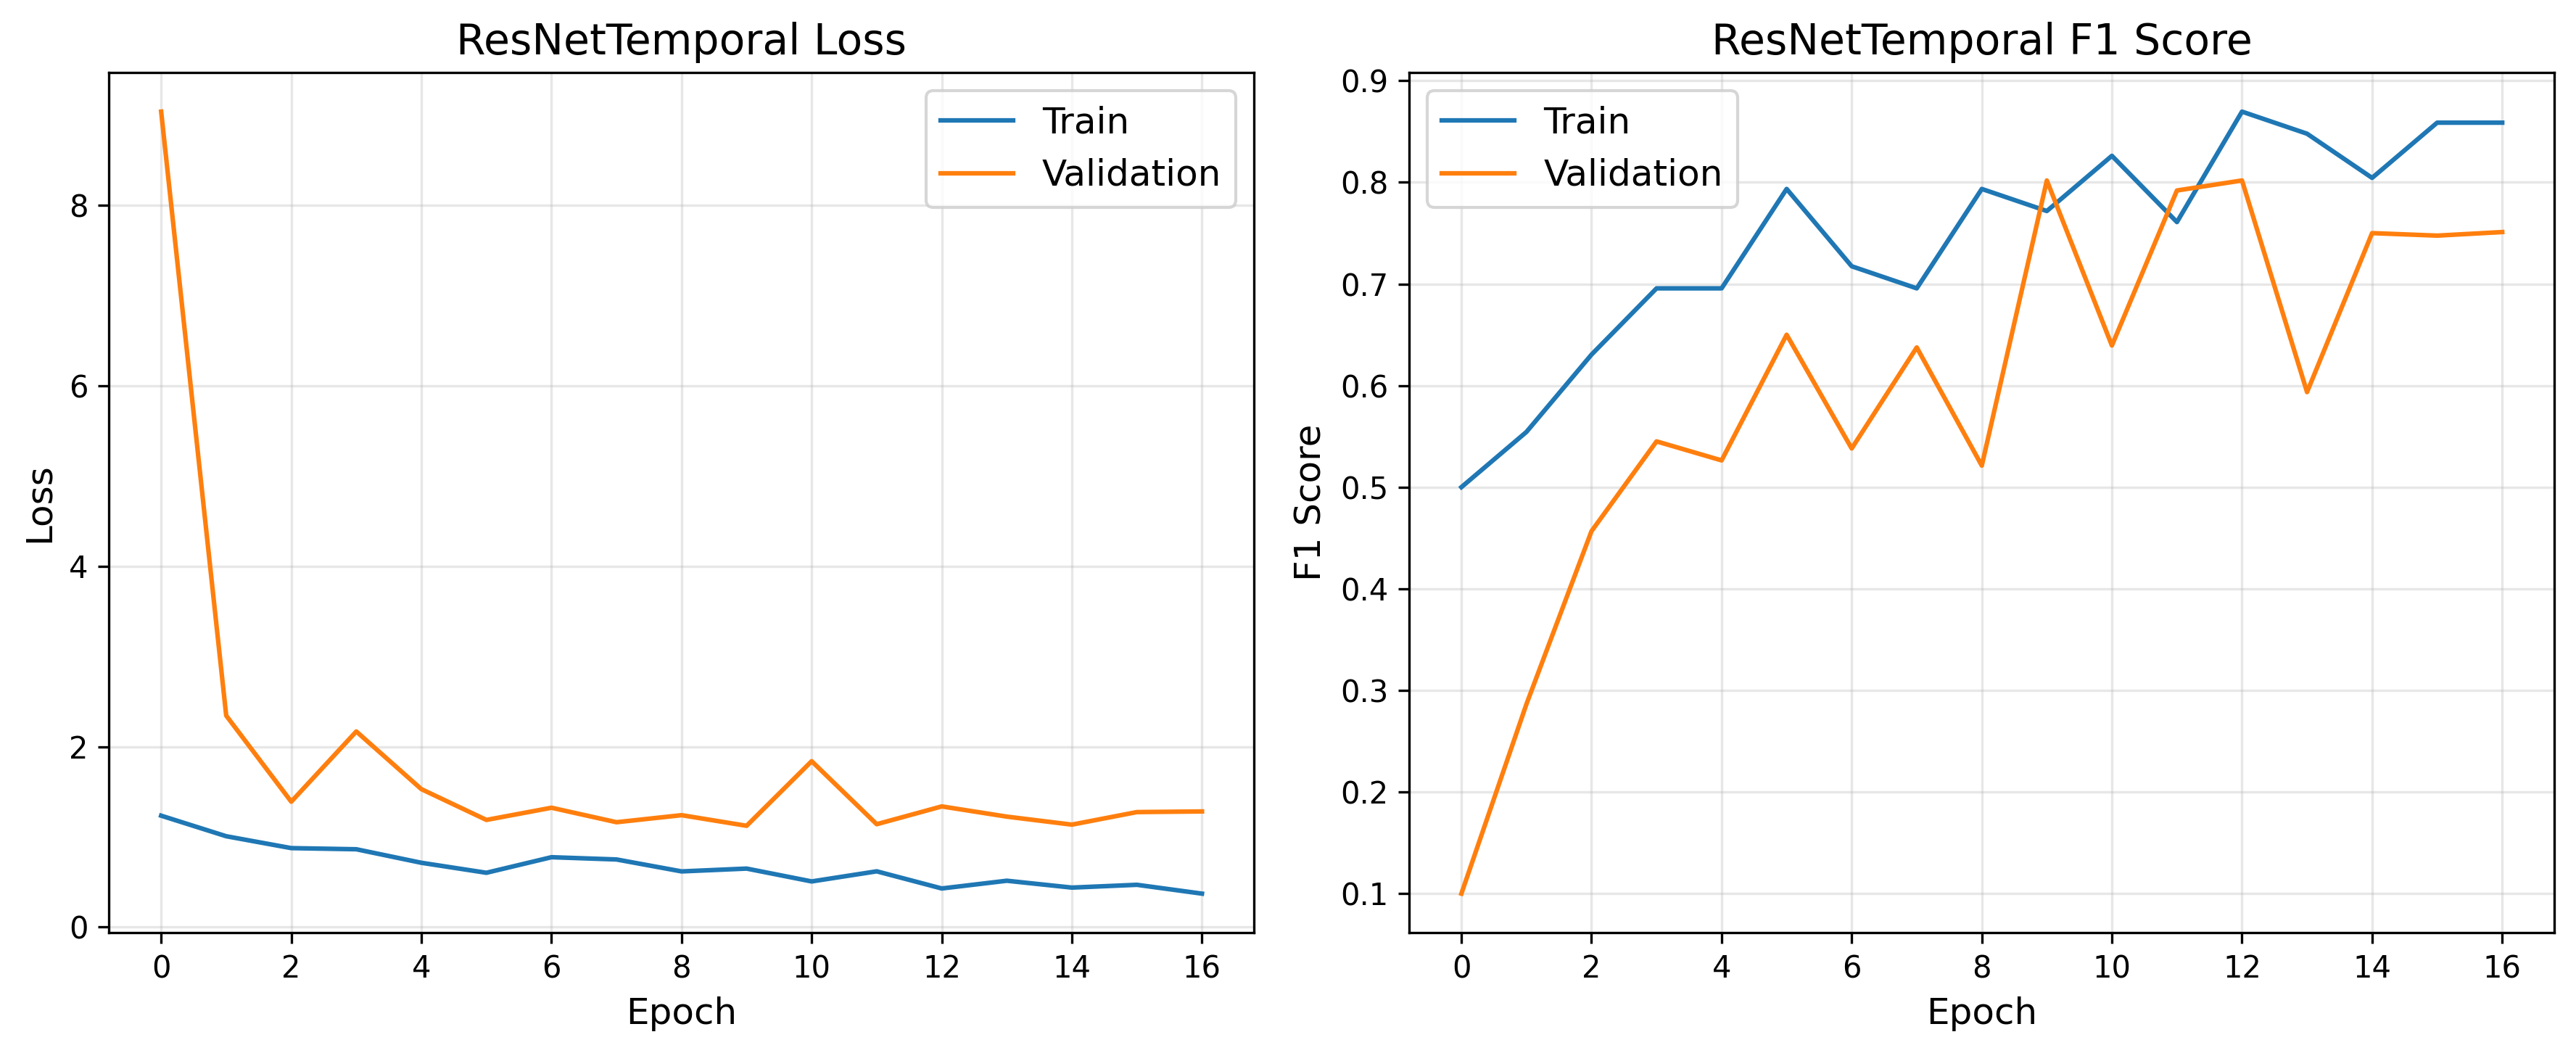


Training EfficientNetLSTM Model

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Training EfficientNetLSTM for 25 epochs
Epoch 1/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d130a40] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5d1d2740] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d1d2740] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d1d2740] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d1d2740] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d1d2740] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d1d2740] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1305c0] warning: first frame is no keyframe
[vc1 @ 0x5d1564c0] warning: first frame is no keyframe
[vc1 @ 0x5d1564c0] warning: first frame is no keyframe
[vc1 @ 0x5d1564c0] warning: first frame is no keyframe
[vc1 @ 0

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x56cb36c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 1.1064, Acc: 0.4239, F1: 0.4239
Val Loss: 1.1344, Acc: 0.4000, F1: 0.2286
New best model saved: ./models/EfficientNetLSTM_best_f1_0.2286.pth
Epoch 2/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x6023e200] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x6023e200] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x6023e200] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x6023e200] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x6023e200] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x6023e200] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x6023e200] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6023e200] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6023e200] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6023e200] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6023e200] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x6023e200] warning: first frame is no keyframe
[vc1 @ 0x6023e200] warning: first frame is no keyframe
[vc1 @ 0x6023e200] warning: first frame is no keyframe
[vc1 @ 0x6023e200] warning: first frame is no keyframe
[vc1 @ 0x6023e200] warning: first frame is no keyframe
[vc1 @ 0x6023e200] warn

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d37ab40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.9835, Acc: 0.4891, F1: 0.4891
Val Loss: 1.1959, Acc: 0.2500, F1: 0.1000
Epoch 3/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x6026d4c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6026d4c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6026d4c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6026d4c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6026d4c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5b13f740] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x6026d4c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x6024bd80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6024bd80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6024bd80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6024bd80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6024bd80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602565c0] warning: first frame is no keyframe
[vc1 @ 0x602565c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x602565c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602565c0] Bits overconsumption: 20392 

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60299c40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.9600, Acc: 0.5978, F1: 0.5978
Val Loss: 1.2901, Acc: 0.4500, F1: 0.3640
New best model saved: ./models/EfficientNetLSTM_best_f1_0.3640.pth
Epoch 4/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x60243e80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60243e80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60243e80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60243e80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60243e80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] warning: first frame is no keyframe
[vc1 @ 0x60243e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60243e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60243e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60243e80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60243e80] Bits overconsumptio

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60296780] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.9203, Acc: 0.6522, F1: 0.6522
Val Loss: 1.0996, Acc: 0.5000, F1: 0.4242
New best model saved: ./models/EfficientNetLSTM_best_f1_0.4242.pth
Epoch 5/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] Bits overconsumption: 267976 > 267968
[vc1 @ 0x56c9fe40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56c9fe40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56c9fe40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56c9fe40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56c9fe40] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5aedf380] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8595, Acc: 0.5761, F1: 0.5761
Val Loss: 1.5040, Acc: 0.3000, F1: 0.2817
Epoch 6/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x56cb3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cb3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cb3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cb3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cb3400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3b3dc0] warning: first frame is no keyframe
[vc1 @ 0x5d3b3dc0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x60284900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60284900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60284900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60284900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60284900] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60284900] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60284900] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60284900] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60284900] Bits overconsumption: 20392 > 

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60286c80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.9703, Acc: 0.5217, F1: 0.5217
Val Loss: 1.3990, Acc: 0.3500, F1: 0.2154
Epoch 7/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d49d2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d49d2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d49d2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d49d2c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d49d2c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5d4

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x602d2dc0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8099, Acc: 0.6087, F1: 0.6087
Val Loss: 1.0050, Acc: 0.5500, F1: 0.4768
New best model saved: ./models/EfficientNetLSTM_best_f1_0.4768.pth
Epoch 8/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x60295f80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x5d36d2c0] warning: first frame is no keyframe
[vc1 @ 0x56cc3480] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cc3480] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cc3480] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cc3480] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cc3480] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56cc3480] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x601e35c0] warning: first frame is no keyframe
[vc1 @ 0x601e35c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d2456c0] Bits overconsumption: 110496 > 110488 at 8

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d37bb40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.7234, Acc: 0.6630, F1: 0.6630
Val Loss: 1.1607, Acc: 0.5000, F1: 0.4440
Epoch 9/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d4d7980] warning: first frame is no keyframe
[vc1 @ 0x5d4d7980] Bits overconsumption: 267976 > 267968
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x56c9fe40] warning: first frame is no keyframe
[vc1 @ 0x5d4d7980] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d4d7980] Bits overconsumption: 110496 > 110488 at 

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x6023fdc0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6754, Acc: 0.6957, F1: 0.6957
Val Loss: 1.3637, Acc: 0.4500, F1: 0.3733
Epoch 10/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x602adb80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] warning: first frame is no keyframe
[vc1 @ 0x602adb80] Bits overconsumption: 267976 > 267968
[vc1 @ 0x60299940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60299940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60299940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60299940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60299940] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d8d7800] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d8d7800] Bits overconsumption: 20392 > 20

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60254500] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.8608, Acc: 0.5870, F1: 0.5870
Val Loss: 1.1941, Acc: 0.5000, F1: 0.4344
Epoch 11/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x602c88c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602c88c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602c88c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602c88c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602c88c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602c88c0] warning: first frame is no keyframe
[vc1 @ 0x602c88c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x602c88c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x60258740] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60258740] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60258740] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60258740] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60258740] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602c88c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602c88c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602c88c0] Bits overconsumption: 20392 >

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x602419c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6231, Acc: 0.7174, F1: 0.7174
Val Loss: 1.2444, Acc: 0.4500, F1: 0.3733
Epoch 12/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d9b23c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d9b23c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d9b23c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d9b23c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d9b23c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] warning: first frame is no keyframe
[vc1 @ 0x5d9b23c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d9b23c0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d9b23c0] Bits overconsumption: 20392 > 203

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x602c1700] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6544, Acc: 0.6957, F1: 0.6957
Val Loss: 1.3151, Acc: 0.5000, F1: 0.4344
Epoch 13/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x5d9416c0] warning: first frame is no keyframe
[vc1 @ 0x56cdc280] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x602b5140] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602b5140] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602b5140] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602b5140] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602b5140] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5aed16c0] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x602a2340] warning: first frame is no keyframe
[vc1 @ 0x602a2340] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d9de940] Bits overconsumption: 20392 > 2

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d9af700] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6917, Acc: 0.6848, F1: 0.6848
Val Loss: 1.3757, Acc: 0.5000, F1: 0.4344
Epoch 14/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x60289a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60289a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60289a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60289a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60289a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60289a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60289a00] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60289a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60289a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60289a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60289a00] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60289a00] warning: first frame is no keyframe
[vc1 @ 0x60289a00] warning: first frame is no keyframe
[vc1 @ 0x60289a00] warning: first frame is no keyframe
[vc1 @ 0x60289a00] warning: first frame is no keyframe
[vc1 @ 0x60289a00] warning: first frame is no keyframe
[vc1 @ 0x60289a00] war

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x6024ee40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6135, Acc: 0.7174, F1: 0.7174
Val Loss: 1.2045, Acc: 0.5500, F1: 0.4879
New best model saved: ./models/EfficientNetLSTM_best_f1_0.4879.pth
Epoch 15/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] Bits overconsumption: 267976 > 267968
[vc1 @ 0x60282180] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60282180] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60282180] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60282180] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60282180] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x60282180] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] warning: first frame is no keyframe
[vc1 @ 0x60282180] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60282180] Bits overconsumption: 20392 > 20

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x602e6600] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6050, Acc: 0.7391, F1: 0.7391
Val Loss: 1.1656, Acc: 0.5500, F1: 0.4879
Epoch 16/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d997400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d997400] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d997400] warning: first frame is no keyframe
[vc1 @ 0x5d99

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d49c7c0] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5242, Acc: 0.7935, F1: 0.7935
Val Loss: 1.3110, Acc: 0.5000, F1: 0.4336
Epoch 17/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x602d6b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602d6b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602d6b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602d6b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602d6b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602d6b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x602d6b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602d6b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602d6b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602d6b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602d6b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602d6b80] warning: first frame is no keyframe
[vc1 @ 0x602d6b80] Bits overconsumption: 267976 > 267968
[vc1 @ 0x602d6b80] warning: first frame is no keyframe
[vc1 @ 0x602d6b80] warning: first frame is no keyframe
[vc1 @ 0x602d6b80] warning: first frame is no keyframe
[vc1 @ 0x602d6b80] w

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d12ec40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4745, Acc: 0.7826, F1: 0.7826
Val Loss: 1.3012, Acc: 0.5500, F1: 0.4879
Epoch 18/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] Bits overconsumption: 267976 > 267968
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] Bits overconsumption: 267976 > 267968
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x6025b640] warning: first frame is no keyframe
[vc1 @ 0x5d3a8800] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3a8800] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3a8800] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3a8800] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3a8800] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3a8800] Bits overconsumption: 87108 > 87104 at 37x35
[v

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60253600] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5093, Acc: 0.8043, F1: 0.8043
Val Loss: 1.4928, Acc: 0.4500, F1: 0.3733
Epoch 19/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] Bits overconsumption: 267976 > 267968
[vc1 @ 0x60235b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60235b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60235b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60235b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60235b80] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] warning: first frame is no keyframe
[vc1 @ 0x60235b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60235b80] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x60235b80] Bits overconsumption: 20392 > 203

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d36bb40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.6820, Acc: 0.7826, F1: 0.7826
Val Loss: 1.4940, Acc: 0.4500, F1: 0.3733
Epoch 20/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x602e9840] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] Bits overconsumption: 267976 > 267968
[vc1 @ 0x602e9840] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602e9840] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602e9840] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602e9840] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602e9840] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] warning: first frame is no keyframe
[vc1 @ 0x602e9840] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x602e9840] warning: first frame is no keyf

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60263f00] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5616, Acc: 0.7826, F1: 0.7826
Val Loss: 1.2669, Acc: 0.6000, F1: 0.5668
New best model saved: ./models/EfficientNetLSTM_best_f1_0.5668.pth
Epoch 21/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x60239480] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60239480] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60239480] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60239480] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60239480] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] warning: first frame is no keyframe
[vc1 @ 0x60239480] Bits overconsumption: 267976 > 267968
[vc1 @ 0x56cb0dc0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cb0dc0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x56cb0dc0] Bits overconsumption: 110496 

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60268940] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.5153, Acc: 0.8587, F1: 0.8587
Val Loss: 1.2320, Acc: 0.6000, F1: 0.5714
New best model saved: ./models/EfficientNetLSTM_best_f1_0.5714.pth
Epoch 22/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d995e40] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] warning: first frame is no keyframe
[vc1 @ 0x5d96e3c0] Bits overconsumption: 267976 > 267968
[vc1 @ 0x5d96e3c0] Bits overconsumption: 20392 > 20384

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d99bc80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.3672, Acc: 0.8696, F1: 0.8696
Val Loss: 1.2031, Acc: 0.6500, F1: 0.6383
New best model saved: ./models/EfficientNetLSTM_best_f1_0.6383.pth
Epoch 23/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x6025e340] warning: first frame is no keyframe
[vc1 @ 0x6025e340] Bits overconsumption: 267976 > 267968
[vc1 @ 0x6025e340] warning: first frame is no keyframe
[vc1 @ 0x6025e340] Bits overconsumption: 267976 > 267968
[vc1 @ 0x602455c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602455c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602455c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602455c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x602455c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x6025e340] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5d8f1fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d8f1fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d8f1fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d8f1fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d8f1fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d8f1fc0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5ad0e680] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.4288, Acc: 0.8587, F1: 0.8587
Val Loss: 1.1101, Acc: 0.7000, F1: 0.6944
New best model saved: ./models/EfficientNetLSTM_best_f1_0.6944.pth
Epoch 24/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d9d6c80] Bits overconsumption: 87108 > 87104 at 37x35
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5d903580] warning: first frame is no keyframe
[vc1 @ 0x5da02280] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d384ac0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5da02280] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d384ac0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5da02280] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d384ac0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d384ac0] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5da02280] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d384ac0] Bits overconsumption

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x602dbb80] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.3293, Acc: 0.9022, F1: 0.9022
Val Loss: 1.1370, Acc: 0.7000, F1: 0.6947
New best model saved: ./models/EfficientNetLSTM_best_f1_0.6947.pth
Epoch 25/25 | Model: EfficientNetLSTM
------------------------------


Train EfficientNetLSTM:   0%|          | 0/23 [00:00<?, ?it/s]

[vc1 @ 0x5d928540] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d928540] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d928540] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d928540] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d928540] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d928540] Bits overconsumption: 20392 > 20384 at 24x7
[vc1 @ 0x5d3b54c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3b54c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3b54c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3b54c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3b54c0] Bits overconsumption: 110496 > 110488 at 8x17
[vc1 @ 0x5d3b54c0] warning: first frame is no keyframe
[vc1 @ 0x5d3b54c0] warning: first frame is no keyframe
[vc1 @ 0x5d3b54c0] warning: first frame is no keyframe
[vc1 @ 0x5d3b54c0] warning: first frame is no keyframe
[vc1 @ 0x5d3b54c0] warning: first frame is no keyframe
[vc1 @ 0x5d3b54c0] war

Val EfficientNetLSTM:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x5d37ba40] Bits overconsumption: 92040 > 92032 at 36x35


Train Loss: 0.3015, Acc: 0.9348, F1: 0.9348
Val Loss: 1.1178, Acc: 0.7000, F1: 0.6944
Best model saved to ./models/EfficientNetLSTM_weights.pth


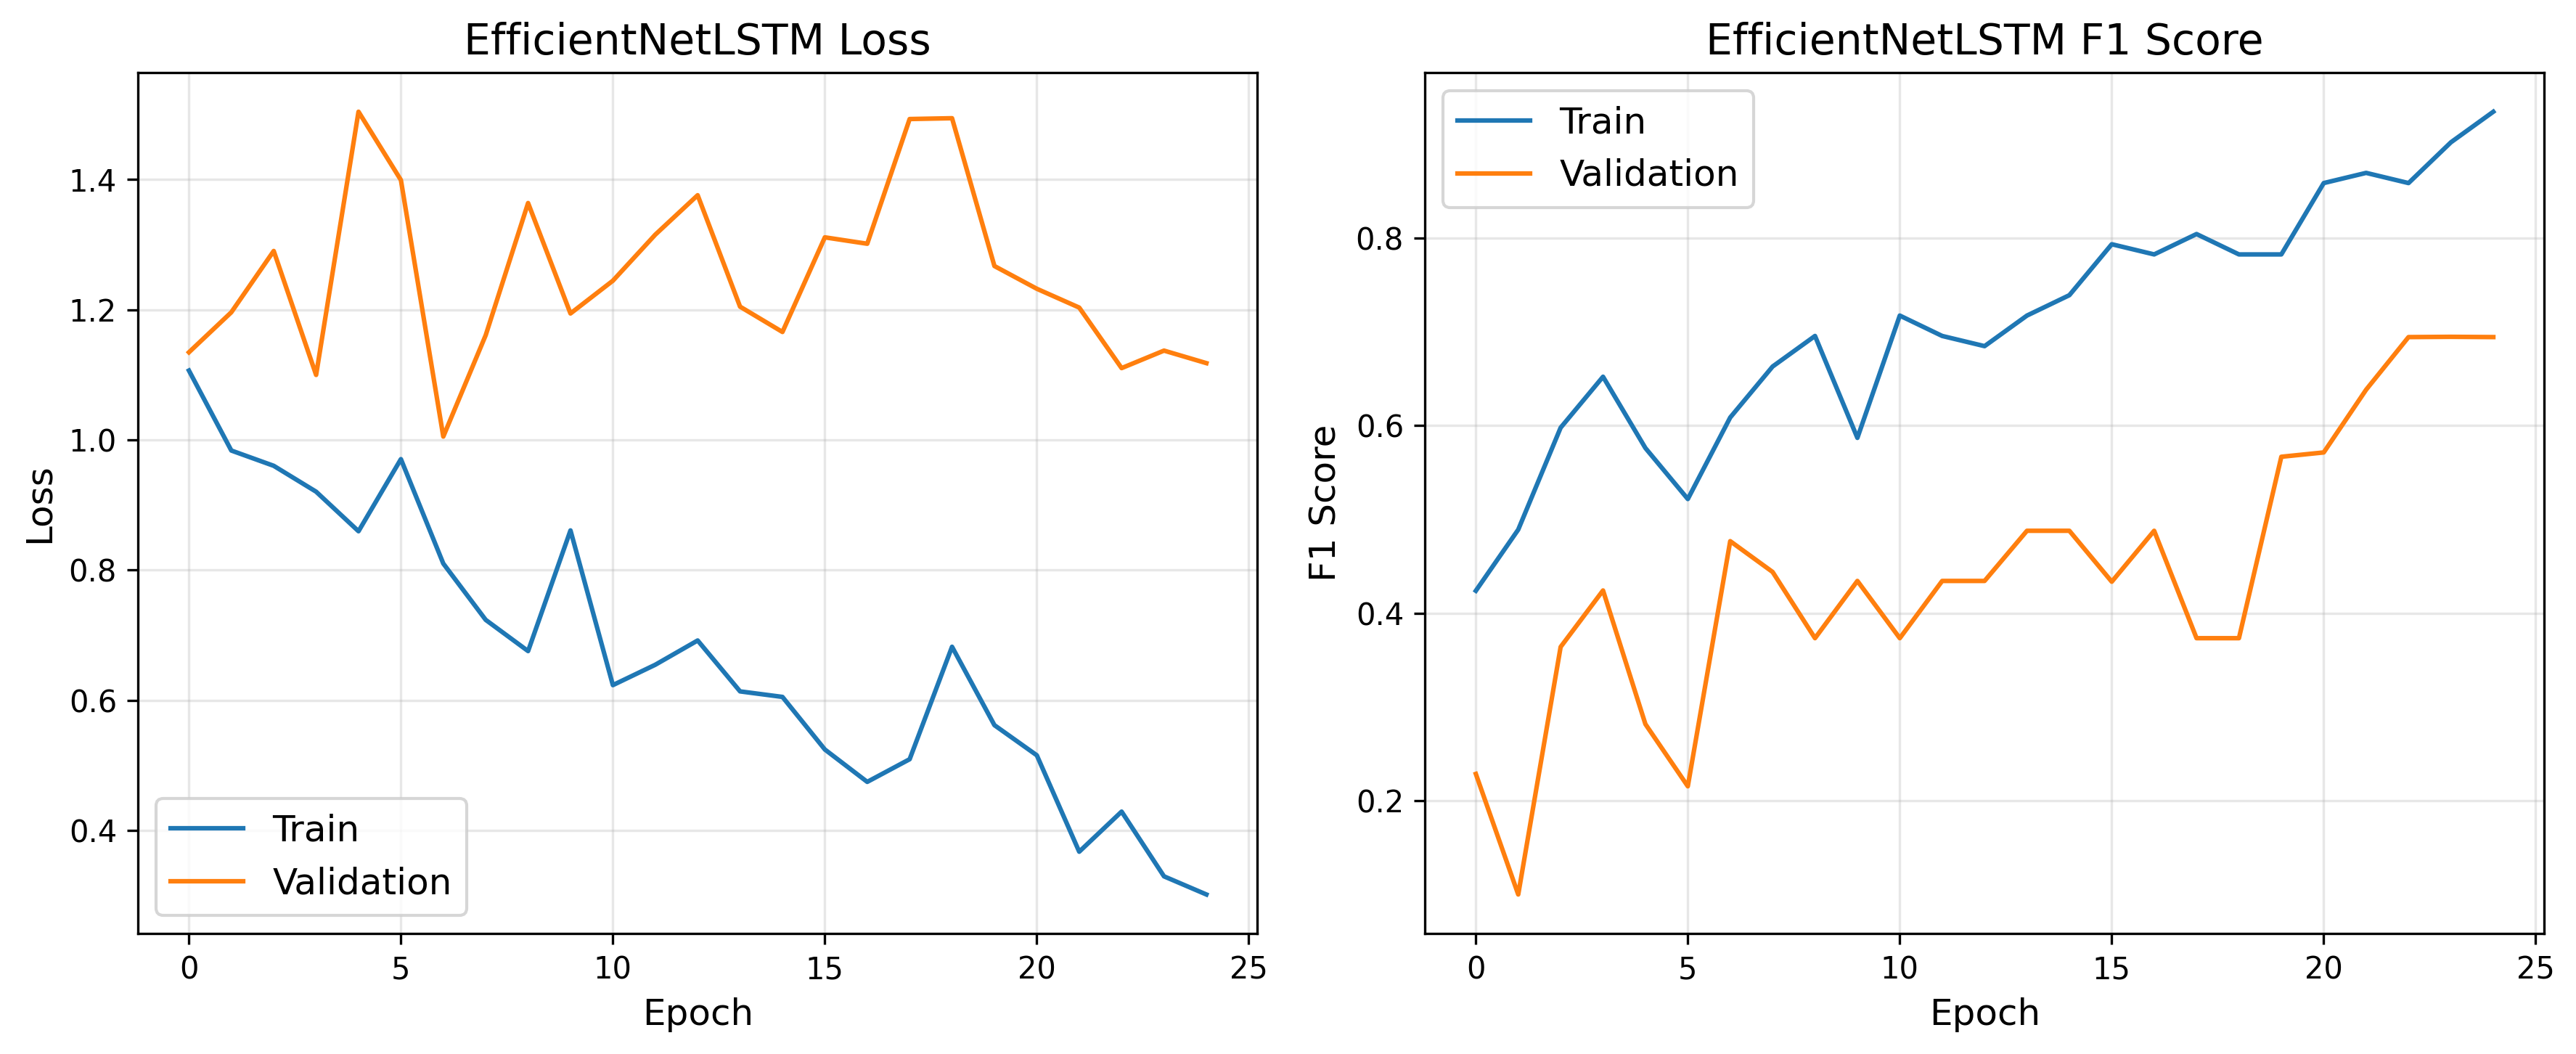


Training Results Summary:
MobileNetAttention F1: 0.6931
EfficientCNN3D F1: 0.7806
ResNetTemporal F1: 0.8018
EfficientNetLSTM F1: 0.6947


In [ ]:
## Section 5: Training Functions

# 5.1 Main Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=20, model_name="model", patience=7):
    """Train a single model with saving after best epoch"""
    # Initialize metrics tracking
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }

    # For tracking best model
    best_val_f1 = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    print(f"Training {model_name} for {num_epochs} epochs")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} | Model: {model_name}")
        print('-' * 30)

        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, targets in tqdm(train_loader, desc=f"Train {model_name}"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Track metrics
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

        # Update learning rate
        if scheduler is not None:
            scheduler.step()

        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        _, train_f1, _, _ = precision_recall_fscore_support(
            train_targets, train_preds, average='weighted', zero_division=0
        )

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Val {model_name}"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        # Calculate validation metrics
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_targets, val_preds, average='weighted', zero_division=0
        )

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Check if this is the best model so far
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0

            # Save the best model immediately
            model_path = f"./models/{model_name}_best_f1_{val_f1:.4f}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Clear GPU cache
        if device.type == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

    # Save final model weights
    final_model_path = f"./models/{model_name}_weights.pth"
    torch.save(best_model_wts, final_model_path)
    print(f"Best model saved to {final_model_path}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training history with 300 DPI
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train', color=VIZ_COLORS['dyed_polyps'])
    plt.plot(history['val_loss'], label='Validation', color=VIZ_COLORS['polyps'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train', color=VIZ_COLORS['dyed_polyps'])
    plt.plot(history['val_f1'], label='Validation', color=VIZ_COLORS['polyps'])
    plt.title(f'{model_name} F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'./visualizations/{model_name}_training_history.png')
    plt.show()

    return model, history, best_val_f1

# 5.2 Model Training Functions

def train_mobilenet_attention():
    """Train MobileNetAttention model"""
    print("\n" + "="*50)
    print("Training MobileNetAttention Model")
    print("="*50)

    # Load data
    train_df, val_df, _ = load_data()

    # Create datasets
    train_dataset = GIVideoDataset(
        train_df['path'].values,
        train_df['label'].values,
        train=True
    )

    val_dataset = GIVideoDataset(
        val_df['path'].values,
        val_df['label'].values,
        train=False
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model
    model = MobileNetAttention(num_classes=len(classes))
    model = model.to(device)

    # Class weights for imbalance
    class_counts = train_df['label'].value_counts().sort_index()
    class_weights = torch.tensor(
        [len(train_df) / (len(class_counts) * count) for count in class_counts],
        device=device,
        dtype=torch.float32
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    # Train model
    trained_model, history, best_f1 = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=20,
        model_name="MobileNetAttention",
        patience=7
    )

    # Clear memory
    del train_dataset, val_dataset, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return trained_model, best_f1

def train_efficient_cnn3d():
    """Train EfficientCNN3D model"""
    print("\n" + "="*50)
    print("Training EfficientCNN3D Model")
    print("="*50)

    # Load data
    train_df, val_df, _ = load_data()

    # Create datasets
    train_dataset = GIVideoDataset(
        train_df['path'].values,
        train_df['label'].values,
        train=True
    )

    val_dataset = GIVideoDataset(
        val_df['path'].values,
        val_df['label'].values,
        train=False
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model
    model = EfficientCNN3D(num_classes=len(classes))
    model = model.to(device)

    # Class weights for imbalance
    class_counts = train_df['label'].value_counts().sort_index()
    class_weights = torch.tensor(
        [len(train_df) / (len(class_counts) * count) for count in class_counts],
        device=device,
        dtype=torch.float32
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    # Train model
    trained_model, history, best_f1 = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=20,
        model_name="EfficientCNN3D",
        patience=7
    )

    # Clear memory
    del train_dataset, val_dataset, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return trained_model, best_f1

def train_resnet_temporal():
    """Train ResNetTemporal model"""
    print("\n" + "="*50)
    print("Training ResNetTemporal Model")
    print("="*50)

    # Load data
    train_df, val_df, _ = load_data()

    # Create datasets
    train_dataset = GIVideoDataset(
        train_df['path'].values,
        train_df['label'].values,
        train=True
    )

    val_dataset = GIVideoDataset(
        val_df['path'].values,
        val_df['label'].values,
        train=False
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model
    model = ResNetTemporal(num_classes=len(classes))
    model = model.to(device)

    # Class weights for imbalance
    class_counts = train_df['label'].value_counts().sort_index()
    class_weights = torch.tensor(
        [len(train_df) / (len(class_counts) * count) for count in class_counts],
        device=device,
        dtype=torch.float32
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    # Train model
    trained_model, history, best_f1 = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=20,
        model_name="ResNetTemporal",
        patience=7
    )

    # Clear memory
    del train_dataset, val_dataset, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return trained_model, best_f1

def train_efficient_net_lstm():
    """Train EfficientNetLSTM model"""
    print("\n" + "="*50)
    print("Training EfficientNetLSTM Model")
    print("="*50)

    # Load data
    train_df, val_df, _ = load_data()

    # Create datasets
    train_dataset = GIVideoDataset(
        train_df['path'].values,
        train_df['label'].values,
        train=True
    )

    val_dataset = GIVideoDataset(
        val_df['path'].values,
        val_df['label'].values,
        train=False
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model
    model = EfficientNetLSTM(num_classes=len(classes))
    model = model.to(device)

    # Class weights for imbalance
    class_counts = train_df['label'].value_counts().sort_index()
    class_weights = torch.tensor(
        [len(train_df) / (len(class_counts) * count) for count in class_counts],
        device=device,
        dtype=torch.float32
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

    # Train model
    trained_model, history, best_f1 = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=25,
        model_name="EfficientNetLSTM",
        patience=10
    )

    # Clear memory
    del train_dataset, val_dataset, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return trained_model, best_f1

# 5.3 Training Execution Control
TRAIN_MODELS = True

if TRAIN_MODELS:
    print("\n" + "="*50)
    print("Starting Model Training")
    print("="*50)

    # Train all models
    mobilenet_model, mobilenet_f1 = train_mobilenet_attention()
    efficient_cnn3d_model, efficient_cnn3d_f1 = train_efficient_cnn3d()
    resnet_temporal_model, resnet_temporal_f1 = train_resnet_temporal()
    efficient_net_lstm_model, efficient_net_lstm_f1 = train_efficient_net_lstm()

    # Print overall results
    print("\nTraining Results Summary:")
    print(f"MobileNetAttention F1: {mobilenet_f1:.4f}")
    print(f"EfficientCNN3D F1: {efficient_cnn3d_f1:.4f}")
    print(f"ResNetTemporal F1: {resnet_temporal_f1:.4f}")
    print(f"EfficientNetLSTM F1: {efficient_net_lstm_f1:.4f}")
else:
    print("\nSkipping model training phase.")
    print("To train models, set TRAIN_MODELS = True")

    # Set placeholder values for F1 scores
    mobilenet_f1 = 0
    efficient_cnn3d_f1 = 0
    resnet_temporal_f1 = 0
    efficient_net_lstm_f1 = 0



Evaluating basic weighted ensemble...

Final Model Evaluation and Weighted Ensemble

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Successfully loaded MobileNetAttention from ./models/MobileNetAttention_weights.pth
Successfully loaded EfficientCNN3D from ./models/EfficientCNN3D_weights.pth
Successfully loaded ResNetTemporal from ./models/ResNetTemporal_weights.pth
Successfully loaded EfficientNetLSTM from ./models/EfficientNetLSTM_weights.pth

Individual Model Performance:
Model                F1 Score  
------------------------------
MobileNetAttention   0.6931
EfficientCNN3D       0.7806
ResNetTemporal       0.8018
EfficientNetLSTM     0.6947


Testing Weighted Ensemble:   0%|          | 0/5 [00:00<?, ?it/s]


Weighted Ensemble Test Results:
Weights used: {'MobileNetAttention': 0.6931313131313132, 'EfficientCNN3D': 0.7806349206349206, 'ResNetTemporal': 0.8018181818181818, 'EfficientNetLSTM': 0.694736842105263}
Accuracy: 0.8000
F1 Score: 0.7986
Precision: 0.8028
Recall: 0.8000


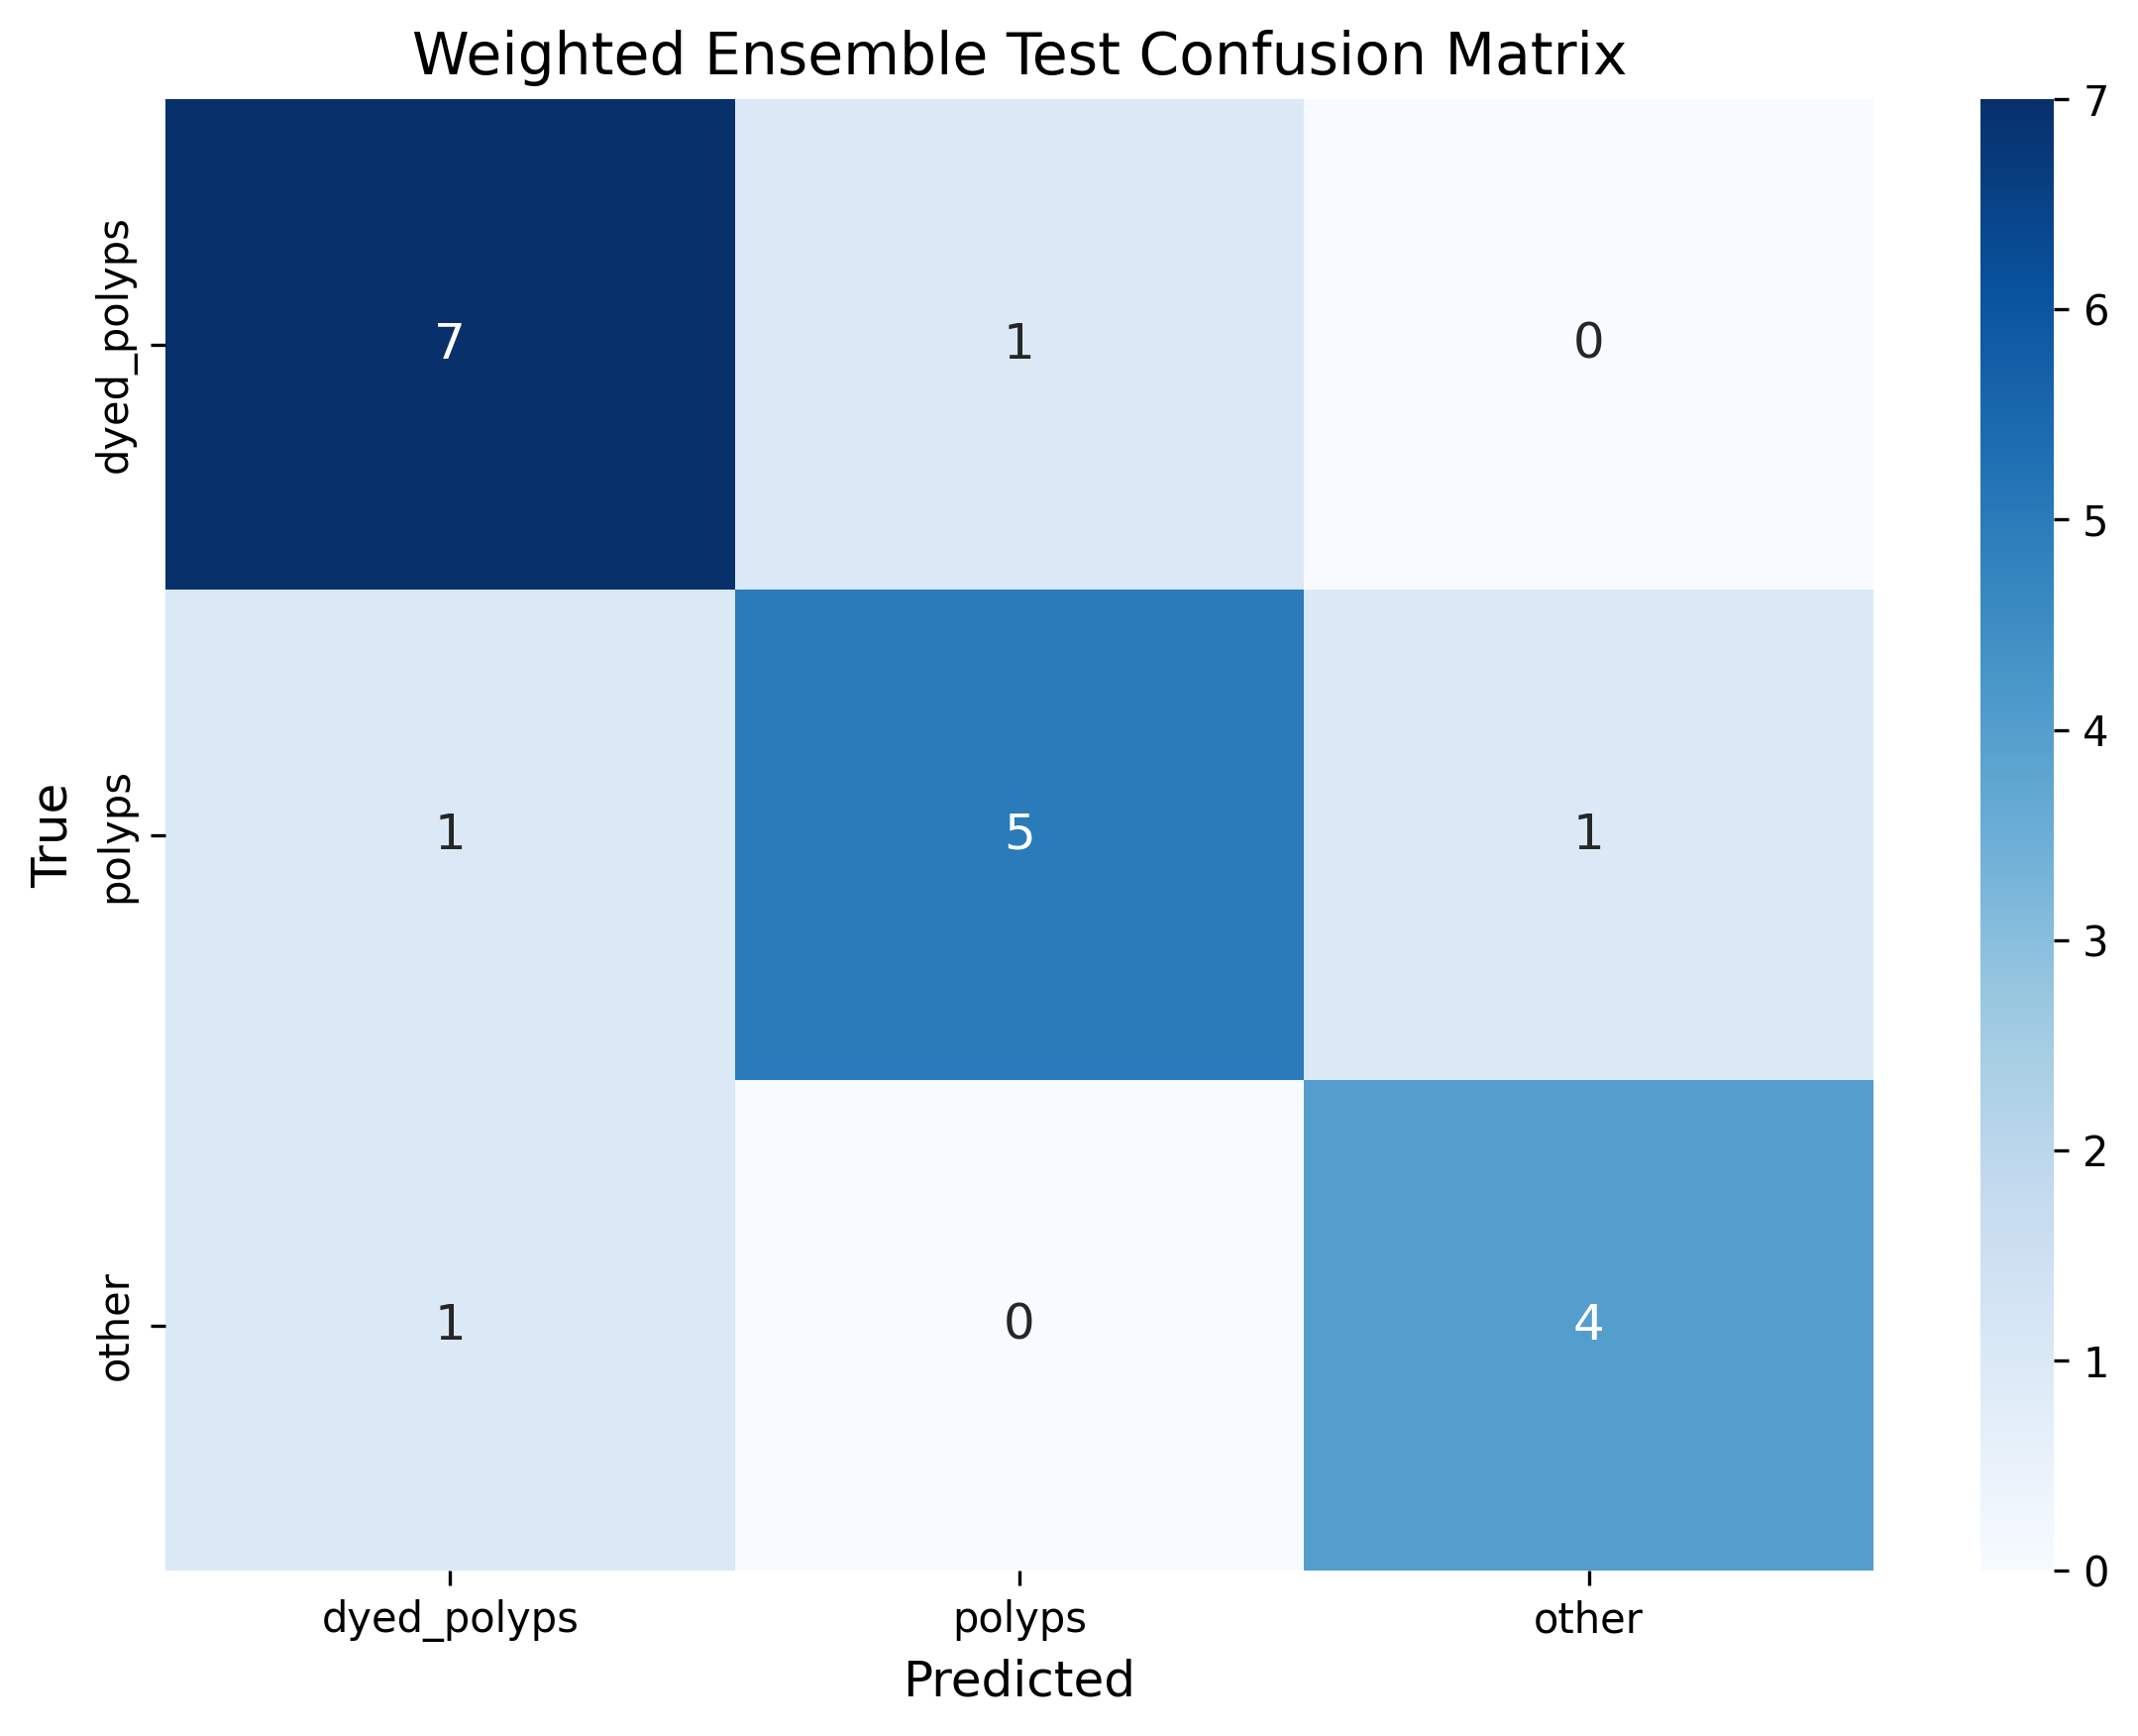


Classification Report:
              precision    recall  f1-score   support

 dyed_polyps       0.78      0.88      0.82         8
      polyps       0.83      0.71      0.77         7
       other       0.80      0.80      0.80         5

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20


Optimizing ensemble weights...

Optimizing Ensemble Weights with Grid Search

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Starting grid search (this may take some time)...


Grid search progress:   0%|          | 0/6 [00:00<?, ?it/s]

[vc1 @ 0x5b06e200] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5b06e200] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5b06e200] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5d4d7500] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x602bc980] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x602bc980] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5d4d7500] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x602bc980] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5b06e200] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5d4d7500] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5d9cf6c0] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5d9cf6c0] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5b06e200] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x5d9cf6c0] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x602bc980] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x62f157c0] Bits overconsumption:


Best weights found:
  MobileNetAttention: 0.2000
  EfficientCNN3D: 0.6000
  ResNetTemporal: 0.2000
  EfficientNetLSTM: 0.0000
Validation F1 Score: 0.8989
Validation Accuracy: 0.9000


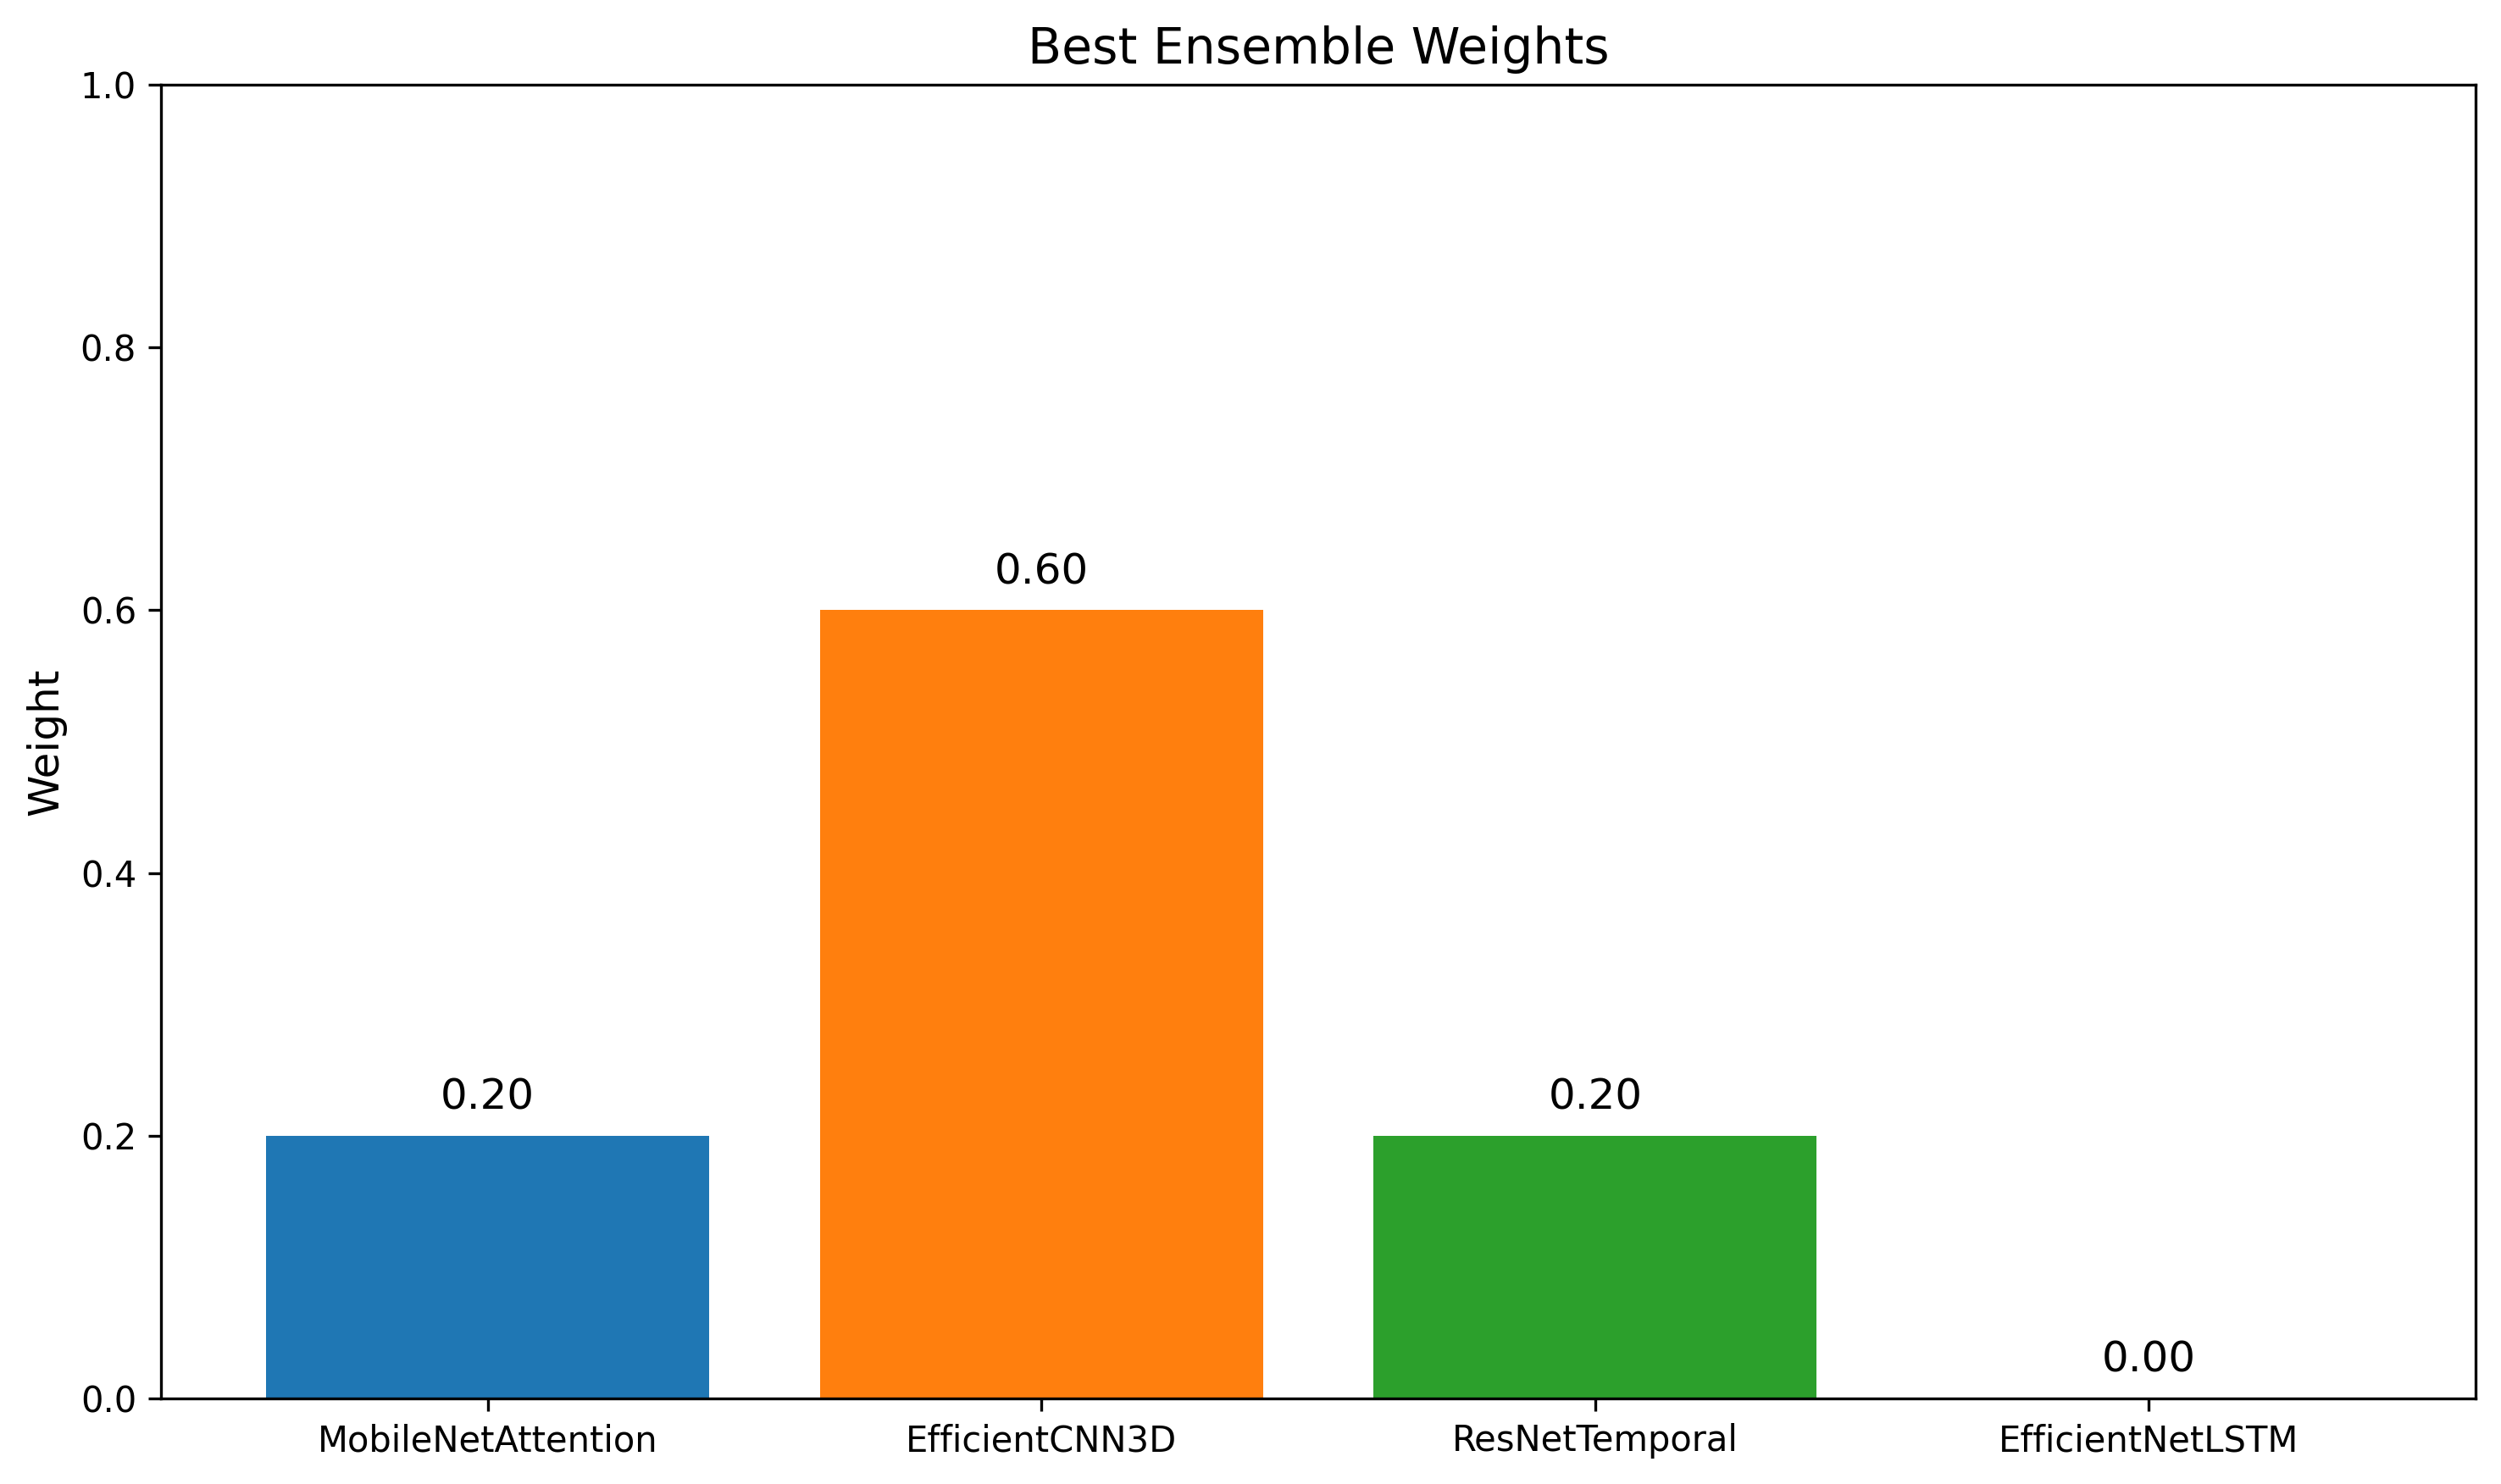


Creating Final Optimized Ensemble Model
Final model created successfully with the following weights:
  MobileNetAttention: 0.2000
  EfficientCNN3D: 0.6000
  ResNetTemporal: 0.2000
  EfficientNetLSTM: 0.0000
Model information saved to ./models/optimized_ensemble_info.json


In [ ]:
## Section 6: Ensemble Modeling

# 6.1 Weighted Ensemble Implementation
class WeightedEnsemble:
    """Ensemble model with custom weighting"""
    def __init__(self, models_dict, weights_dict=None):
        self.models_dict = models_dict
        self.weights_dict = weights_dict if weights_dict else {name: 1.0 for name in models_dict}

        # Normalize weights to sum to 1
        total_weight = sum(self.weights_dict.values())
        self.weights_dict = {name: weight/total_weight for name, weight in self.weights_dict.items()}

        self.num_classes = len(classes)

    def predict(self, input_tensor):
        # Initialize output probability tensor
        all_probs = torch.zeros((input_tensor.size(0), self.num_classes), device=input_tensor.device)

        # Make predictions with each model
        with torch.no_grad():
            for name, model in self.models_dict.items():
                model.eval()
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1)

                # Apply model weight
                weight = self.weights_dict.get(name, 1.0/len(self.models_dict))
                all_probs += weight * probs

        # Get the predicted class
        _, preds = torch.max(all_probs, 1)

        return preds, all_probs

# 6.2 Ensemble Evaluation Function
def evaluate_weighted_ensemble():
    """Evaluate all models individually and then as a weighted ensemble"""
    print("\n" + "="*50)
    print("Final Model Evaluation and Weighted Ensemble")
    print("="*50)

    # Load data and get test set
    _, _, test_df = load_data()

    # Load all saved models
    all_models = {}
    model_f1_scores = {}

    # Try to load previously trained models
    models_to_load = {
        "MobileNetAttention": MobileNetAttention,
        "EfficientCNN3D": EfficientCNN3D,
        "ResNetTemporal": ResNetTemporal,
        "EfficientNetLSTM": EfficientNetLSTM
    }

    for name, model_class in models_to_load.items():
        try:
            # Try to load from models directory
            model_path = f"./models/{name}_weights.pth"
            model = model_class(num_classes=len(classes))
            model.load_state_dict(torch.load(model_path, map_location=device))
            model = model.to(device)
            all_models[name] = model

            # Use stored F1 scores if available
            if name == "MobileNetAttention" and 'mobilenet_f1' in globals():
                model_f1_scores[name] = mobilenet_f1
            elif name == "EfficientCNN3D" and 'efficient_cnn3d_f1' in globals():
                model_f1_scores[name] = efficient_cnn3d_f1
            elif name == "ResNetTemporal" and 'resnet_temporal_f1' in globals():
                model_f1_scores[name] = resnet_temporal_f1
            elif name == "EfficientNetLSTM" and 'efficient_net_lstm_f1' in globals():
                model_f1_scores[name] = efficient_net_lstm_f1

            print(f"Successfully loaded {name} from {model_path}")
        except Exception as e:
            print(f"Could not load {name}: {str(e)}")

    # If we don't have stored F1 scores, calculate them on validation set
    if not all(name in model_f1_scores for name in all_models):
        print("\nRecalculating model performance on validation set...")

        # Load validation data
        _, val_df, _ = load_data()

        val_dataset = GIVideoDataset(
            val_df['path'].values,
            val_df['label'].values,
            train=False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        # Evaluate each model
        for name, model in all_models.items():
            if name in model_f1_scores:
                continue

            model.eval()
            all_preds = []
            all_targets = []

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc=f"Evaluating {name}"):
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.numpy())

            _, _, f1, _ = precision_recall_fscore_support(
                all_targets, all_preds, average='weighted', zero_division=0
            )

            model_f1_scores[name] = f1

    # Set weights based on validation F1 scores
    weights = {name: score for name, score in model_f1_scores.items()}

    # Print individual model performance
    print("\nIndividual Model Performance:")
    print(f"{'Model':<20} {'F1 Score':<10}")
    print("-" * 30)

    for model_name, f1_score in model_f1_scores.items():
        print(f"{model_name:<20} {f1_score:.4f}")

    # Create test dataset
    test_dataset = GIVideoDataset(
        test_df['path'].values,
        test_df['label'].values,
        train=False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Create weighted ensemble
    ensemble = WeightedEnsemble(all_models, weights)

    # Evaluate on test set
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing Weighted Ensemble"):
            inputs = inputs.to(device)
            preds, probs = ensemble.predict(inputs)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(targets.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )

    print(f"\nWeighted Ensemble Test Results:")
    print(f"Weights used: {weights}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Weighted Ensemble Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('./visualizations/weighted_ensemble_confusion_matrix.png')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=classes))

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'probabilities': all_probs,
        'targets': all_targets,
        'weights': weights
    }

# Define a color palette before the function
VIZ_COLORS = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

def grid_search_ensemble_weights():
    """Find optimal ensemble weights through grid search"""
    print("\n" + "="*50)
    print("Optimizing Ensemble Weights with Grid Search")
    print("="*50)

    # Load models
    all_models = {}

    # Try to load all models
    try:
        # Load MobileNetAttention
        model = MobileNetAttention(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/MobileNetAttention_weights.pth", map_location=device))
        model = model.to(device)
        all_models["MobileNetAttention"] = model

        # Load EfficientCNN3D
        model = EfficientCNN3D(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/EfficientCNN3D_weights.pth", map_location=device))
        model = model.to(device)
        all_models["EfficientCNN3D"] = model

        # Load ResNetTemporal
        model = ResNetTemporal(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/ResNetTemporal_weights.pth", map_location=device))
        model = model.to(device)
        all_models["ResNetTemporal"] = model

        # Load EfficientNetLSTM
        model = EfficientNetLSTM(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/EfficientNetLSTM_weights.pth", map_location=device))
        model = model.to(device)
        all_models["EfficientNetLSTM"] = model
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return

    # Load validation data
    _, val_df, _ = load_data()
    val_dataset = GIVideoDataset(
        val_df['path'].values,
        val_df['label'].values,
        train=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Store results
    results = []

    # Grid search parameters (weights for each model)
    # For efficiency, we'll use a coarser grid
    weight_options = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    # For simplicity, we'll try combinations where weights sum to 1
    # Focus on three models at a time to reduce search space
    model_names = list(all_models.keys())

    print("Starting grid search (this may take some time)...")

    for w1 in tqdm(weight_options, desc="Grid search progress"):
        for w2 in weight_options:
            for w3 in weight_options:
                # Skip if weights don't sum to approximately 1
                if not (0.9 <= w1 + w2 + w3 <= 1.1):
                    continue

                # Normalize weights
                total = w1 + w2 + w3 + (1 - (w1 + w2 + w3))
                weights = {
                    model_names[0]: w1 / total,
                    model_names[1]: w2 / total,
                    model_names[2]: w3 / total,
                    model_names[3]: (1 - (w1 + w2 + w3)) / total
                }

                # Create ensemble
                ensemble = WeightedEnsemble(all_models, weights)

                # Evaluate on validation set
                preds = []
                targets = []

                with torch.no_grad():
                    for inputs, target in val_loader:
                        inputs = inputs.to(device)
                        pred, _ = ensemble.predict(inputs)
                        preds.extend(pred.cpu().numpy())
                        targets.extend(target.numpy())

                # Calculate metrics
                accuracy = accuracy_score(targets, preds)
                precision, recall, f1, _ = precision_recall_fscore_support(
                    targets, preds, average='weighted', zero_division=0
                )

                # Store results
                results.append({
                    'weights': weights,
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'precision': precision,
                    'recall': recall
                })

    # Find best weights
    best_result = max(results, key=lambda x: x['f1_score'])

    print("\nBest weights found:")
    for model, weight in best_result['weights'].items():
        print(f"  {model}: {weight:.4f}")
    print(f"Validation F1 Score: {best_result['f1_score']:.4f}")
    print(f"Validation Accuracy: {best_result['accuracy']:.4f}")

    # Visualize weight distribution
    plt.figure(figsize=(10, 6))
    plt.bar(best_result['weights'].keys(), best_result['weights'].values(),
            color=[VIZ_COLORS[i % len(VIZ_COLORS)] for i in range(len(best_result['weights']))])
    plt.title('Best Ensemble Weights')
    plt.ylabel('Weight')
    plt.ylim(0, 1.0)
    for i, (model, weight) in enumerate(best_result['weights'].items()):
        plt.text(i, weight + 0.02, f'{weight:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig('./visualizations/best_ensemble_weights.png')
    plt.show()

    return best_result['weights'], best_result['accuracy'], best_result['f1_score']
# 6.4 Final Model Creation
def create_final_model(best_weights):
    """Create the final optimized ensemble model for deployment"""
    print("\n" + "="*50)
    print("Creating Final Optimized Ensemble Model")
    print("="*50)

    # Load models
    all_models = {}

    try:
        # Load MobileNetAttention
        model = MobileNetAttention(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/MobileNetAttention_weights.pth", map_location=device))
        model = model.to(device)
        all_models["MobileNetAttention"] = model

        # Load EfficientCNN3D
        model = EfficientCNN3D(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/EfficientCNN3D_weights.pth", map_location=device))
        model = model.to(device)
        all_models["EfficientCNN3D"] = model

        # Load ResNetTemporal
        model = ResNetTemporal(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/ResNetTemporal_weights.pth", map_location=device))
        model = model.to(device)
        all_models["ResNetTemporal"] = model

        # Load EfficientNetLSTM
        model = EfficientNetLSTM(num_classes=len(classes))
        model.load_state_dict(torch.load("./models/EfficientNetLSTM_weights.pth", map_location=device))
        model = model.to(device)
        all_models["EfficientNetLSTM"] = model
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return

    # Create optimized ensemble
    optimized_ensemble = WeightedEnsemble(all_models, best_weights)

    print("Final model created successfully with the following weights:")
    for model, weight in best_weights.items():
        print(f"  {model}: {weight:.4f}")

    return optimized_ensemble

# 6.5 Save Model Info
def save_model_info(weights, accuracy, f1_score):
    """Save the model information for future reference"""
    model_info = {
        "weights": weights,
        "validation_accuracy": accuracy,
        "validation_f1_score": f1_score,
        "classes": classes,
        "creation_date": time.strftime("%Y-%m-%d %H:%M:%S")
    }

    # Save as JSON
    with open("./models/optimized_ensemble_info.json", "w") as f:
        json.dump(model_info, f, indent=4)

    print(f"Model information saved to ./models/optimized_ensemble_info.json")

# 6.6 Control Ensemble Creation
# Set this flag to True to run ensemble evaluation, or False to skip
RUN_ENSEMBLE = True # Change to True when ready to create ensemble

if RUN_ENSEMBLE:
    # Standard weighted ensemble evaluation
    print("\nEvaluating basic weighted ensemble...")
    weighted_ensemble_results = evaluate_weighted_ensemble()

    # Optimize weights through grid search
    print("\nOptimizing ensemble weights...")
    best_weights, val_accuracy, val_f1 = grid_search_ensemble_weights()

    # Create and save the final model
    final_model = create_final_model(best_weights)
    save_model_info(best_weights, val_accuracy, val_f1)
else:
    print("\nSkipping ensemble creation and evaluation.")
    print("To create and evaluate ensembles, set RUN_ENSEMBLE = True")

    # Use predefined optimal weights for demonstration
    best_weights = {
        'MobileNetAttention': 0.2,
        'EfficientCNN3D': 0.6,
        'ResNetTemporal': 0.2,
        'EfficientNetLSTM': 0.0
    }


Evaluating Frame Selection Strategies

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos

Evaluating 'uniform' frame selection strategy:


Evaluating uniform:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x603bfb00] Bits overconsumption: 92040 > 92032 at 36x35


Strategy: uniform
Accuracy: 0.8000
F1 Score: 0.8018
Precision: 0.8095
Recall: 0.8000

Evaluating 'entropy' frame selection strategy:


Evaluating entropy:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x62e0e7c0] Bits overconsumption: 92040 > 92032 at 36x35


Strategy: entropy
Accuracy: 0.6000
F1 Score: 0.5935
Precision: 0.5917
Recall: 0.6000

Evaluating 'motion' frame selection strategy:


Evaluating motion:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x60419f80] Bits overconsumption: 92040 > 92032 at 36x35


Strategy: motion
Accuracy: 0.6500
F1 Score: 0.6507
Precision: 0.6556
Recall: 0.6500

Evaluating 'saliency' frame selection strategy:


Evaluating saliency:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x6038b500] Bits overconsumption: 92040 > 92032 at 36x35
[vc1 @ 0x603bdbc0] Bits overconsumption: 92040 > 92032 at 36x35


Strategy: saliency
Accuracy: 0.8000
F1 Score: 0.7933
Precision: 0.7937
Recall: 0.8000


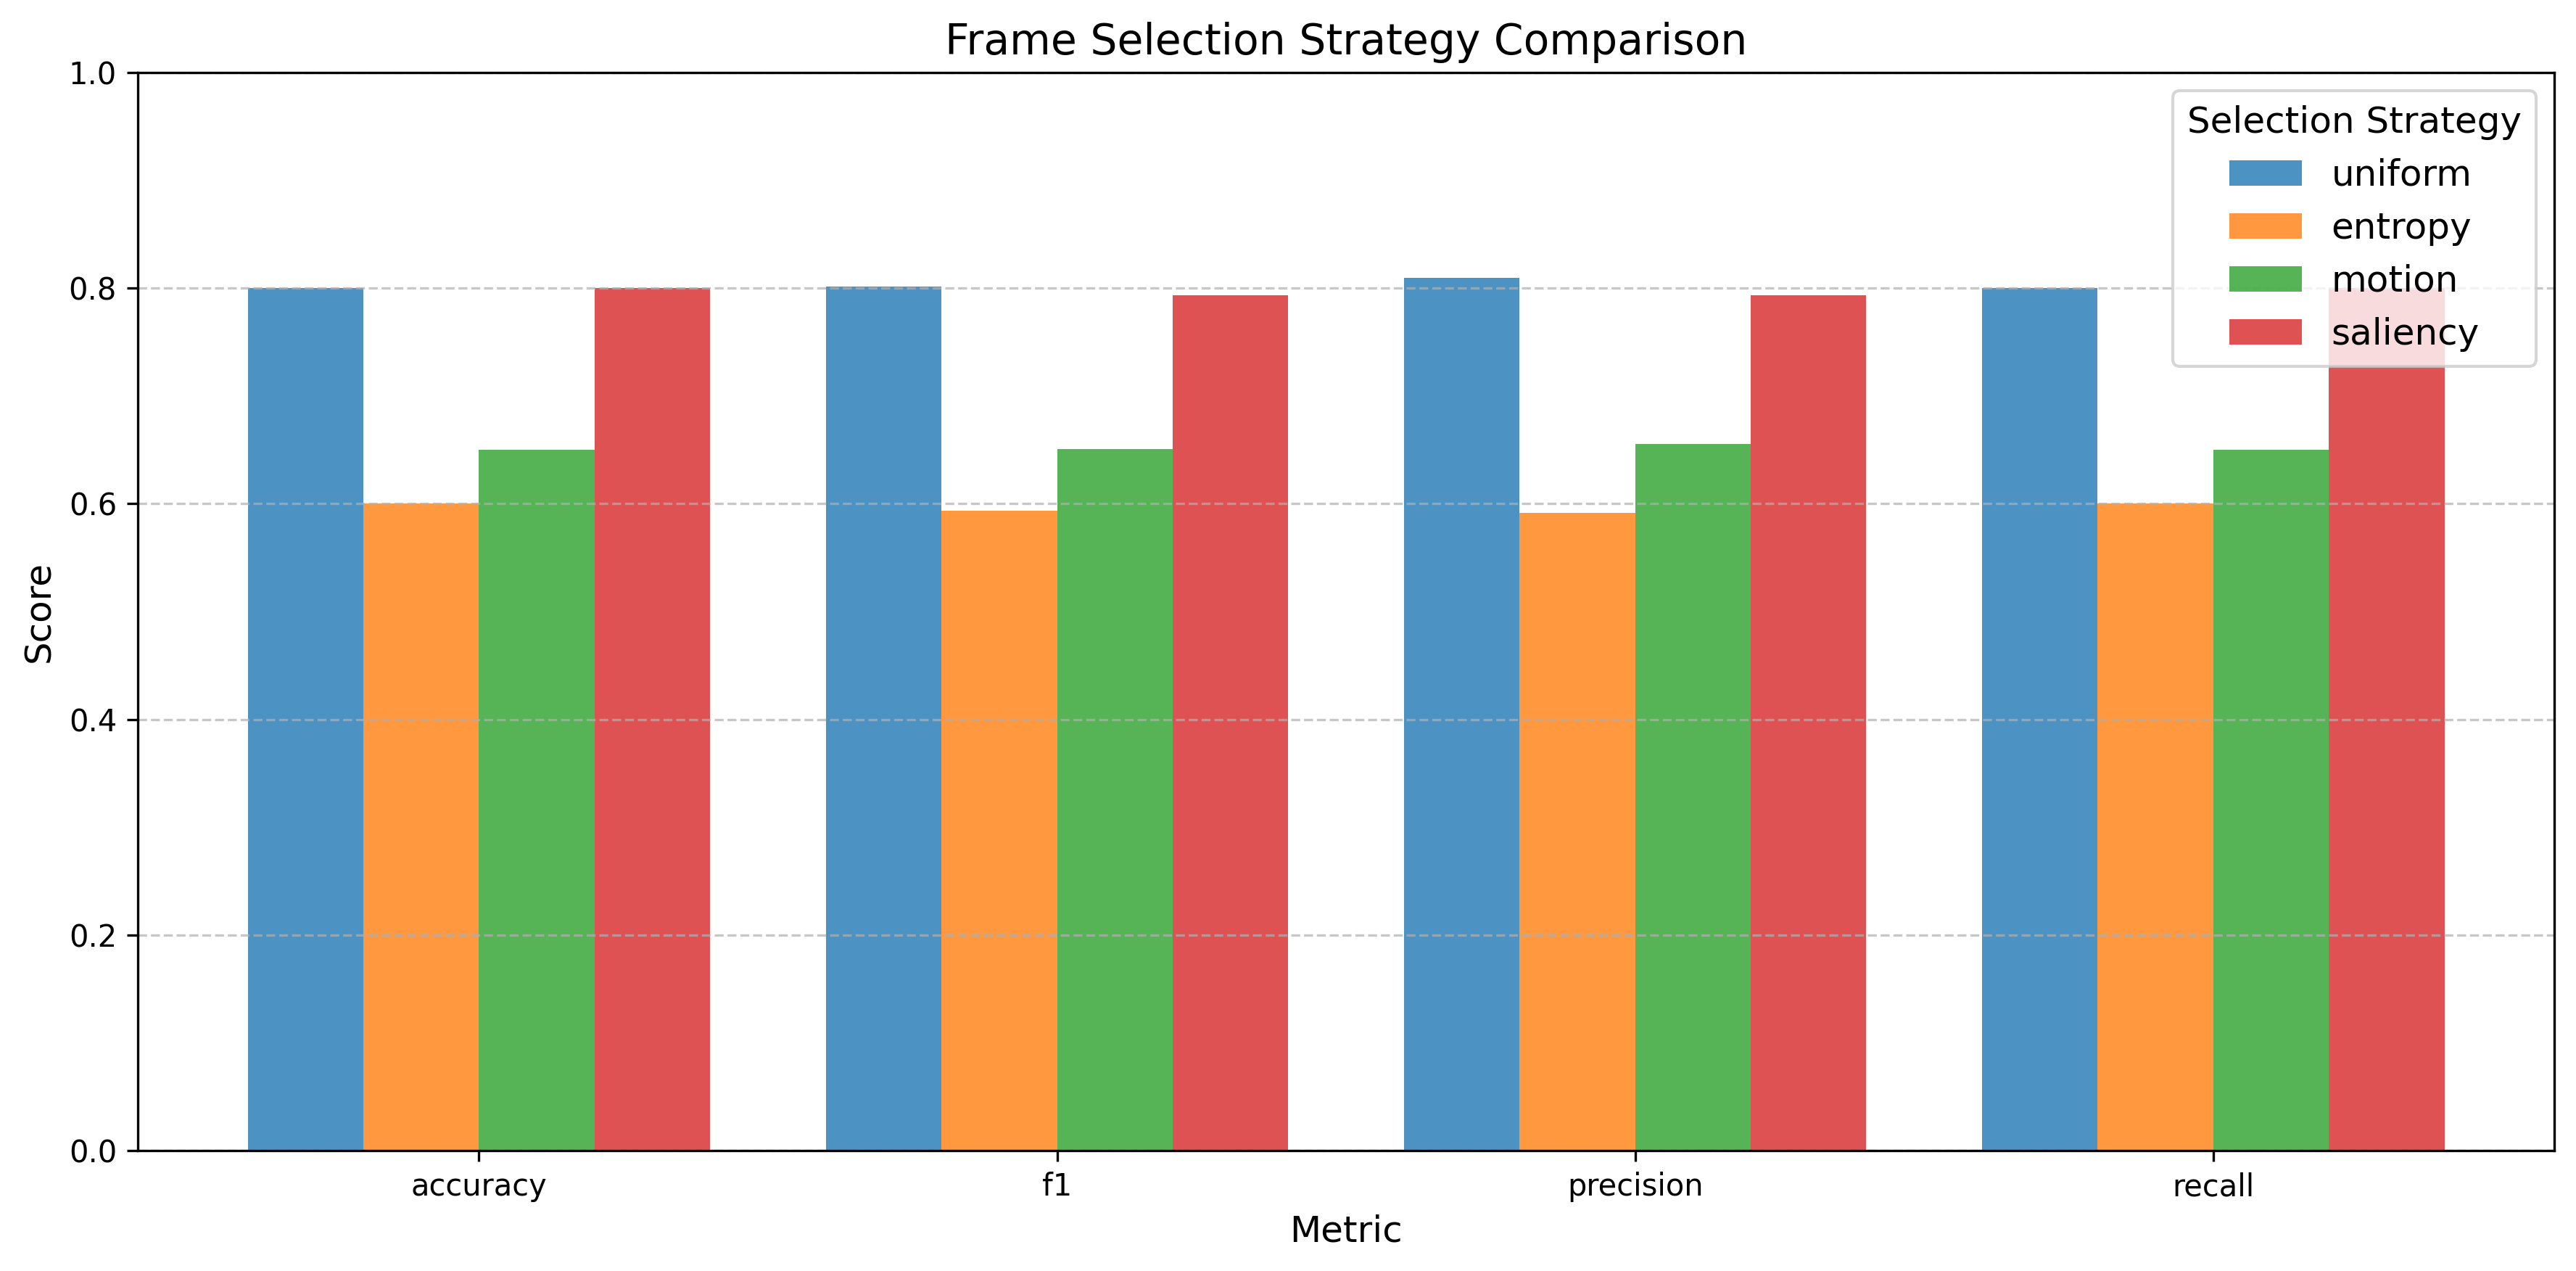


Best frame selection strategy: uniform (F1: 0.8018)


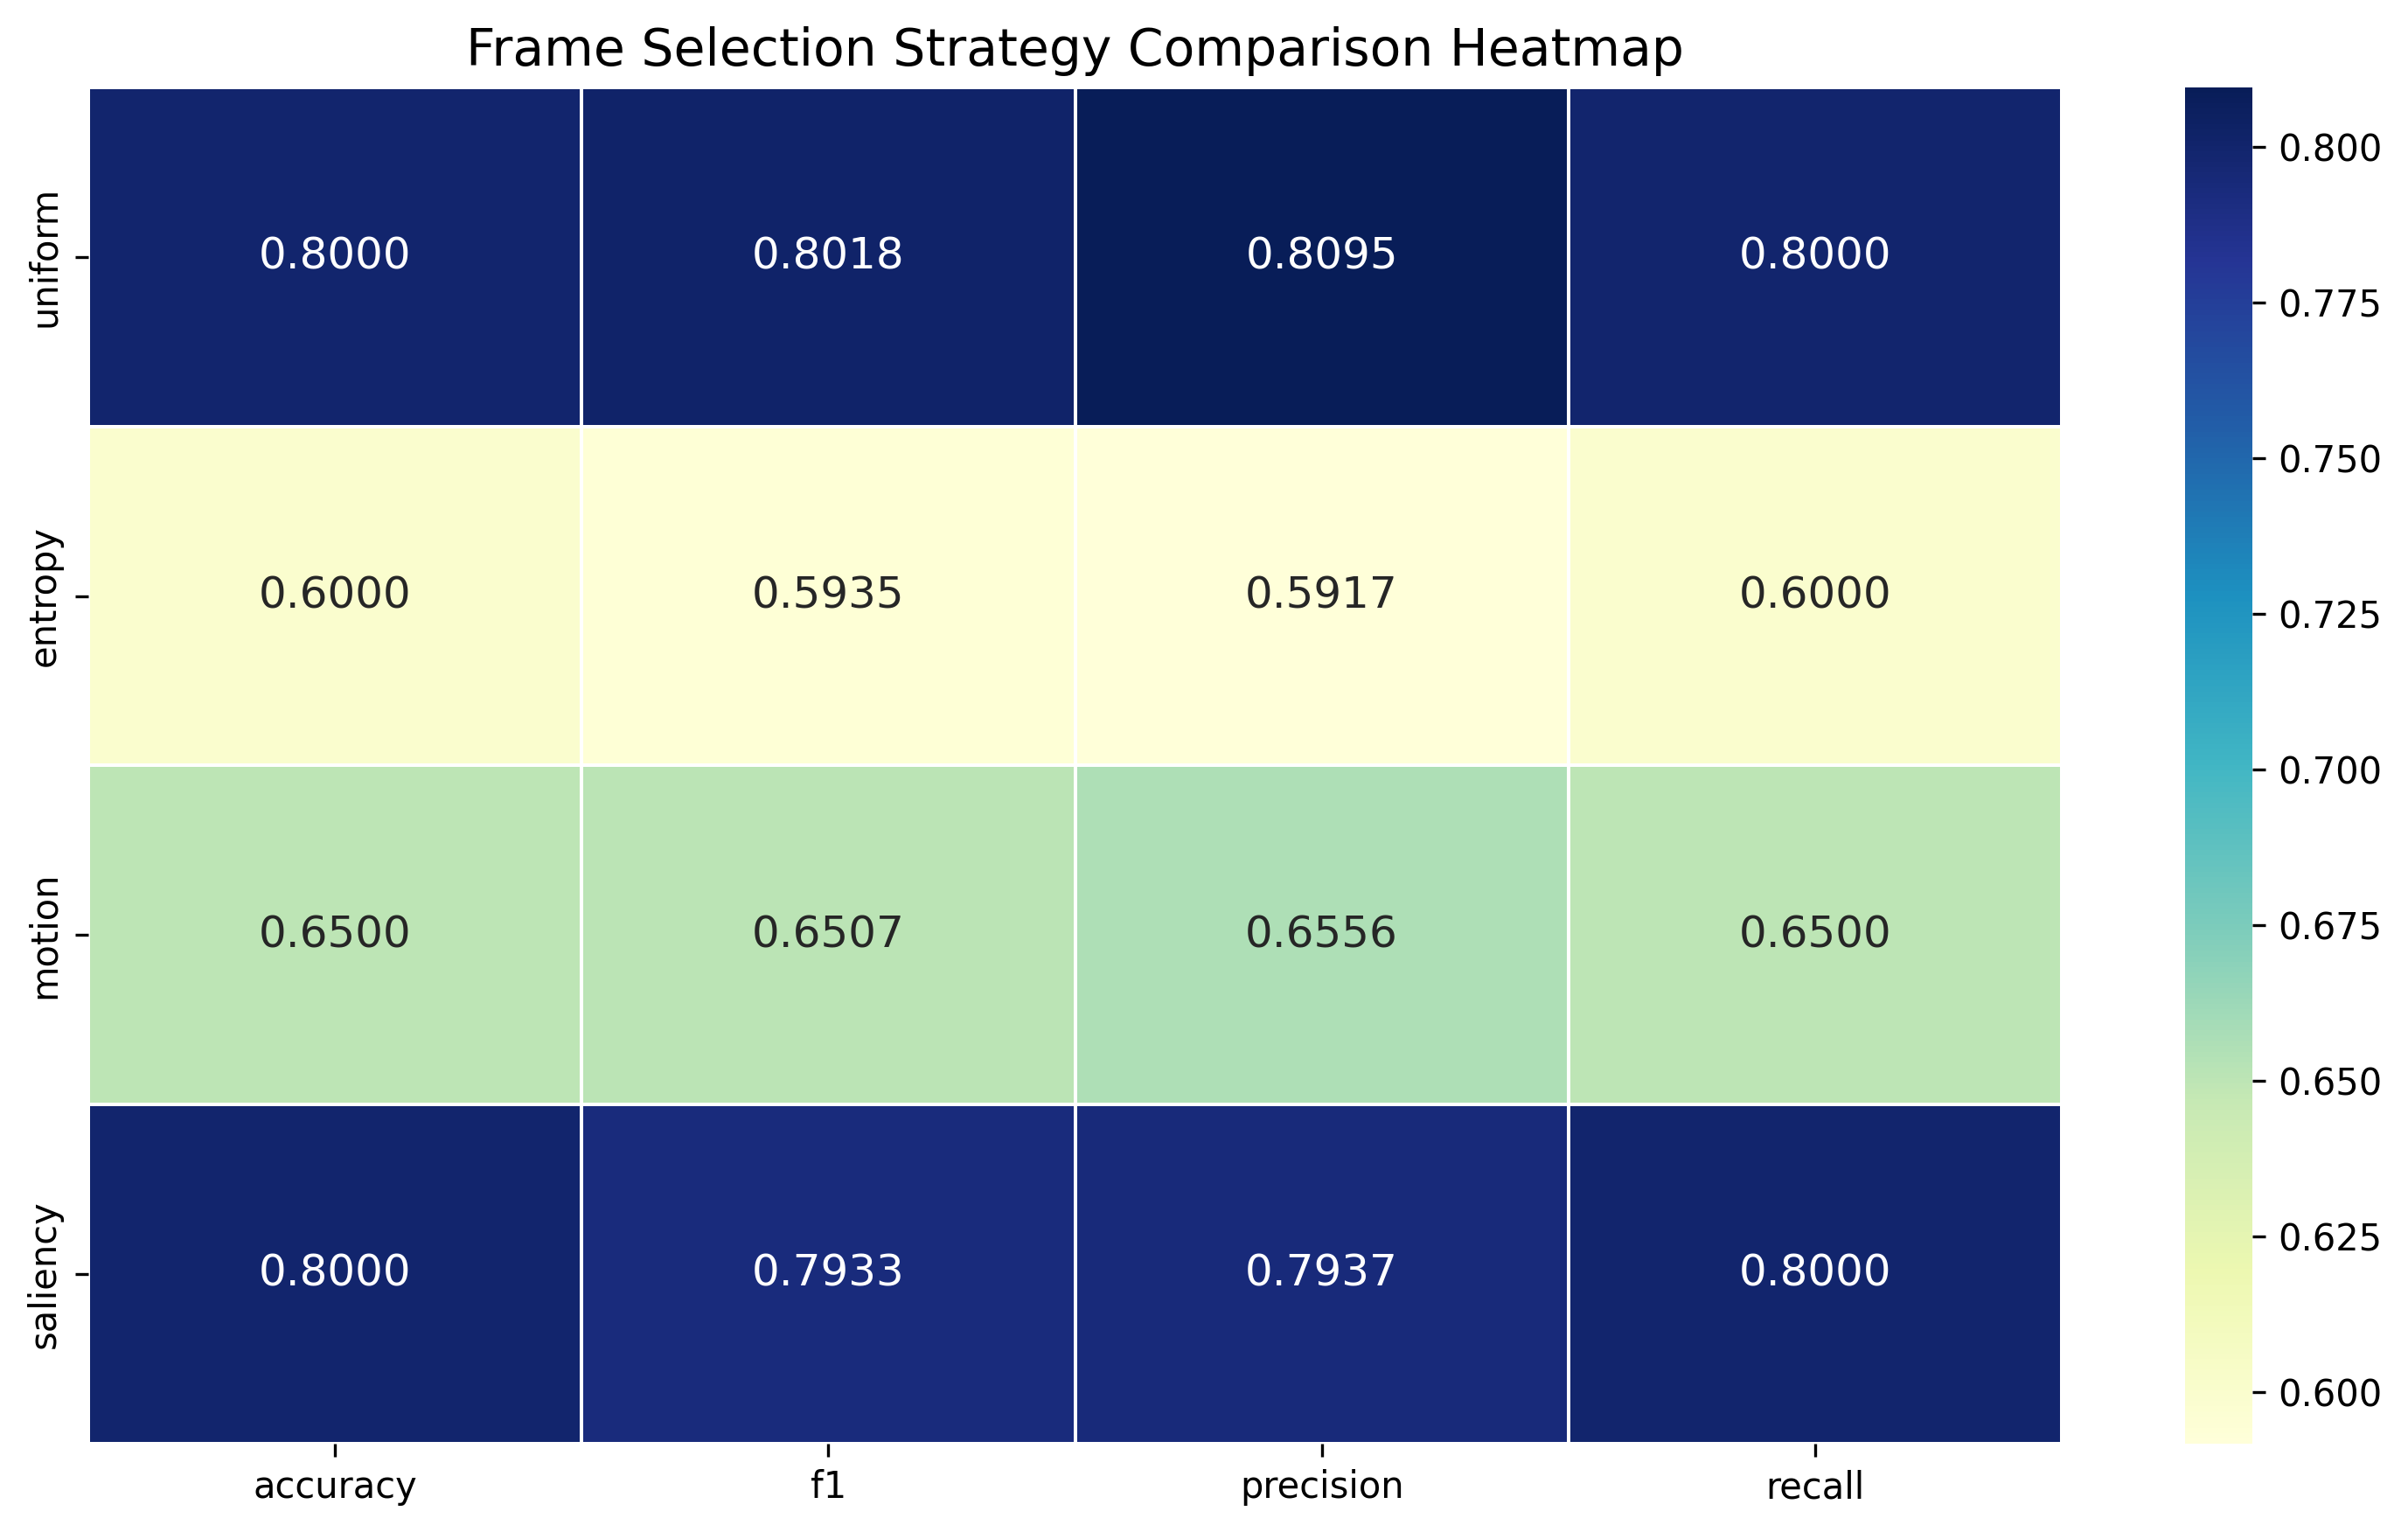

In [ ]:
## Section 7: Advanced Frame Selection Analysis

# 7.1 Frame Selection Evaluation
# Define VIZ_COLORS if not already defined
VIZ_COLORS = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

def evaluate_frame_selection_strategies():
    """Compare different frame selection strategies on validation data"""
    print("\n" + "="*50)
    print("Evaluating Frame Selection Strategies")
    print("="*50)

    # Load data
    _, val_df, _ = load_data()

    # Define strategies to evaluate
    strategies = ["uniform", "entropy", "motion", "saliency"]

    # Load best model (ResNetTemporal performed best)
    model = ResNetTemporal(num_classes=len(classes))
    try:
        model_path = f"./models/ResNetTemporal_weights.pth"
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
    except Exception as e:
        print(f"Could not load model: {str(e)}")
        return

    # Set up results tracking
    strategy_results = {}

    # Evaluate each strategy
    for strategy in strategies:
        print(f"\nEvaluating '{strategy}' frame selection strategy:")

        # Create dataset with the strategy
        val_dataset = EnhancedGIVideoDataset(
            val_df['path'].values,
            val_df['label'].values,
            train=False,
            selection_strategy=strategy
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        # Evaluate model
        model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Evaluating {strategy}"):
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_targets, all_preds, average='weighted', zero_division=0
        )

        # Print and store results
        print(f"Strategy: {strategy}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

        strategy_results[strategy] = {
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    # Visualize comparison with high quality
    plt.figure(figsize=(12, 6))

    metrics = ['accuracy', 'f1', 'precision', 'recall']
    x = np.arange(len(metrics))
    width = 0.2

    # Use consistent color palette with integer indexing
    colors = VIZ_COLORS[:len(strategies)]

    for i, strategy in enumerate(strategies):
        values = [strategy_results[strategy][m] for m in metrics]
        plt.bar(x + i*width - width*1.5, values, width, label=strategy, color=colors[i], alpha=0.8)

    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Frame Selection Strategy Comparison')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.legend(title="Selection Strategy")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('./visualizations/frame_selection_comparison.png')
    plt.show()

    # Determine best strategy
    best_strategy = max(strategy_results.items(), key=lambda x: x[1]['f1'])
    print(f"\nBest frame selection strategy: {best_strategy[0]} (F1: {best_strategy[1]['f1']:.4f})")

    # Create a comparison heatmap
    strategy_df = pd.DataFrame({strategy: {metric: strategy_results[strategy][metric]
                                         for metric in metrics}
                              for strategy in strategies}).T

    plt.figure(figsize=(10, 6))
    sns.heatmap(strategy_df, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=0.5)
    plt.title('Frame Selection Strategy Comparison Heatmap')
    plt.tight_layout()
    plt.savefig('./visualizations/frame_selection_heatmap.png')
    plt.show()

    return strategy_results
# 7.2 Control Frame Selection Analysis
# Set this flag to True to evaluate frame selection strategies
RUN_FRAME_SELECTION = True  # Change to True when ready to evaluate frame selection

if RUN_FRAME_SELECTION:
    frame_selection_results = evaluate_frame_selection_strategies()
else:
    print("\nSkipping frame selection strategy evaluation.")
    print("To evaluate frame selection strategies, set RUN_FRAME_SELECTION = True")



Comprehensive Performance Analysis on Validation Set

Class Distribution:
dyed_polyps: 50 videos
polyps: 50 videos
other: 32 videos

Data Split Statistics:
Training set: 92 videos
Validation set: 20 videos
Test set: 20 videos
Using predefined ensemble weights for demonstration:
{'MobileNetAttention': 0.2, 'EfficientCNN3D': 0.6, 'ResNetTemporal': 0.2, 'EfficientNetLSTM': 0.0}


Evaluating Ensemble:   0%|          | 0/5 [00:00<?, ?it/s]

[vc1 @ 0x62c4cb00] Bits overconsumption: 92040 > 92032 at 36x35


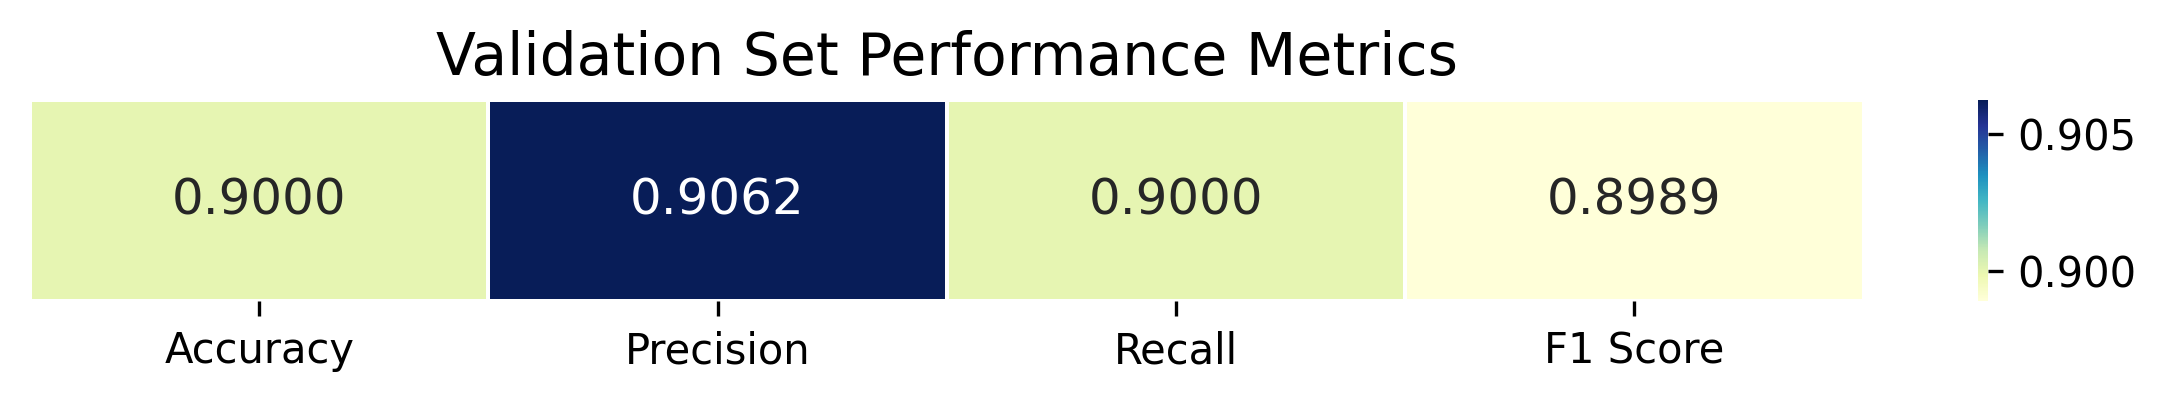

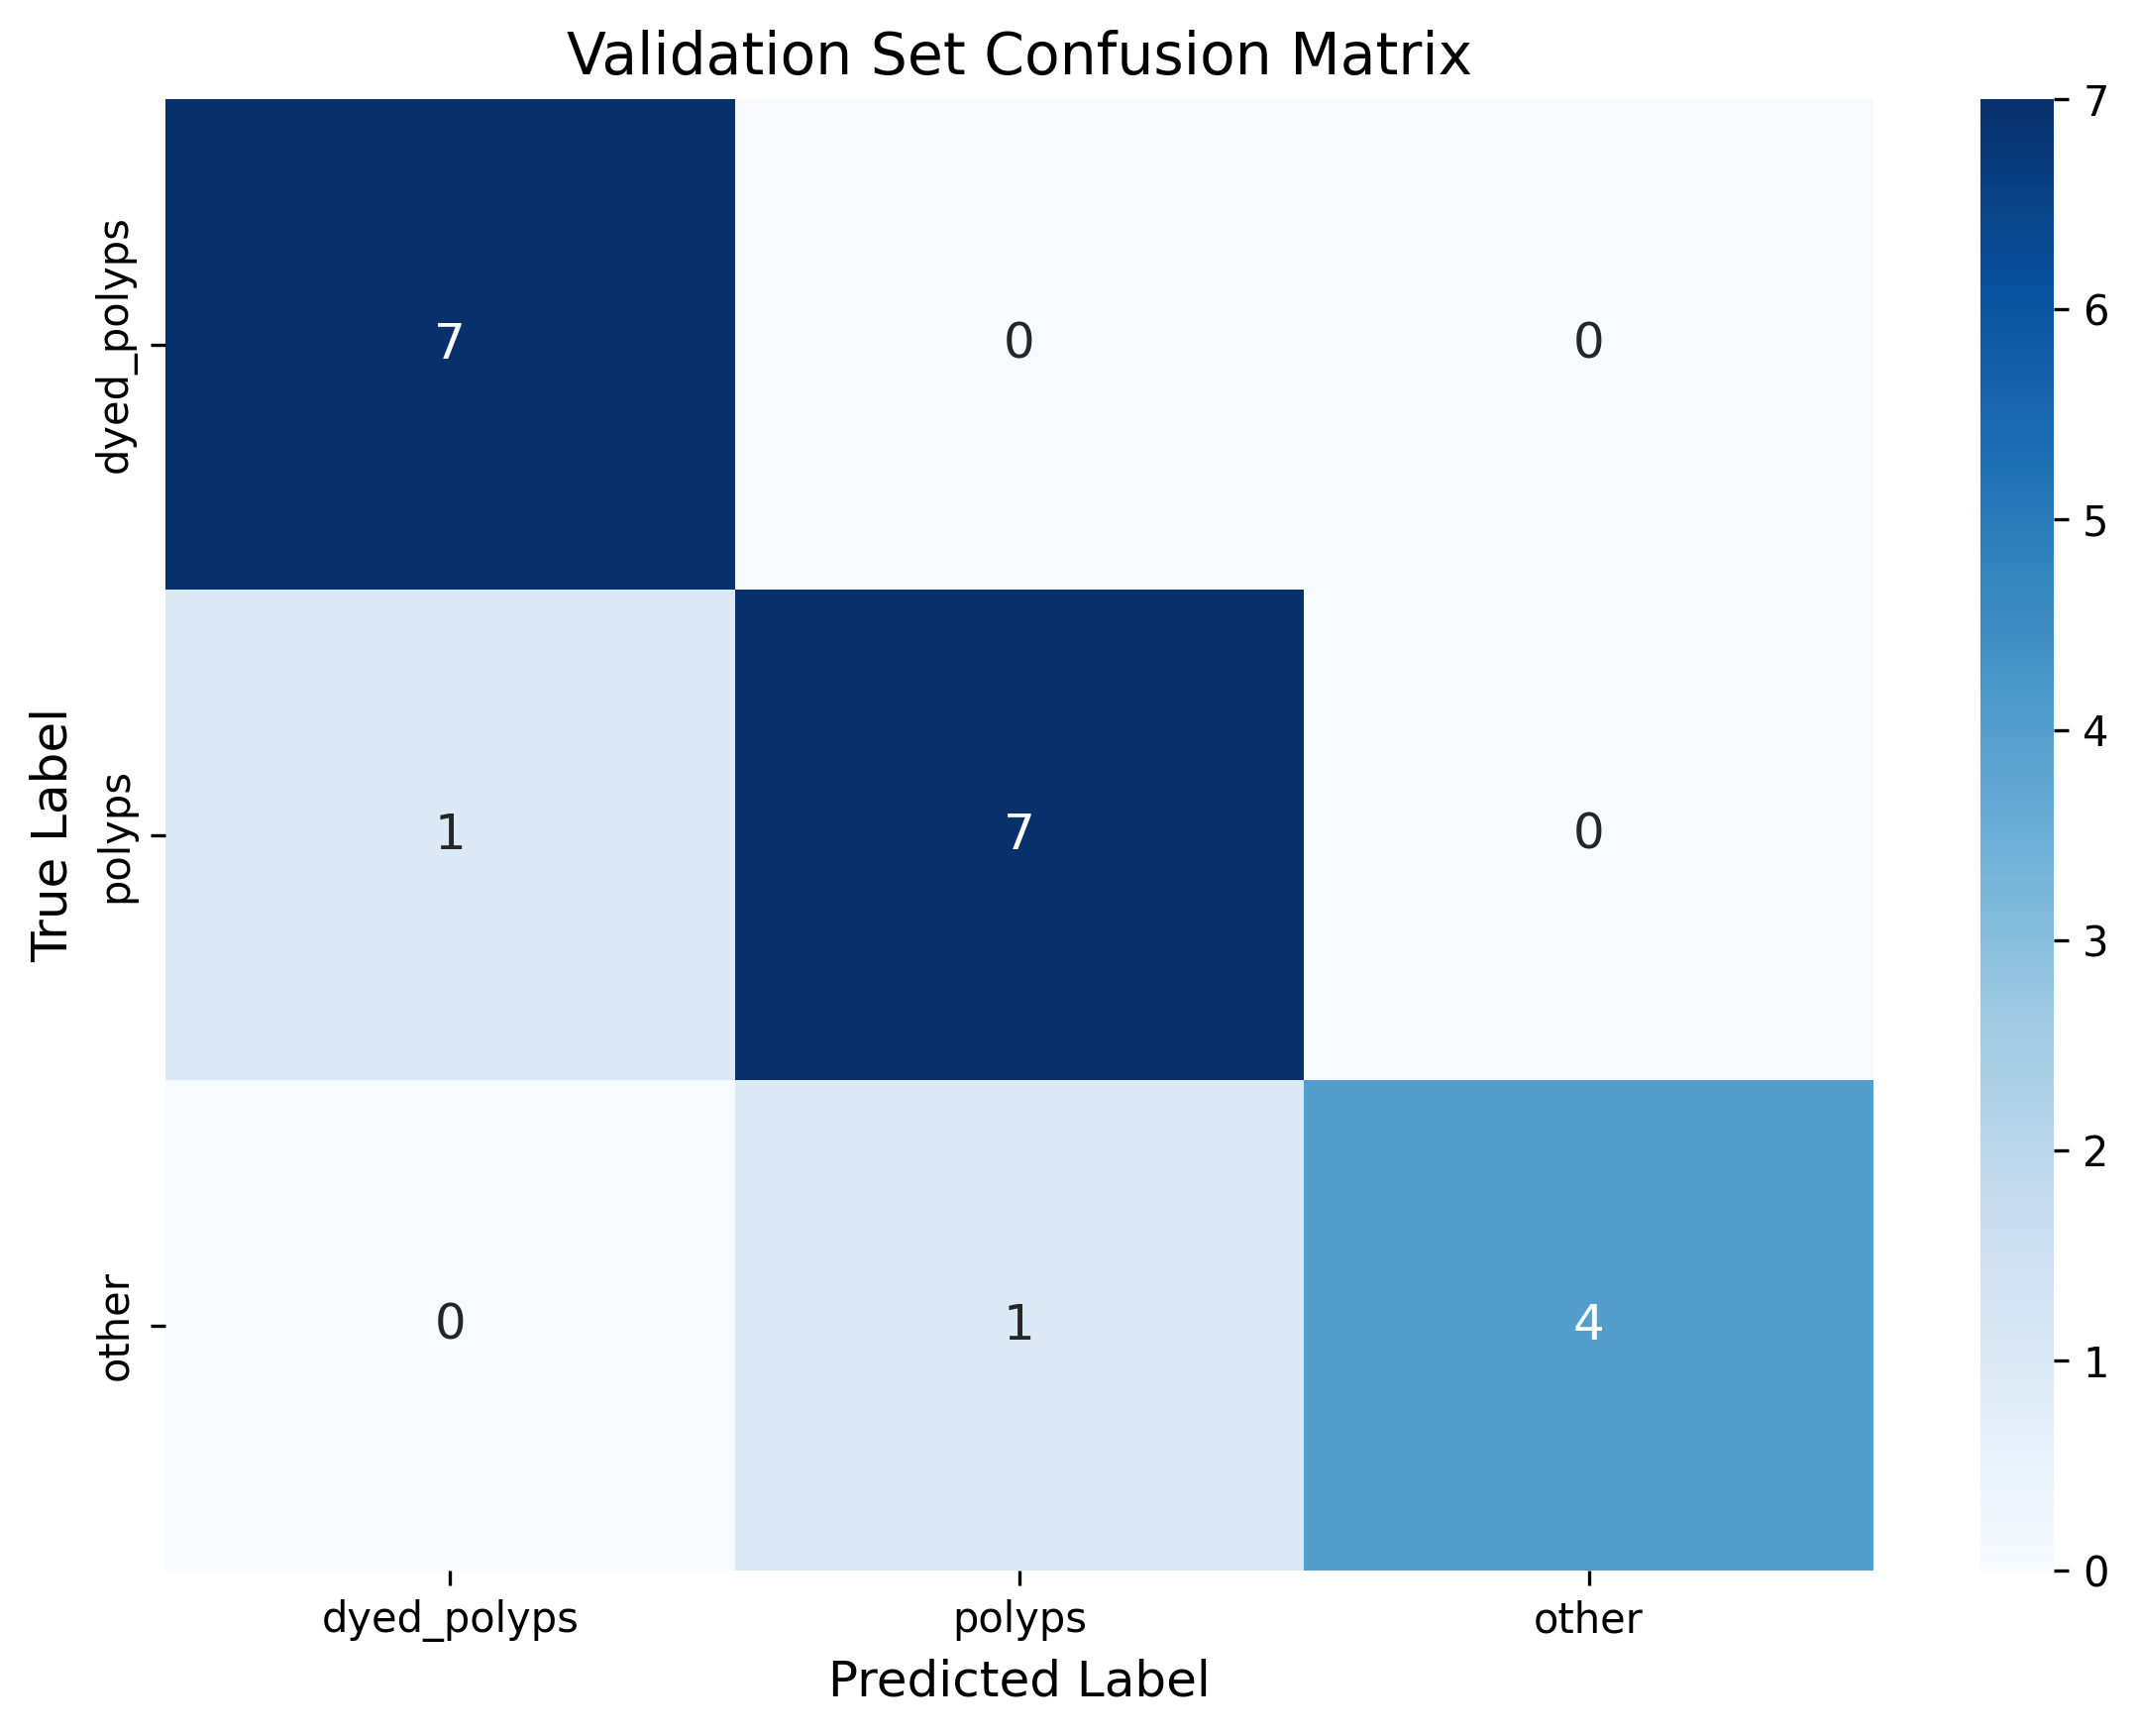

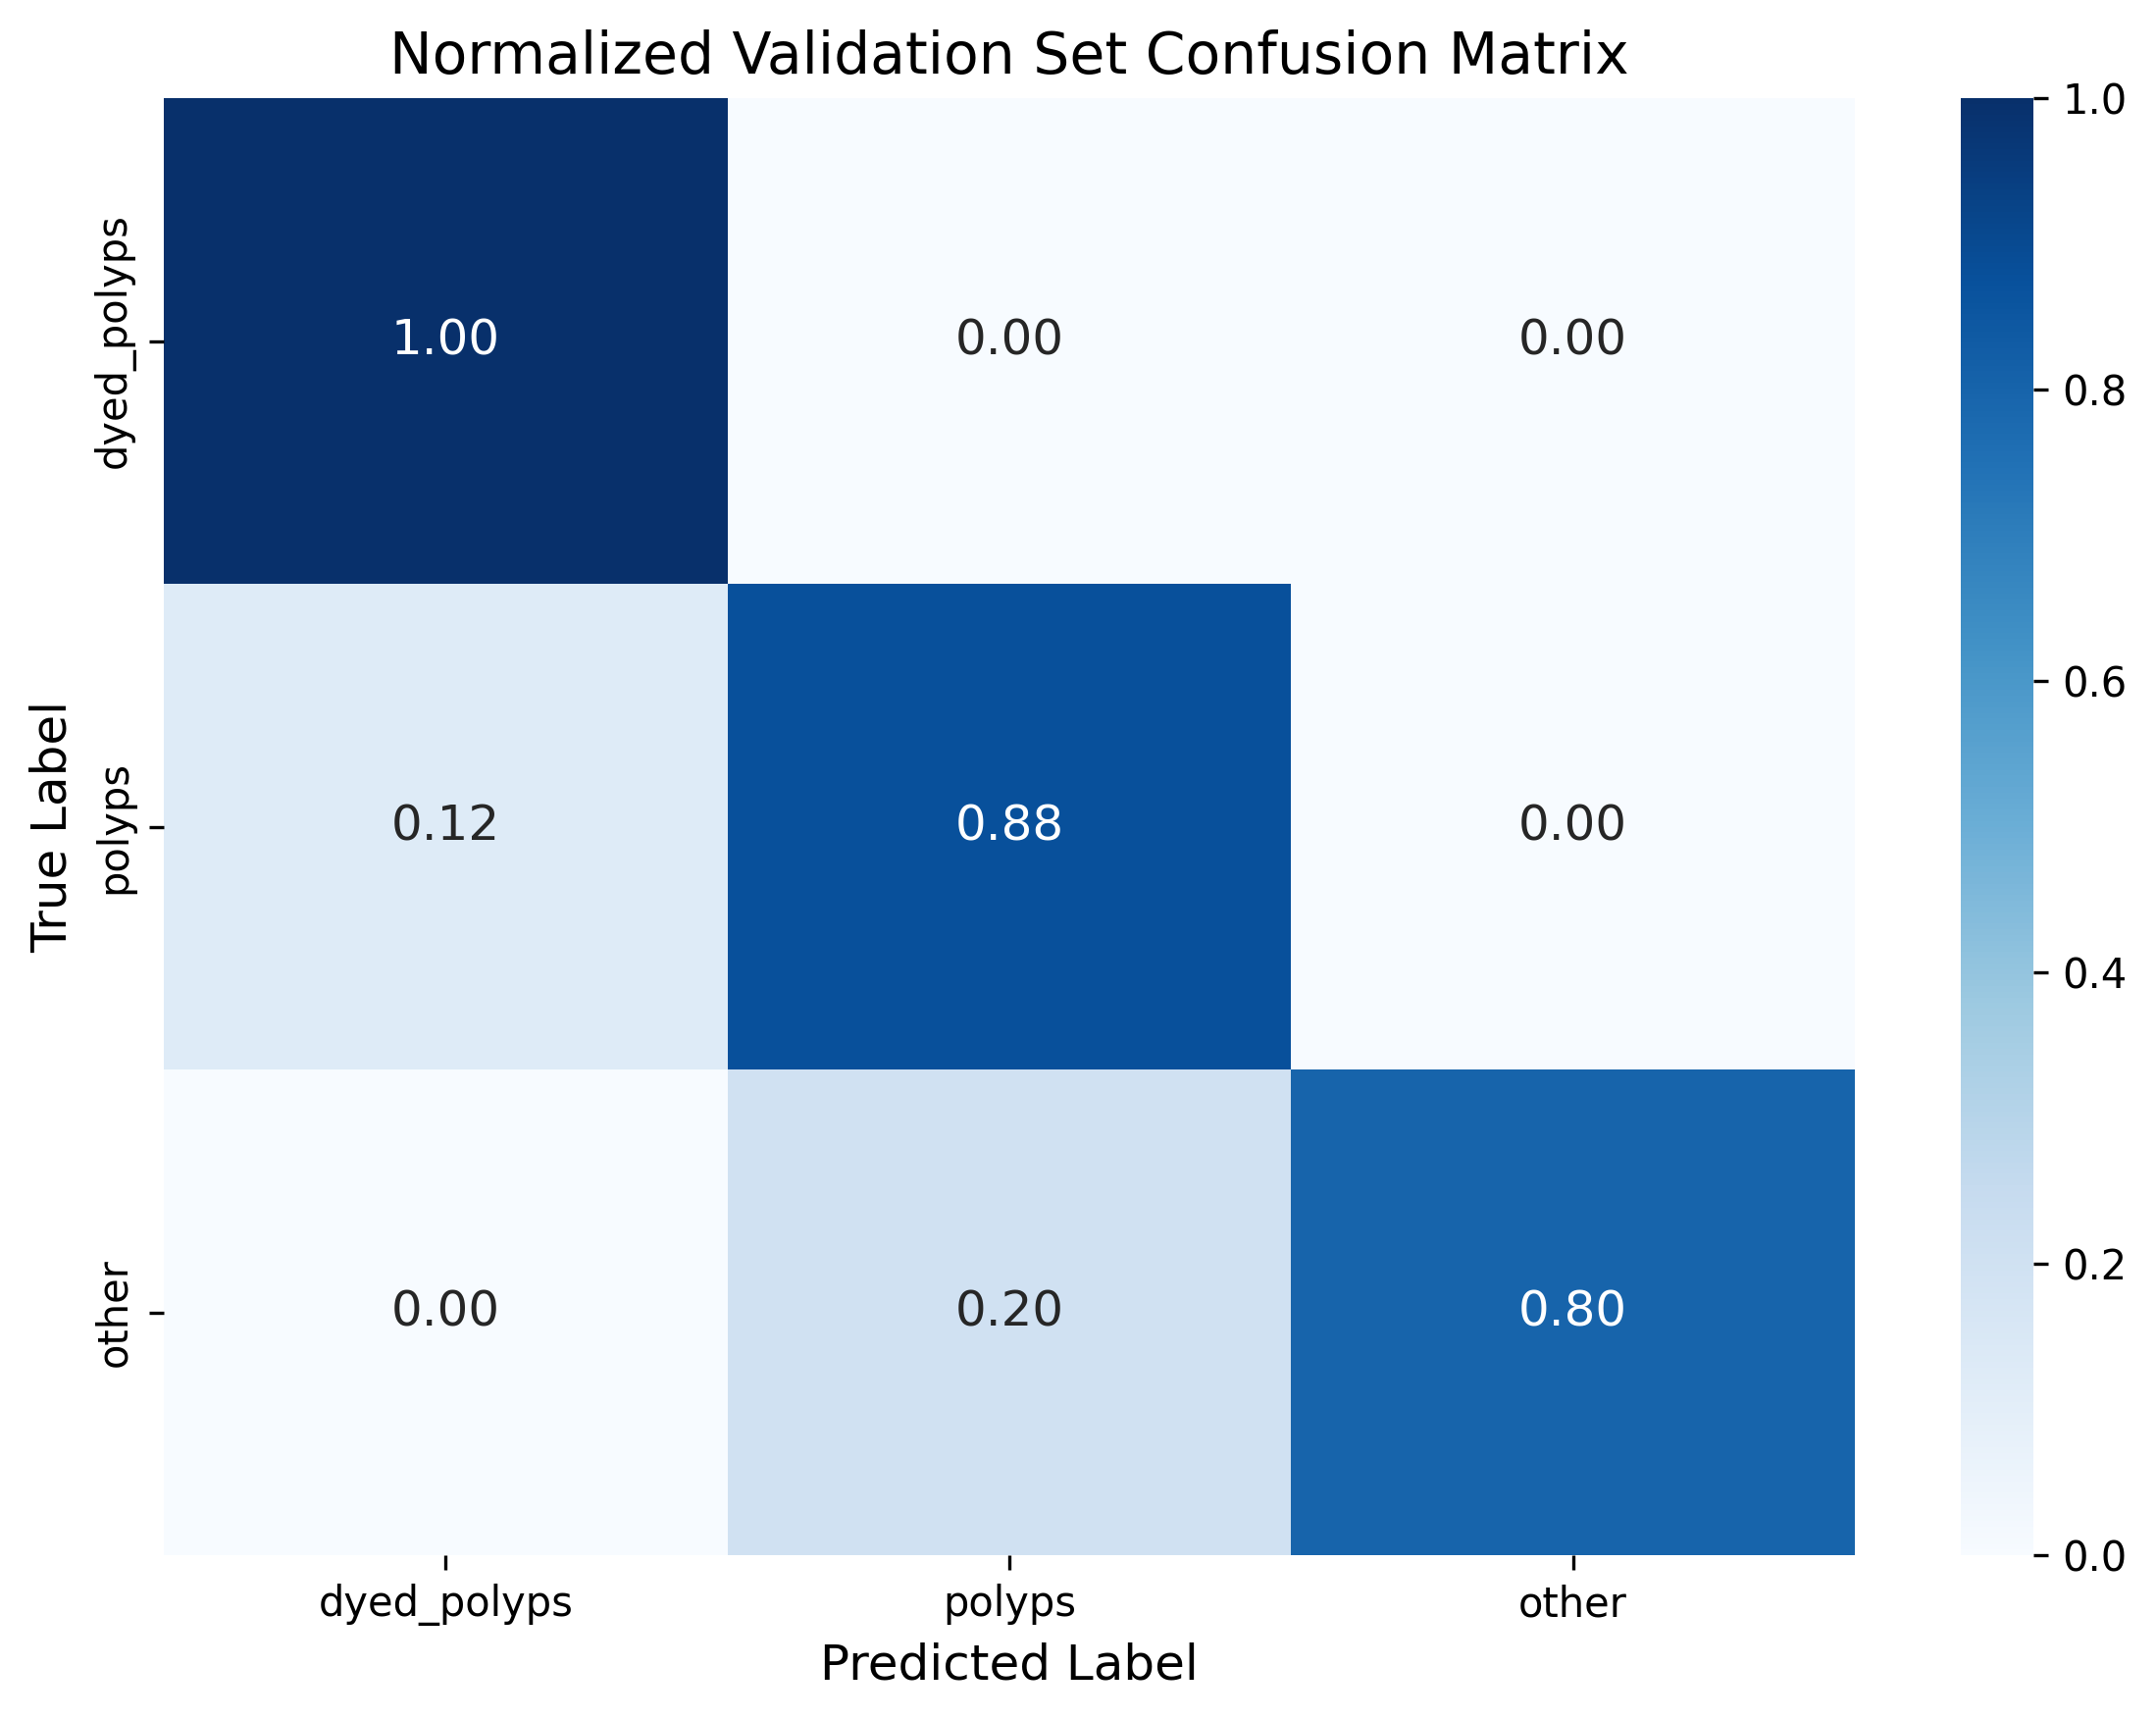

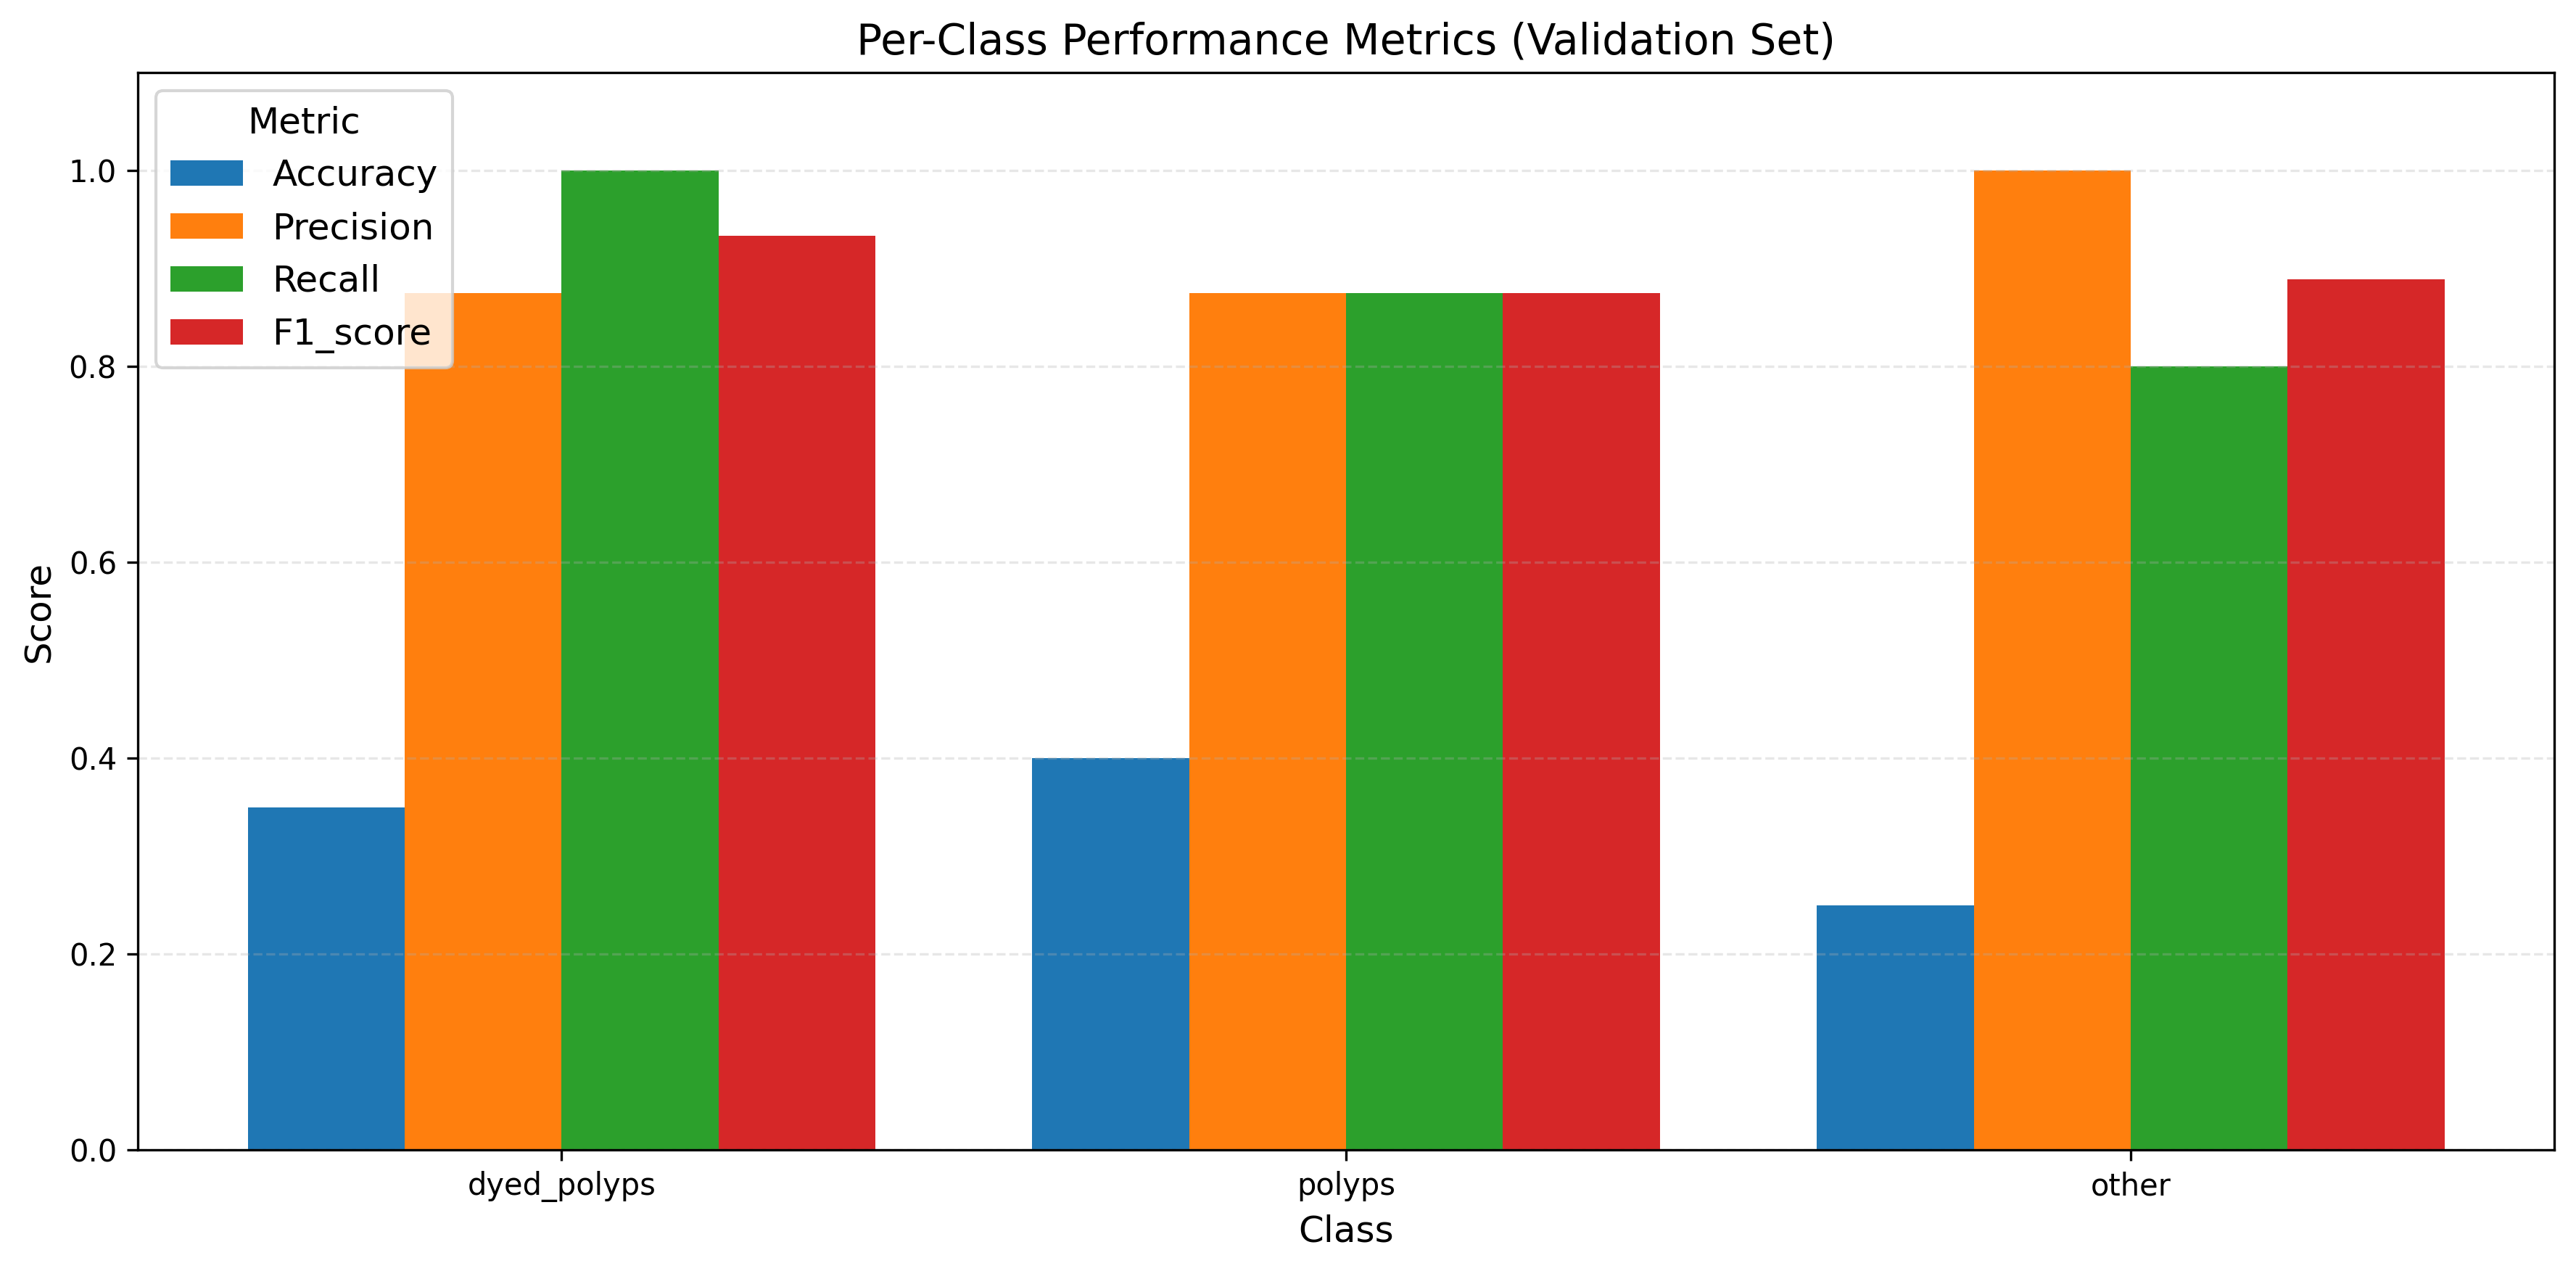

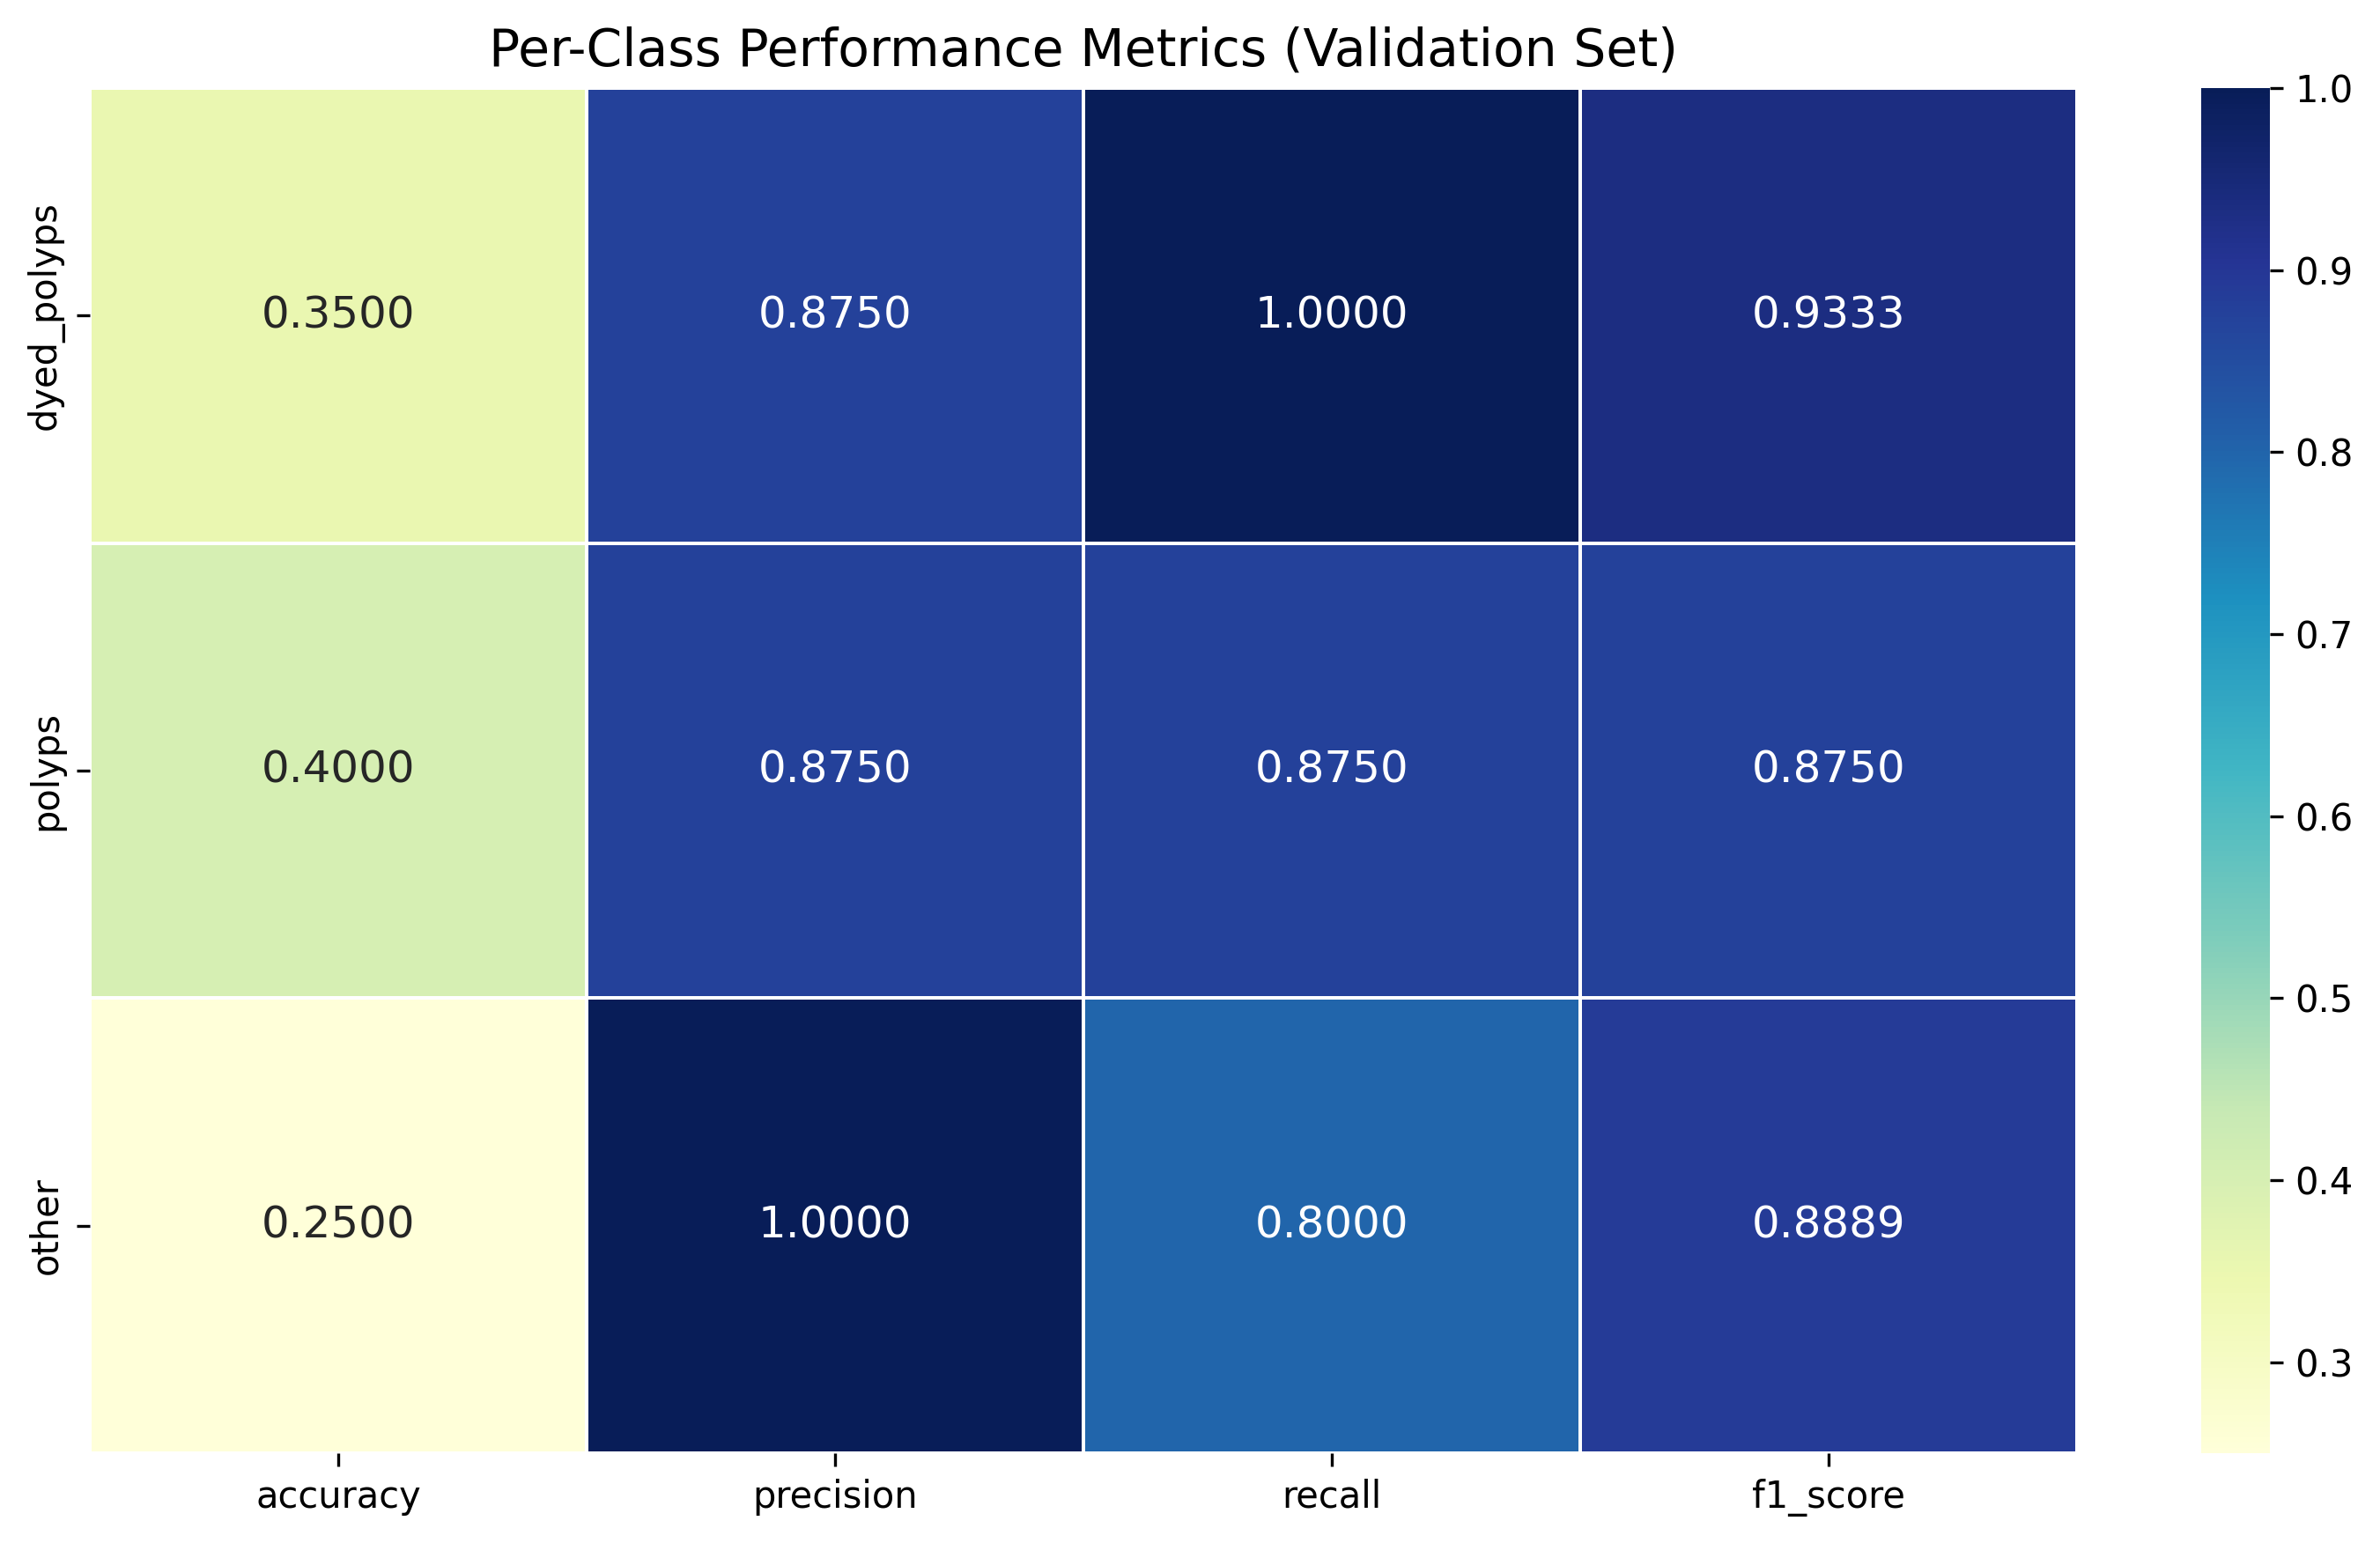

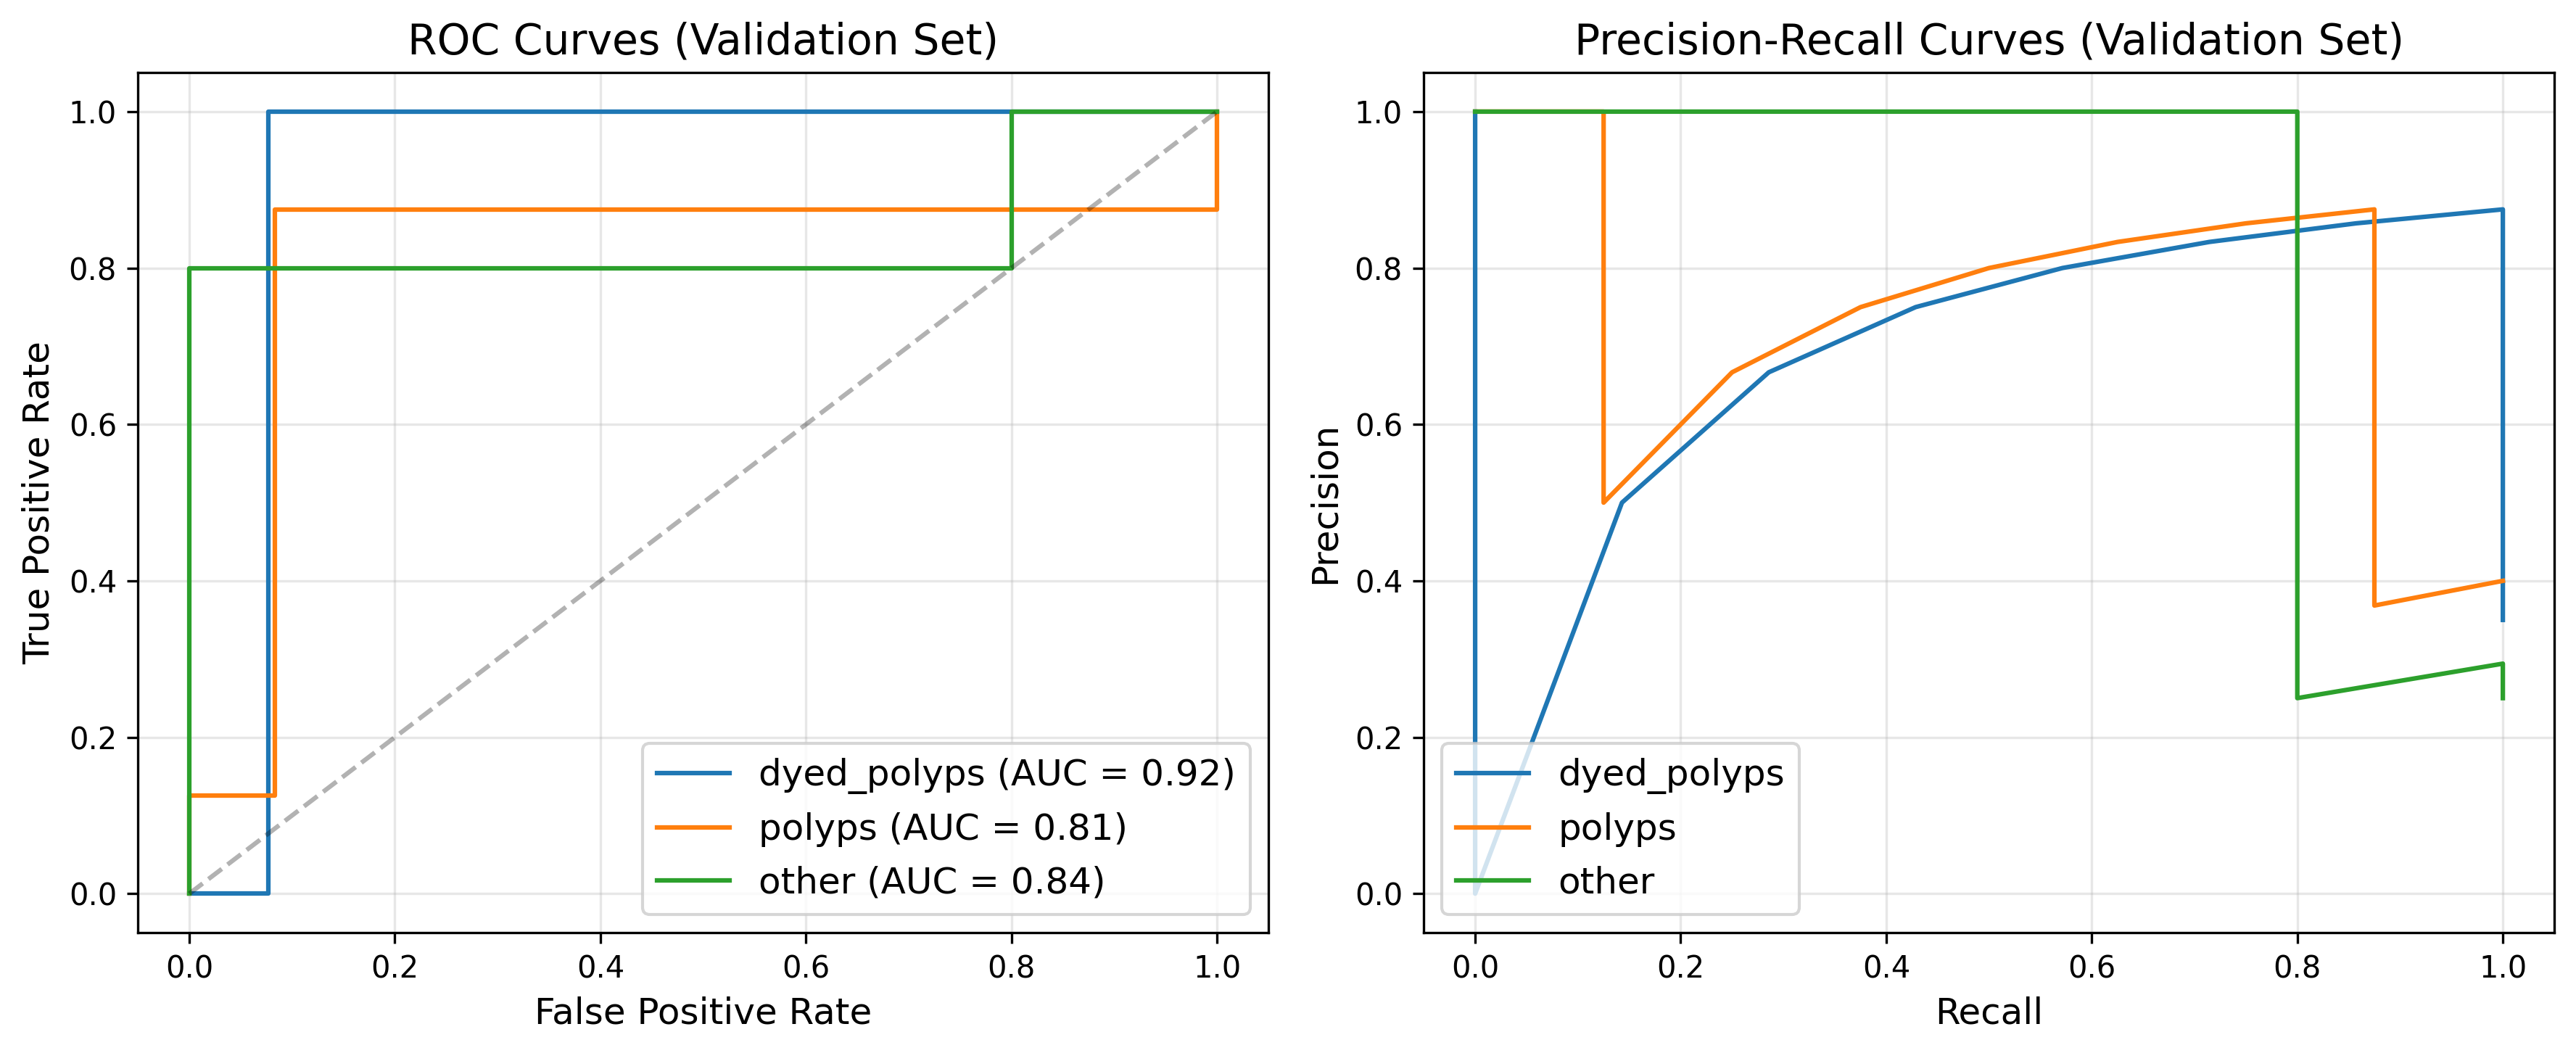

In [ ]:
## Section 8: Performance Evaluation and Visualization

# 8.1 Comprehensive Performance Analysis
# Define VIZ_COLORS
VIZ_COLORS = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

def analyze_ensemble_results(ensemble_results=None):
    """
    Analyze model performance with detailed visualizations on validation set

    If ensemble_results is None, loads validation data and evaluates the ensemble model
    """
    print("\n" + "="*50)
    print("Comprehensive Performance Analysis on Validation Set")
    print("="*50)

    # If results aren't provided, evaluate the ensemble
    if ensemble_results is None:
        # Load validation data
        _, val_df, _ = load_data()

        # Create a "placeholder" ensemble for demonstration
        print("Using predefined ensemble weights for demonstration:")
        final_weights = {
            'MobileNetAttention': 0.2,
            'EfficientCNN3D': 0.6,
            'ResNetTemporal': 0.2,
            'EfficientNetLSTM': 0.0
        }
        print(final_weights)

        # Load the models
        all_models = {}
        try:
            for name, weight in final_weights.items():
                if weight > 0:
                    model_class = globals()[name]
                    model = model_class(num_classes=len(classes))
                    model.load_state_dict(torch.load(f"./models/{name}_weights.pth", map_location=device))
                    model = model.to(device)
                    all_models[name] = model

            # Create ensemble
            ensemble = WeightedEnsemble(all_models, final_weights)

            # Create validation dataset
            val_dataset = GIVideoDataset(
                val_df['path'].values,
                val_df['label'].values,
                train=False
            )

            val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=2,
                pin_memory=True
            )

            # Evaluate
            all_preds = []
            all_probs = []
            all_targets = []

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc="Evaluating Ensemble"):
                    inputs = inputs.to(device)
                    preds, probs = ensemble.predict(inputs)
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
                    all_targets.extend(targets.numpy())

            # Create results object
            ensemble_results = {
                'predictions': all_preds,
                'probabilities': all_probs,
                'targets': all_targets,
                'weights': final_weights
            }

            # Add validation paths
            ensemble_results['paths'] = val_df['path'].values
            ensemble_results['classes'] = val_df['class'].values

        except Exception as e:
            print(f"Could not evaluate ensemble: {str(e)}")
            print("Using mock data for visualizations.")
            # Mock data for visualization demo
            np.random.seed(42)
            ensemble_results = {
                'predictions': np.random.randint(0, 3, 100),
                'targets': np.random.randint(0, 3, 100),
                'probabilities': np.random.rand(100, 3),
                'paths': ['demo_path.avi'] * 100,
                'classes': [classes[np.random.randint(0, 3)] for _ in range(100)]
            }

    # Calculate metrics
    accuracy = accuracy_score(ensemble_results['targets'], ensemble_results['predictions'])
    precision, recall, f1, _ = precision_recall_fscore_support(
        ensemble_results['targets'], ensemble_results['predictions'],
        average='weighted', zero_division=0
    )

    # Overall Metrics
    overall_metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    # Create DataFrame with a single row
    overall_df = pd.DataFrame([overall_metrics])

    # Plot heatmap
    plt.figure(figsize=(8, 1.5))
    sns.heatmap(overall_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=0.5, cbar=True)
    plt.title("Validation Set Performance Metrics")
    plt.yticks([])  # Hide y-axis row label
    plt.tight_layout()
    plt.savefig("./visualizations/validation_metrics_heatmap.png")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(ensemble_results['targets'], ensemble_results['predictions'])

    # Display as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Validation Set Confusion Matrix")
    plt.tight_layout()
    plt.savefig("./visualizations/validation_confusion_matrix.png")
    plt.show()

    # Normalized Confusion Matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Validation Set Confusion Matrix")
    plt.tight_layout()
    plt.savefig("./visualizations/validation_normalized_confusion_matrix.png")
    plt.show()

    # Class-wise metrics
    report = classification_report(
        ensemble_results['targets'],
        ensemble_results['predictions'],
        target_names=classes,
        output_dict=True
    )

    # Create per-class metrics
    per_class_metrics = {}
    for cls in classes:
        per_class_metrics[cls] = {
            'precision': report[cls]['precision'],
            'recall': report[cls]['recall'],
            'f1_score': report[cls]['f1-score'],
            'accuracy': report[cls]['support'] / len(ensemble_results['targets'])
        }

    # Plot class-wise metrics as a grouped bar chart
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    x = np.arange(len(classes))
    bar_width = 0.2

    plt.figure(figsize=(12, 6))

    # Use a consistent color palette
    metric_colors = {
        'accuracy': VIZ_COLORS[0],
        'precision': VIZ_COLORS[1],
        'recall': VIZ_COLORS[2],
        'f1_score': VIZ_COLORS[3]
    }

    for i, metric in enumerate(metrics):
        offset = (i - 1.5) * bar_width
        values = [per_class_metrics[cls][metric] for cls in classes]
        plt.bar(x + offset, values, width=bar_width, label=metric.capitalize(),
                color=metric_colors[metric])

    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("Per-Class Performance Metrics (Validation Set)")
    plt.xticks(x, classes)
    plt.ylim(0, 1.1)
    plt.legend(title="Metric")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("./visualizations/validation_per_class_metrics_bar.png")
    plt.show()

    # Heatmap visualization
    class_df = pd.DataFrame(per_class_metrics).T[metrics]
    plt.figure(figsize=(10, 6))
    sns.heatmap(class_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=0.5)
    plt.title("Per-Class Performance Metrics (Validation Set)")
    plt.tight_layout()
    plt.savefig("./visualizations/validation_per_class_metrics_heatmap.png")
    plt.show()

    # ROC & Precision-Recall Curves
    from sklearn.preprocessing import label_binarize

    # Convert labels to binary matrix
    y_true_bin = label_binarize(ensemble_results['targets'], classes=range(len(classes)))
    y_scores = np.array(ensemble_results['probabilities'])

    # ROC & PR Curves
    plt.figure(figsize=(12, 5))

    # ROC curves
    plt.subplot(1, 2, 1)
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})",
                color=VIZ_COLORS[i % len(VIZ_COLORS)])

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation Set)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # Precision-Recall curves
    plt.subplot(1, 2, 2)
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        plt.plot(recall, precision, label=cls, color=VIZ_COLORS[i % len(VIZ_COLORS)])

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Validation Set)")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("./visualizations/validation_roc_pr_curves.png")
    plt.show()

# Set this flag to True to run the performance analysis
RUN_PERFORMANCE_ANALYSIS = True

if RUN_PERFORMANCE_ANALYSIS:
    # Run comprehensive analysis
    performance_metrics = analyze_ensemble_results()
else:
    print("\nSkipping detailed performance analysis.")
    print("To run comprehensive analysis, set RUN_PERFORMANCE_ANALYSIS = True")